In [1]:
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats as stats
import pandas as pd
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import salem

# Crop Stage Functions

In [2]:
def convert_to_pandas_datetime(dt_no_leap):
    """
    Function to convert DatetimeNoLeap to pandas datetime, handling leap days
    """
    year = dt_no_leap.year
    month = dt_no_leap.month
    day = dt_no_leap.day
    # Adjust for leap years
    if month == 2 and day == 29:
        day = 28
    return pd.to_datetime(f'{year}-{month}-{day}')


def growing_season(veg_len, rep_len, ripe_len):
    """
    Defines the growing season vegetative growth lengths (and start dates)
    
    Args:
        veg_len: [Int] number of days in the vegetative stage
        rep_len: [Int] number of days in the reproductive stage
        ripe_len: [Int] number of days in the ripening stage
    """
    growing_periods = {
        'vegetative': {
            'length': pd.Timedelta(days=veg_len),
            'startdate': pd.Timedelta(days=0),  # Start date is 0 days after desired planting date
        },
        'reproductive': {
            'length': pd.Timedelta(days=rep_len),
            'startdate': pd.Timedelta(days=veg_len)  # Start date is veg_len days after planting date
        },
        'ripening': {
            'length': pd.Timedelta(days=ripe_len),
            'startdate': pd.Timedelta(days=veg_len + rep_len)  # Start date is (veg_len + rep_len) days after planting date
        }
    }
    return growing_periods

In [3]:
def growth_stage_index(ds, start, end, func, starting_date_offset = 7):
    """
    Compute an index of choice for each day in a growth stage

    Args:
        ds (xarray.ds): Dataset
        start (string): 'MM-DD' 1st possible planting date
        end (string): 'MM-DD' Last possible planting date
        func (function): desired index to calculate 
        starting_date_offset (int): rolling window offset period in days

    Returns:
        dictionary: keys = years, items=dictionary of Panda Dataframes for each growth stage
    """
    # Define growing periods, their rolling window lengths and start dates
    growing_periods = growing_season(70, 35, 35)
    
    # Group the data by year
    data_grouped_by_year = ds.groupby('time.year')

    yearly_growing_season_list = []

    # Calculate the averages for each year and each growing period except the last season which runs over
    for year, items in list(data_grouped_by_year.groups.items())[:-1]:
        data_year = ds.isel(time=items)
        stage_indices = {}

        for period, stage in growing_periods.items():
            planting_window_start = pd.to_datetime(f'{year}-{start}') + stage['startdate']
            planting_window_end = pd.to_datetime(f'{year}-{end}') + stage['startdate']

            indices_per_period = []

            # Iterate through each day in the rolling window for the current growing period
            current_start_date = planting_window_start
            while current_start_date <= planting_window_end:

                stage_enddate = current_start_date + stage['length']

                # select data from original DataArray instead of yearly grouped data
                rolling_window_data = ds.sel(time=slice(current_start_date, stage_enddate))

                # Calculate the climate index for this rolling period
                index = func(rolling_window_data)
                index = index.assign_coords(time=current_start_date).expand_dims('time')
                indices_per_period.append(index)

                # Move to the next rolling window
                current_start_date += pd.DateOffset(days=starting_date_offset)
            
            # combine each day from the stage in one DataArray
            stage_results = xr.concat(indices_per_period, dim='time')
            stage_indices[period] = stage_results
        
        # Combine DataArrays for different growing periods 
        full_season_dataset = xr.Dataset(stage_indices)
        # print(full_season_dataset)
        
        yearly_growing_season_list.append(full_season_dataset.assign_coords(year=year))

    # Concatenate individual yearly datasets along the time dimension
    final_dataset = xr.concat(yearly_growing_season_list, dim='time')

    print(f"Done with index: {func}")

    return final_dataset


In [4]:
# # confirm planting dates

# # Load xarray DataArray or Dataset
# test = xr.open_dataset('/glade/work/ninag/ARISE/min_temp_atm_TREFHTMN/ensemble_members/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001.cam.h1.TREFHTMN.2035-2069.nc').load().TREFHTMN
# # arise_tmax = xr.open_dataset('/glade/work/ninag/ARISE/max_temp_atm_TREFHTMX/ensemble_members/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001.cam.h1.TREFHTMX.2035-2069.nc').TREFHTMX
# # arise_precip = xr.open_dataset('/glade/work/ninag/ARISE/precip_atm_PRECT/ensemble_members/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001.cam.h1.PRECT.2065-2069.nc').PRECT

# data = test.sel(lon=slice(65, 100), lat=slice(5, 37))

# # Convert DatetimeNoLeap objects to pandas datetime
# data['time'] = [convert_to_pandas_datetime(dt) for dt in data.time.values]

# testing = data.sel(time=slice('2035','2037'))



# # Parameters
# start='10-15'
# end='12-31'
# ds = testing
# func=tropical_nights
# starting_date_offset = 7


# # Define growing periods, their rolling window lengths, and start dates
# growing_periods = growing_season(70, 35, 35)

# # Group the data by year
# data_grouped_by_year = ds.groupby('time.year')

# # Create an empty dataset to store growing season indices
# ds_list = []

# # Calculate the averages for each year and each growing period except the last season which runs over
# for year, items in list(data_grouped_by_year.groups.items())[:-1]:
#     data_year = ds.isel(time=items)
#     stage_indices = {}

#     # Iterate over growing periods
#     for period, stage in growing_periods.items():
#         planting_window_start = pd.to_datetime(f'{year}-{start}') + stage['startdate']
#         planting_window_end = pd.to_datetime(f'{year}-{end}') + stage['startdate']

#         indices_per_period = []

#         # Iterate through each day in the rolling window for the current growing period
#         current_start_date = planting_window_start
#         while current_start_date <= planting_window_end:

#             stage_end_date = current_start_date + stage['length']

#             print(current_start_date)

#             # rolling_window_data = ds.sel(time=slice(current_start_date, stage_end_date))

#             # # Calculate the index for this rolling window
#             # index = func(rolling_window_data)
#             # # print(index)

#             # index = index.assign_coords(time=current_start_date).expand_dims('time')
#             # indices_per_period.append(index)

#             # Move to the next rolling window
#             current_start_date += pd.DateOffset(days=starting_date_offset)

# #         # Combine the indices for each growing period
# #         stage_indices[period] = xr.concat(indices_per_period, dim='time')
# #         print(f"Year: {year}")
# #         print(f"Period: {period}")
# #         print(stage_indices[period])

# #     # Combine DataArrays for different growing periods
# #     full_season_dataset = xr.Dataset(stage_indices)
# #     # print(full_season_dataset)
# #     ds_list.append(full_season_dataset.assign_coords(year=year))

# # # Concatenate individual yearly datasets along the time dimension
# # final_dataset = xr.concat(ds_list, dim='time')
# # print(final_dataset)

# # Group by year and calculate the mean for each season
# # result = final_dataset.groupby('year').mean('time')

# # print(result)

# Calculate Indices

Temperature
* TR (Tropical nights) >20C
* HD34 (Hot days) >34C
* WSDI (Warm spell duration index) >23C
* CSDI (Annual count when at least six consecutive days of min temperature <10th percentile) <15C

Precipitation
* PRCPTOT
* CWD (above 1 mm for non-monsoon)
* CDD (below 1 mm for non-monsoon)
* R5mm (dry days <5mm)
* R20mm (very wet days >20)
* Rx5day (Wettest 5-Day Period)

## Temperature

In [4]:
def tropical_nights(ds):
    """
    Compute the number of days when Tmin is above 20C
    Args:
        ds (xr.DataArray): tmin data in Celsius
    Returns:
        xr.DataArray
    """
    ds = xr.DataArray((ds > 20).sum('time'))
    ds = ds.rename('TR_20')
    ds.attrs["units"], ds.attrs["longname"] = "days", "Number of days with min T exceeding 20C"
    return ds

def frost_days(ds):
    """
    Compute the number of days when Tmin is below 0
    Args:
        ds (xr.DataArray): Tmin data in Celsius
    Returns:
        xr.DataArray
    """
    ds = xr.DataArray((ds < 0).sum('time'))
    ds = ds.rename('FD_0')
    ds.attrs["units"], ds.attrs["longname"] = "days", "Number of days with min T below 0C"
    return ds

def icing_days(ds):
    """
    Compute the number of days when Tmax is below 0
    Args:
        ds (xr.DataArray): Tmax data in Celsius
    Returns:
        xr.DataArray
    """
    ds = xr.DataArray((ds < 0).sum('time'))
    ds = ds.rename('ID_0')
    ds.attrs["units"], ds.attrs["longname"] = "days", "Number of days with max T below 0C"
    return ds

def hot_days(ds):
    """
    Compute the number of days when Tmax is above 34C
    Args:
        ds (xr.DataArray): tmax data in Celsius
    Returns:
        xr.DataArray
    """
    ds = xr.DataArray((ds > 34).sum('time'))
    ds = ds.rename('HD34')
    ds.attrs["units"], ds.attrs["longname"] = "days", "Number of days with max T exceeding 34C"
    return ds

def WSDI(ds, threshold=23):
    """
    Calculate the total number of days contributing to warm spells, which are
    defined as periods of at least 6 consecutive days above the threshold.

    Parameters:
    - data_array: xarray.DataArray
        Time series data array.
    - threshold: int
        Threshold for which to classify days as warm.

    Returns:
    - xarray.DataArray
        Total number of at least 6 consecutive day periods satisfying the condition.
    """
    # Create a copy of the original DataArray
    result = ds.copy().isel(time=0).drop_vars('time')
    
    for lat in ds.lat:
        for lon in ds.lon:
            data_row = ds.sel(lat=lat, lon=lon)
            
            arr = data_row > threshold

            # pad beginning with False for edge cases
            padded_arr = np.pad(arr, (1, 0), 'constant')
            # convert to binary and track changes along time series
            boundaries = np.diff(padded_arr.astype(int))
            
            start_indices = np.where(boundaries == 1)[0]
            end_indices = np.where(boundaries == -1)[0]
            
            if (len(start_indices) > len(end_indices)):
                end_indices = np.append((end_indices), len(arr))

            consecutive_lengths = end_indices - start_indices
    
            warm_spell_days = np.sum(consecutive_lengths[consecutive_lengths >= 6])
            
            result.loc[dict(lat=lat, lon=lon)] = warm_spell_days
    
    # format array
    result = result.rename('WSDI')
    result.attrs["units"], result.attrs["longname"] = "days", f"Total number of days contributing to warm spells (>{threshold}C)"
    
    return result

def CSDI(ds, threshold=15):
    """
    Calculate the total number of days contributing to cold spells, which are
    defined as periods of at least 6 consecutive days below the threshold.

    Parameters:
    - data_array: xarray.DataArray
        Time series data array.
    - threshold: int
        Threshold for which to classify days as cold.

    Returns:
    - xarray.DataArray
        Total number of at least 6 consecutive day periods satisfying the condition.
    """
    # Create a copy of the original DataArray
    result = ds.copy().isel(time=0).drop_vars('time')

    for lat in ds.lat:
        for lon in ds.lon:
            data_row = ds.sel(lat=lat, lon=lon)

            arr = data_row < threshold

            # pad beginning with False for edge cases
            padded_arr = np.pad(arr, (1, 0), 'constant')
            # convert to binary and track changes along time series
            boundaries = np.diff(padded_arr.astype(int))

            start_indices = np.where(boundaries == 1)[0]
            end_indices = np.where(boundaries == -1)[0]

            if (len(start_indices) > len(end_indices)):
                end_indices = np.append((end_indices), len(arr))

            consecutive_lengths = end_indices - start_indices

            cold_spell_days = np.sum(consecutive_lengths[consecutive_lengths >= 6])

            result.loc[dict(lat=lat, lon=lon)] = cold_spell_days

    # format array
    result = result.rename('CSDI')
    result.attrs["units"], result.attrs["longname"] = "days", f"Total number of days contributing to cold spells (<{threshold}C)"

    return result

## Precipitation

In [5]:
def PRCPTOT(ds):
    """
    Compute the total precipitation
    Args:
        ds (xr.DataArray): Precipitation data in mm
    Returns:
        xr.DataArray
    """
    ds = xr.DataArray(ds.sum('time'))
    ds = ds.rename('PRCPTOT')
    ds = ds.assign_attrs(units='mm')
    ds = ds.assign_attrs(long_name='Total (convective and large-scale) precipitation (liq + ice)')
    return ds

def R5mm(ds, threshold=5):
    """
    Compute the number of days with precipitation below 5 mm
    Args:
        ds (xr.DataArray): Precipitation data in mm
    Returns:
        xr.DataArray
    """
    ds = xr.DataArray((ds < threshold).sum('time'))
    ds = ds.rename(f'R{threshold}mm')
    ds.attrs["units"], ds.attrs["longname"] = "days", f"Number of days with precip below {threshold} mm"
    return ds

def R20mm(ds, threshold=20):
    """
    Compute the number of days with precipitation above 5 mm
    Args:
        ds (xr.DataArray): Precipitation data in mm
    Returns:
        xr.DataArray
    """
    ds = xr.DataArray((ds >= threshold).sum('time'))
    ds = ds.rename(f'R{threshold}mm')
    ds.attrs["units"], ds.attrs["longname"] = "days", f"Number of days with precip exceeding {threshold} mm"
    return ds

def Rx5day(ds):
    """
    Compute wettest 5-Day period
    Args: 
        ds (xarray.DataArray): Precipitation data in mm
    Returns:
        xr.DataArray
    """
    ds = ds.rolling(time=5, center=True).sum().max('time')
    ds = ds.rename('Rx5day')
    ds = ds.assign_attrs(units='mm')
    ds = ds.assign_attrs(long_name='Total precipitation during the wettest 5-day period')
    return ds

def CWD(ds, threshold=1):
    """
    Calculate the maximum number of consecutive wet days above the threshold.

    Parameters:
    - data_array: xarray.DataArray
        Time series data array.
    - threshold: int
        Threshold for which to classify days as wet.

    Returns:
    - xarray.DataArray
        Maximum number of consecutive days satisfying the condition.
    """
    # Create a copy of the original DataArray
    result = ds.copy().isel(time=0).drop_vars('time')
    
    for lat in ds.lat:
        for lon in ds.lon:
            precip_data_row = ds.sel(lat=lat, lon=lon)
            
            arr = precip_data_row > threshold
            padded_arr = np.pad(arr, (1, 0), 'constant')  # pad beginning with False for edge cases
            boundaries = np.diff(padded_arr.astype(int))  # convert to binary and track changes along time series

            # find instances of False -> True and True -> False switches
            start_indices = np.where(boundaries == 1)[0]
            end_indices = np.where(boundaries == -1)[0]

            if (len(start_indices) > len(end_indices)):
                end_indices = np.append((end_indices), len(arr))

            consecutive_lengths = end_indices - start_indices
            max_consecutive_length = np.max(consecutive_lengths) if len(consecutive_lengths) > 0 else 0

            result.loc[dict(lat=lat, lon=lon)] = max_consecutive_length

    # format array
    result = result.rename('CWD')
    result.attrs["units"], result.attrs["longname"] = "days", f"Maximum number of days with precip above {threshold} mm"

    return result


def CDD(ds, threshold=1):
    """
    Calculate the maximum number of consecutive dry days below the threshold.

    Parameters:
    - data_array: xarray.DataArray
        Time series data array.
    - threshold: int
        Threshold for which to classify days as dry.

    Returns:
    - xarray.DataArray
        Maximum number of consecutive days satisfying the condition.
    """
    # Create a copy of the original DataArray
    result = ds.copy().isel(time=0).drop_vars('time')

    for lat in ds.lat:
        for lon in ds.lon:
            precip_data_row = ds.sel(lat=lat, lon=lon)

            arr = precip_data_row < threshold
            padded_arr = np.pad(arr, (1, 0), 'constant')  # pad beginning with False for edge cases
            boundaries = np.diff(padded_arr.astype(int))  # convert to binary and track changes along time series

            # find instances of False -> True and True -> False switches
            start_indices = np.where(boundaries == 1)[0]
            end_indices = np.where(boundaries == -1)[0]
            
            if (len(start_indices) > len(end_indices)):
                end_indices = np.append((end_indices), len(arr))

            consecutive_lengths = end_indices - start_indices
            max_consecutive_length = np.max(consecutive_lengths) if len(consecutive_lengths) > 0 else 0
            
            result.loc[dict(lat=lat, lon=lon)] = max_consecutive_length

    # format array
    result = result.rename('CDD')
    result.attrs["units"], result.attrs["longname"] = "days", f"Maximum number of days with precip below {threshold} mm"
    
    return result

# Plots

In [7]:
# load daily data
tmin = []
for i in sorted(glob.glob('/glade/work/ninag/ARISE/min_temp_atm_TREFHTMN/ensemble_members/b.e21.*')):
    x = xr.open_dataset(i).TREFHTMN.sel(lon=slice(65, 100), lat=slice(5, 37))
    y = x - 273.15  # update units
    y = y.assign_attrs(x.attrs)
    y.attrs['units'] = 'C'
    # Convert DatetimeNoLeap objects to pandas datetime
    y['time'] = [convert_to_pandas_datetime(dt) for dt in y.time.values]
    tmin.append(y)

tmax = []
for i in sorted(glob.glob('/glade/work/ninag/ARISE/max_temp_atm_TREFHTMX/ensemble_member/b.e21.*')):
    x = xr.open_dataset(i).TREFHTMX.sel(lon=slice(65, 100), lat=slice(5, 37))
    y = x - 273.15  # update units
    y = y.assign_attrs(x.attrs)
    y.attrs['units'] = 'C'
    # Convert DatetimeNoLeap objects to pandas datetime
    y['time'] = [convert_to_pandas_datetime(dt) for dt in y.time.values]
    tmax.append(y)

prcp = []
for i in sorted(glob.glob('/glade/work/ninag/ARISE/precip_atm_PRECT/ensemble_member/b.e21.*')):
    x = xr.open_dataset(i).PRECT.sel(lon=slice(65, 100), lat=slice(5, 37))
    y = x*(60*60*24*1000)
    y = y.assign_attrs(x.attrs)
    y.attrs['units'] = 'mm/day'  # update units
    # Convert DatetimeNoLeap objects to pandas datetime
    y['time'] = [convert_to_pandas_datetime(dt) for dt in y.time.values]
    prcp.append(y)

In [9]:
# load plotting tools
india_mask = salem.read_shapefile('/glade/u/home/ninag/shapefiles/IND_adm0.shp')
mask = xr.open_mfdataset('shapefiles/Deepak_files/Wheat*.nc', combine='nested', concat_dim='time').Data.squeeze()
wheatmask = mask.where(mask>0.1).count('time').sel(latitude=slice(37,5), longitude=slice(65,100))
wheatmask = wheatmask.rename({"latitude": "lat", "longitude": "lon"})
regridded_wheatmask = wheatmask.interp_like(tmin[0])
wheat_threshold = 5
hatch_pattern = ['xx']

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

# regridded_wheatmask.plot()

## Consecutive Day Calculations (run once then skip cells)

In [ ]:
# Cold Spells

# Control
for i in range(len(tmin) - 15):
    # if i < 2:
    #     continue
    mem = tmin[15 + i]
    results = growth_stage_index(
        mem.sel(time=slice("2015", "2035")), '10-15', '12-31', CSDI)
    with open(f'/glade/work/ninag/Index_Output/Wheat/CSDI_control_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)

print("Done with control")

# ARISE
for i in range(10):
    mem = tmin[i]
    results = growth_stage_index(
        mem.sel(time=slice("2050", "2069")), '10-15', '12-31', CSDI)
    with open(f'/glade/work/ninag/Index_Output/Wheat/CSDI_ARISE_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)

print("Done with ARISE")

# SSP245
for i in range(len(tmin) - 15):
    mem = tmin[15 + i]
    results = growth_stage_index(
        mem.sel(time=slice("2050", "2069")), '10-15', '12-31', CSDI)
    with open(f'/glade/work/ninag/Index_Output/Wheat/CSDI_SSP245_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)

print("Done with SSP")

In [8]:
# Warm spells

# Control
for i in range(len(tmax) - 15):
    mem = tmax[15 + i]
    results = growth_stage_index(
        mem.sel(time=slice("2015", "2035")), '10-15', '12-31', WSDI)
    with open(f'/glade/work/ninag/Index_Output/Wheat/WSDI_control_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)
print("Done with control")

# ARISE
for i in range(10):
    # # resume from last completed
    # if i < 2:
    #     continue
    mem = tmax[i]
    results = growth_stage_index(
        mem.sel(time=slice("2050", "2069")), '10-15', '12-31', WSDI)
    with open(f'/glade/work/ninag/Index_Output/Wheat/WSDI_ARISE_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)
print("Done with ARISE")

# SSP245
for i in range(len(tmax) - 15):
    if i < 2:
        continue
    mem = tmax[15 + i]
    results = growth_stage_index(
        mem.sel(time=slice("2050", "2069")), '10-15', '12-31', WSDI)
    with open(f'/glade/work/ninag/Index_Output/Wheat/WSDI_SSP245_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)
print("Done with SSP")


Done with index: <function WSDI at 0x146aae5f9550>
Done with index: <function WSDI at 0x146aae5f9550>
Done with index: <function WSDI at 0x146aae5f9550>
Done with SSP


In [ ]:
# CWD/CDD

# Control
for i in range(len(prcp) - 15):
    mem = prcp[15 + i]
    results = growth_stage_index(mem.sel(time=slice("2015", "2035")), '10-15', '12-31', CWD)
    with open(f'/glade/work/ninag/Index_Output/Wheat/CWD_control_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)
        
    results = growth_stage_index(mem.sel(time=slice("2015", "2035")), '10-15', '12-31', CDD)
    with open(f'/glade/work/ninag/Index_Output/Wheat/CDD_control_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)

print("Done with control")

# ARISE
for i in range(10):
    mem = prcp[i]
    results = growth_stage_index(mem.sel(time=slice("2050", "2069")), '10-15', '12-31', CWD)
    with open(f'/glade/work/ninag/Index_Output/Wheat/CWD_ARISE_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)
    
    results = growth_stage_index(mem.sel(time=slice("2050", "2069")), '10-15', '12-31', CDD)
    with open(f'/glade/work/ninag/Index_Output/Wheat/CDD_ARISE_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)

print("Done with ARISE")

# SSP245
for i in range(len(prcp) - 15):
    mem = prcp[15 + i]
    results = growth_stage_index(mem.sel(time=slice("2050", "2069")), '10-15', '12-31', CWD)
    with open(f'/glade/work/ninag/Index_Output/Wheat/CWD_SSP245_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)
    
    results = growth_stage_index(mem.sel(time=slice("2050", "2069")), '10-15', '12-31', CDD)
    with open(f'/glade/work/ninag/Index_Output/Wheat/CDD_SSP245_ens_{i+1}.pkl', 'wb') as file:
        pickle.dump(results, file)
        
print("Done with SSP")

Done with index: <function CWD at 0x149494065160>
Done with index: <function CDD at 0x1494940651f0>
Done with index: <function CWD at 0x149494065160>
Done with index: <function CDD at 0x1494940651f0>
Done with index: <function CWD at 0x149494065160>
Done with index: <function CDD at 0x1494940651f0>
Done with index: <function CWD at 0x149494065160>
Done with index: <function CDD at 0x1494940651f0>
Done with index: <function CWD at 0x149494065160>
Done with index: <function CDD at 0x1494940651f0>
Done with control
Done with index: <function CWD at 0x149494065160>
Done with index: <function CDD at 0x1494940651f0>
Done with index: <function CWD at 0x149494065160>
Done with index: <function CDD at 0x1494940651f0>
Done with index: <function CWD at 0x149494065160>
Done with index: <function CDD at 0x1494940651f0>
Done with index: <function CWD at 0x149494065160>
Done with index: <function CDD at 0x1494940651f0>
Done with index: <function CWD at 0x149494065160>
Done with index: <function CDD a

## Load Indices

In [10]:
# tmin_indices = [warmest_night, coldest_night, frost_days, tropical_nights, CSDI]
tmin_indices = [tropical_nights]

control_TNx, control_TNn, control_FD, control_TR = [], [], [], []
# control_tmin_indices = [control_TNx, control_TNn, control_FD, control_TR, control_CSDI]
control_tmin_indices = [control_TR]

for i in range(len(tmin_indices)):
    for mem in tmin[15:]:
        results = growth_stage_index(
            mem.sel(time=slice("2015", "2035")), "10-15", "12-31", tmin_indices[i])
        control_tmin_indices[i].append(results)
    print(f"Done with index {i}")


exp_TNx, exp_TNn, exp_FD, exp_TR, exp_CSDI = [], [], [], [], []
# exp_tmin_indices = [exp_TNx, exp_TNn, exp_FD, exp_TR, exp_CSDI]
exp_tmin_indices = [exp_TR]

for i in range(len(tmin_indices)):
    for mem in tmin:
        results = growth_stage_index(
            mem.sel(time=slice("2050", "2069")), "10-15", "12-31", tmin_indices[i]
        )
        exp_tmin_indices[i].append(results)
    print(f"Done with index {i}")

ssp245_tmin_indices = {
    # "TNx": exp_TNx[15:],
    # "TNn": exp_TNn[15:],
    # "FD": exp_FD[15:],
    "TR": exp_TR[15:],
    # "CSDI": exp_CSDI[15:],
}

arise_tmin_indices = {
    # "TNx": exp_TNx[:10],
    # "TNn": exp_TNn[:10],
    # "FD": exp_FD[:10],
    "TR": exp_TR[:10],
    # "CSDI": exp_CSDI[:10],
}

Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index 0
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1b0f6eca0>
Done with index: <function tropical_nights at 0x14a1

In [11]:
# load tmin (CSDI) index from directory

directory = '/glade/work/ninag/Index_Output/Wheat/'

control_CSDI = []
pickle_file_paths = glob.glob(directory + 'CSDI_control_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        control_CSDI.append(loaded_data)
control_tmin_indices.append(control_CSDI)

arise_CSDI = []
pickle_file_paths = glob.glob(directory + 'CSDI_ARISE_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        arise_CSDI.append(loaded_data)
arise_tmin_indices['CSDI'] = arise_CSDI

ssp_CSDI = []
pickle_file_paths = glob.glob(directory + 'CSDI_SSP245_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        ssp_CSDI.append(loaded_data)
ssp245_tmin_indices['CSDI'] = ssp_CSDI


In [12]:
# Run tmax indicex
# tmax_indices = [warmest_day, coldest_day, icing_days, hot_days, WSDI]
tmax_indices = [hot_days]

control_TXx, control_TXn, control_ID, control_HD35, control_WSDI = [], [], [], [], []
# control_tmax_indices = [control_TXx, control_TXn, control_ID, control_HD35, control_WSDI]
control_tmax_indices = [control_HD35]

print("Done with control")

for i in range(len(tmax_indices)):
    for mem in tmax[15:]:
        results = growth_stage_index(
            mem.sel(time=slice("2015", "2035")), "10-15", "12-31", tmax_indices[i]
        )
        control_tmax_indices[i].append(results)


exp_TXx, exp_TXn, exp_ID, exp_HD35, exp_WSDI = [], [], [], [], []
# exp_tmax_indices = [exp_TXx, exp_TXn, exp_ID, exp_HD35, exp_WSDI]
exp_tmax_indices = [exp_HD35]

for i in range(len(tmax_indices)):
    for mem in tmax:
        results = growth_stage_index(
            mem.sel(time=slice("2050", "2069")), "10-15", "12-31", tmax_indices[i]
        )
        exp_tmax_indices[i].append(results)

print("Done with experiments")

ssp245_tmax_indices = {
    # "TXx": exp_TXx[15:],
    # "TXn": exp_TXn[15:],
    # "ID": exp_ID[15:],
    "HD34": exp_HD35[15:],
    # "WSDI": exp_WSDI[15:], 
}

arise_tmax_indices = {
    # "TXx": exp_TXx[:10],
    # "TXn": exp_TXn[:10],
    # "ID": exp_ID[:10],
    "HD34": exp_HD35[:10],
    # "WSDI": exp_WSDI[:10],
}

Done with control
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0f6ee50>
Done with index: <function hot_days at 0x14a1b0

In [13]:
# load tmax (WSDI) index from directory
directory = '/glade/work/ninag/Index_Output/Wheat/'

control_WSDI = []
pickle_file_paths = glob.glob(directory + 'WSDI_control_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        control_WSDI.append(loaded_data)
control_tmax_indices.append(control_WSDI)

arise_WSDI = []
pickle_file_paths = glob.glob(directory + 'WSDI_ARISE_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        arise_WSDI.append(loaded_data)
arise_tmax_indices['WSDI'] = arise_WSDI

ssp_WSDI = []
pickle_file_paths = glob.glob(directory + 'WSDI_SSP245_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        ssp_WSDI.append(loaded_data)
ssp245_tmax_indices['WSDI'] = ssp_WSDI


In [14]:
# Run Precip indices
prcp_indices = [PRCPTOT, R5mm, R20mm, Rx5day]

control_PTOT, control_R5, control_R20, control_Rx5, control_CWD, control_CDD = [], [], [], [], [], []
control_prcp_indices = [control_PTOT, control_R5, control_R20, control_Rx5]


for i in range(len(prcp_indices)):
    for mem in prcp[15:]:
        results = growth_stage_index(
            mem.sel(time=slice("2015", "2035")), "10-15", "12-31", prcp_indices[i]
        )
        control_prcp_indices[i].append(results)


exp_PTOT, exp_R5, exp_R20, exp_Rx5, exp_CWD, exp_CDD = [], [], [], [], [], []
exp_prcp_indices = [exp_PTOT, exp_R5, exp_R20, exp_Rx5]

for i in range(len(prcp_indices)):
    for mem in prcp:
        results = growth_stage_index(
            mem.sel(time=slice("2050", "2069")), "10-15", "12-31", prcp_indices[i]
        )
        exp_prcp_indices[i].append(results)

ssp245_prcp_indices = {
    "PRECTOT": exp_PTOT[15:],
    "R5mm": exp_R5[15:],
    "R20mm": exp_R20[15:],
    "Rx5day": exp_Rx5[15:],
    # "CWD": exp_CWD[15:],
    # "CDD": exp_CDD[15:],
}

arise_prcp_indices = {
    "PRECTOT": exp_PTOT[:10],
    "R5mm": exp_R5[:10],
    "R20mm": exp_R20[:10],
    "Rx5day": exp_Rx5[:10],
    # "CWD": exp_CWD[:10],
    # "CDD": exp_CDD[:10],
}

Done with index: <function PRCPTOT at 0x14a1b0f864c0>
Done with index: <function PRCPTOT at 0x14a1b0f864c0>
Done with index: <function PRCPTOT at 0x14a1b0f864c0>
Done with index: <function PRCPTOT at 0x14a1b0f864c0>
Done with index: <function PRCPTOT at 0x14a1b0f864c0>
Done with index: <function R5mm at 0x14a1b0f865e0>
Done with index: <function R5mm at 0x14a1b0f865e0>
Done with index: <function R5mm at 0x14a1b0f865e0>
Done with index: <function R5mm at 0x14a1b0f865e0>
Done with index: <function R5mm at 0x14a1b0f865e0>
Done with index: <function R20mm at 0x14a1b0f86670>
Done with index: <function R20mm at 0x14a1b0f86670>
Done with index: <function R20mm at 0x14a1b0f86670>
Done with index: <function R20mm at 0x14a1b0f86670>
Done with index: <function R20mm at 0x14a1b0f86670>
Done with index: <function Rx5day at 0x14a1b0f86700>
Done with index: <function Rx5day at 0x14a1b0f86700>
Done with index: <function Rx5day at 0x14a1b0f86700>
Done with index: <function Rx5day at 0x14a1b0f86700>
Don

In [15]:
# load precip (CWD & CDD) index from directory
directory = '/glade/work/ninag/Index_Output/Wheat/'

#CWD
control_CWD = []
pickle_file_paths = glob.glob(directory + 'CWD_control_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        control_CWD.append(loaded_data)
control_prcp_indices.append(control_CWD)

arise_CWD = []
pickle_file_paths = glob.glob(directory + 'CWD_ARISE_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        arise_CWD.append(loaded_data)
arise_prcp_indices['CWD'] = arise_CWD

ssp_CWD = []
pickle_file_paths = glob.glob(directory + 'CWD_SSP245_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        ssp_CWD.append(loaded_data)
ssp245_prcp_indices['CWD'] = ssp_CWD


# CDD
control_CDD = []
pickle_file_paths = glob.glob(directory + 'CDD_control_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        control_CDD.append(loaded_data)
control_prcp_indices.append(control_CDD)

arise_CDD = []
pickle_file_paths = glob.glob(directory + 'CDD_ARISE_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        arise_CDD.append(loaded_data)
arise_prcp_indices['CDD'] = arise_CDD

ssp_CDD = []
pickle_file_paths = glob.glob(directory + 'CDD_SSP245_ens_*.pkl')

for file_path in pickle_file_paths:
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
        ssp_CDD.append(loaded_data)
ssp245_prcp_indices['CDD'] = ssp_CDD

In [16]:
# Calculate ensemble means for the control period

ctrl_tmin_indices_mean = {}
tmin_index_names = [
    # 'TNx', 
    # 'TNn', 
    # 'FD', 
    'TR',
    'CSDI'
]

for i in range(len(control_tmin_indices)):
    # Concatenate the datasets along the 'ensemble' dimension
    control_combined = xr.concat(control_tmin_indices[i], dim='ensemble')

    # Calculate the mean along the 'ensemble' dimension
    control_mean = control_combined.mean(dim='ensemble', keep_attrs=True)
    ctrl_tmin_indices_mean[tmin_index_names[i]] = control_mean


ctrl_tmax_indices_mean = {}
tmax_index_names = [
    # 'TXx', 
    # 'TXn', 
    # 'ID', 
    'HD34',
    'WSDI',
]

for i in range(len(control_tmax_indices)):
    # Concatenate the datasets along the 'ensemble' dimension
    control_combined = xr.concat(control_tmax_indices[i], dim='ensemble')

    # Calculate the mean along the 'ensemble' dimension
    control_mean = control_combined.mean(dim='ensemble', keep_attrs=True)
    ctrl_tmax_indices_mean[tmax_index_names[i]] = control_mean


ctrl_prcp_indices_mean = {}
prcp_index_names = ['PRECTOT', 'R5mm', 'R20mm', 'Rx5day', 'CWD', 'CDD']

for i in range(len(control_prcp_indices)):
    # Concatenate the datasets along the 'ensemble' dimension
    control_combined = xr.concat(control_prcp_indices[i], dim='ensemble')

    # Calculate the mean along the 'ensemble' dimension
    control_mean = control_combined.mean(dim='ensemble', keep_attrs=True)
    ctrl_prcp_indices_mean[prcp_index_names[i]] = control_mean


## If needed, calculate ensemble avgs

In [17]:
# Find ensemble averages for ARISE

arise_tmin_indices_mean = {}
for key in arise_tmin_indices:
    # Concatenate the datasets along the 'ensemble' dimension
    control_combined = xr.concat(arise_tmin_indices[key], dim='ensemble')

    # Calculate the mean along the 'ensemble' dimension
    control_mean = control_combined.mean(dim='ensemble', keep_attrs=True)
    arise_tmin_indices_mean[key] = control_mean


arise_tmax_indices_mean = {}
for key in arise_tmax_indices:
    # Concatenate the datasets along the 'ensemble' dimension
    control_combined = xr.concat(arise_tmax_indices[key], dim='ensemble')

    # Calculate the mean along the 'ensemble' dimension
    control_mean = control_combined.mean(dim='ensemble', keep_attrs=True)
    arise_tmax_indices_mean[key] = control_mean


arise_prcp_indices_mean = {}
for key in arise_prcp_indices:
    # Concatenate the datasets along the 'ensemble' dimension
    control_combined = xr.concat(arise_prcp_indices[key], dim='ensemble')

    # Calculate the mean along the 'ensemble' dimension
    control_mean = control_combined.mean(dim='ensemble', keep_attrs=True)
    arise_prcp_indices_mean[key] = control_mean

In [18]:
# Find ensemble averages for SSP2-4.5

ssp_tmin_indices_mean = {}
for key in ssp245_tmin_indices:
    # Concatenate the datasets along the 'ensemble' dimension
    control_combined = xr.concat(ssp245_tmin_indices[key], dim='ensemble')

    # Calculate the mean along the 'ensemble' dimension
    control_mean = control_combined.mean(dim='ensemble', keep_attrs=True)
    ssp_tmin_indices_mean[key] = control_mean


ssp_tmax_indices_mean = {}
for key in ssp245_tmax_indices:
    # Concatenate the datasets along the 'ensemble' dimension
    control_combined = xr.concat(ssp245_tmax_indices[key], dim='ensemble')

    # Calculate the mean along the 'ensemble' dimension
    control_mean = control_combined.mean(dim='ensemble', keep_attrs=True)
    # control_mean.attrs['units'] = control_combined.vegetative.attrs['unit']
    ssp_tmax_indices_mean[key] = control_mean


ssp_prcp_indices_mean = {}
for key in ssp245_prcp_indices:
    # Concatenate the datasets along the 'ensemble' dimension
    control_combined = xr.concat(ssp245_prcp_indices[key], dim='ensemble')

    # Calculate the mean along the 'ensemble' dimension
    control_mean = control_combined.mean(dim='ensemble', keep_attrs=True)

    ssp_prcp_indices_mean[key] = control_mean

## Calculate significance (run once)

In [54]:
def conf_interval(data, stage):
    control_combined_concatenated = xr.concat(data, dim="time")

    data1 = control_combined_concatenated[stage].dropna('time')

    ci_lo = xr.DataArray(np.nan, dims=('lat', 'lon'), coords={'lat': data1.lat, 'lon': data1.lon})
    ci_hi = xr.DataArray(np.nan, dims=('lat', 'lon'), coords={'lat': data1.lat, 'lon': data1.lon})
    
    for lat in data1.lat:
        for lon in data1.lon:
            mean_val = np.mean(data1.sel(lat=lat, lon=lon))
            std_val = np.std(data1.sel(lat=lat, lon=lon))
            
            if std_val > 0:  # Check if standard deviation is positive/non-NaN
                lo, hi = stats.norm.interval(alpha=0.95,
                                             loc=mean_val,
                                             scale=stats.sem(data1.sel(lat=lat, lon=lon)))
            else:
                # Handle cases where standard deviation is NaN/close to zero
                lo, hi = np.nan, np.nan

            # Store the p-value
            ci_lo.loc[lat, lon] = lo
            ci_hi.loc[lat, lon] = hi

    # Create an xarray dataset to store both ci_hi and ci_lo
    result_dataset = xr.Dataset({'ci_hi': ci_hi, 'ci_lo': ci_lo})
    return result_dataset

In [55]:
# # Calculate ensemble means for the control period
# stages = ['vegetative', 'reproductive', 'ripening']

# Tmin_index_names = ["TR", "CSDI"]

# for i in range(len(control_tmin_indices)):
#     for stage in stages:
#         # calculate CI for each index and stage
#         ci_intervals = conf_interval(control_tmin_indices[i], stage)
#         name = 'ctrl_' + Tmin_index_names[i] + '_' + stage

#         with open(f'/glade/work/ninag/Conf-intervals/wheat/{name}.pkl', 'wb') as file:
#             pickle.dump(ci_intervals, file)
#         print(f'Done with {name}')

# # Calculate ensemble means for the control period
# Tmax_index_names = ["HD", "WSDI"]

# for i in range(len(control_tmax_indices)):
#     for stage in stages:
#         # calculate CI for each index and stage
#         ci_intervals = conf_interval(control_tmax_indices[i], stage)
#         name = 'ctrl_' + Tmax_index_names[i] + '_' + stage

#         with open(f'/glade/work/ninag/Conf-intervals/wheat/{name}.pkl', 'wb') as file:
#             pickle.dump(ci_intervals, file)
#         print(f'Done with {name}')

# prcp_index_names = ["PRECTOT", "R5mm", "R20mm", "Rx5day", "CWD", "CDD"]

# for i in range(len(control_prcp_indices)):
#     for stage in stages:
#         # calculate CI for each index and stage
#         ci_intervals = conf_interval(control_prcp_indices[i], stage)
#         name = 'ctrl_' + prcp_index_names[i] + '_' + stage

#         with open(f'/glade/work/ninag/Conf-intervals/wheat/{name}.pkl', 'wb') as file:
#             pickle.dump(ci_intervals, file)
#         print(f'Done with {name}')

Done with ctrl_TR_vegetative
Done with ctrl_TR_reproductive
Done with ctrl_TR_ripening
Done with ctrl_CSDI_vegetative
Done with ctrl_CSDI_reproductive
Done with ctrl_CSDI_ripening
Done with ctrl_HD_vegetative
Done with ctrl_HD_reproductive
Done with ctrl_HD_ripening
Done with ctrl_WSDI_vegetative
Done with ctrl_WSDI_reproductive
Done with ctrl_WSDI_ripening
Done with ctrl_PRECTOT_vegetative
Done with ctrl_PRECTOT_reproductive
Done with ctrl_PRECTOT_ripening
Done with ctrl_R5mm_vegetative
Done with ctrl_R5mm_reproductive
Done with ctrl_R5mm_ripening
Done with ctrl_R20mm_vegetative
Done with ctrl_R20mm_reproductive
Done with ctrl_R20mm_ripening
Done with ctrl_Rx5day_vegetative
Done with ctrl_Rx5day_reproductive
Done with ctrl_Rx5day_ripening
Done with ctrl_CWD_vegetative
Done with ctrl_CWD_reproductive
Done with ctrl_CWD_ripening
Done with ctrl_CDD_vegetative
Done with ctrl_CDD_reproductive
Done with ctrl_CDD_ripening


## Fig A: Index Maps

In [19]:
def map_averages(ds, stage):
    """
    ds: xarray.Dataset
    stage: str, variable name
    """
    ds = ds.groupby('year').mean('time').mean('year').salem.roi(shape=india_mask)
    ds = ds.where(regridded_wheatmask >= wheat_threshold)[stage]
    return ds

# map_averages(arise_tmin_indices_mean['FD'], 'vegetative')

### Fixed Threshold

In [20]:
freq_T_indices_vegetative = {
    # 'ARISE Frost Days (FD)': map_averages(arise_tmin_indices_mean['FD'], 'vegetative'),
    'ARISE Tropical Nights (TR)': map_averages(arise_tmin_indices_mean['TR'], 'vegetative'),
    'ARISE Hot Days (HD)': map_averages(arise_tmax_indices_mean['HD34'], 'vegetative'),
    'ARISE Warm Spell Duration Index (WSDI)': map_averages(arise_tmax_indices_mean['WSDI'], 'vegetative'),
    'ARISE Cold Spell Duration Index (CSDI)': map_averages(arise_tmin_indices_mean['CSDI'], 'vegetative'),

    # 'SSP2-4.5 Frost Days (FD)': map_averages(ssp_tmin_indices_mean['FD'], 'vegetative'),
    'SSP2-4.5 Tropical Nights (TR)': map_averages(ssp_tmin_indices_mean['TR'], 'vegetative'),
    'SSP2-4.5 Hot Days (HD)': map_averages(ssp_tmax_indices_mean['HD34'], 'vegetative'),
    'SSP2-4.5 Warm Spell Duration Index (WSDI)': map_averages(ssp_tmax_indices_mean['WSDI'], 'vegetative'),
    'SSP2-4.5 Cold Spell Duration Index (CSDI)': map_averages(ssp_tmin_indices_mean['CSDI'], 'vegetative'),
}

ctrl_freq_T_indices_vegetative = {
    # 'ARISE Frost Days (FD)': map_averages(ctrl_tmin_indices_mean['FD'], 'vegetative'),
    'ARISE Tropical Nights (TR)': map_averages(ctrl_tmin_indices_mean['TR'], 'vegetative'),
    'ARISE Hot Days (HD)': map_averages(ctrl_tmax_indices_mean['HD34'], 'vegetative'),
    'ARISE Warm Spell Duration Index (WSDI)': map_averages(ctrl_tmax_indices_mean['WSDI'], 'vegetative'),
    'ARISE Cold Spell Duration Index (CSDI)': map_averages(ctrl_tmin_indices_mean['CSDI'], 'vegetative'),

    # 'SSP2-4.5 Frost Days (FD)': map_averages(ctrl_tmin_indices_mean['FD'], 'vegetative'),
    'SSP2-4.5 Tropical Nights (TR)': map_averages(ctrl_tmin_indices_mean['TR'], 'vegetative'),
    'SSP2-4.5 Hot Days (HD)': map_averages(ctrl_tmax_indices_mean['HD34'], 'vegetative'),
    'SSP2-4.5 Warm Spell Duration Index (WSDI)': map_averages(ctrl_tmax_indices_mean['WSDI'], 'vegetative'),
    'SSP2-4.5 Cold Spell Duration Index (CSDI)': map_averages(ctrl_tmin_indices_mean['CSDI'], 'vegetative'),
}

In [22]:
ci_freq_T_vegetative = {}
with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_TR_vegetative.pkl', 'rb') as file:
    ci_freq_T_vegetative['ARISE Tropical Nights (TR)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_vegetative['SSP2-4.5 Tropical Nights (TR)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_HD_vegetative.pkl', 'rb') as file:
    ci_freq_T_vegetative['ARISE Hot Days (HD)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_vegetative['SSP2-4.5 Hot Days (HD)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_WSDI_vegetative.pkl', 'rb') as file:
    ci_freq_T_vegetative['ARISE Warm Spell Duration Index (WSDI)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_vegetative['SSP2-4.5 Warm Spell Duration Index (WSDI)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_CSDI_vegetative.pkl', 'rb') as file:
    ci_freq_T_vegetative['ARISE Cold Spell Duration Index (CSDI)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_vegetative['SSP2-4.5 Cold Spell Duration Index (CSDI)'] = pickle.load(file)

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1

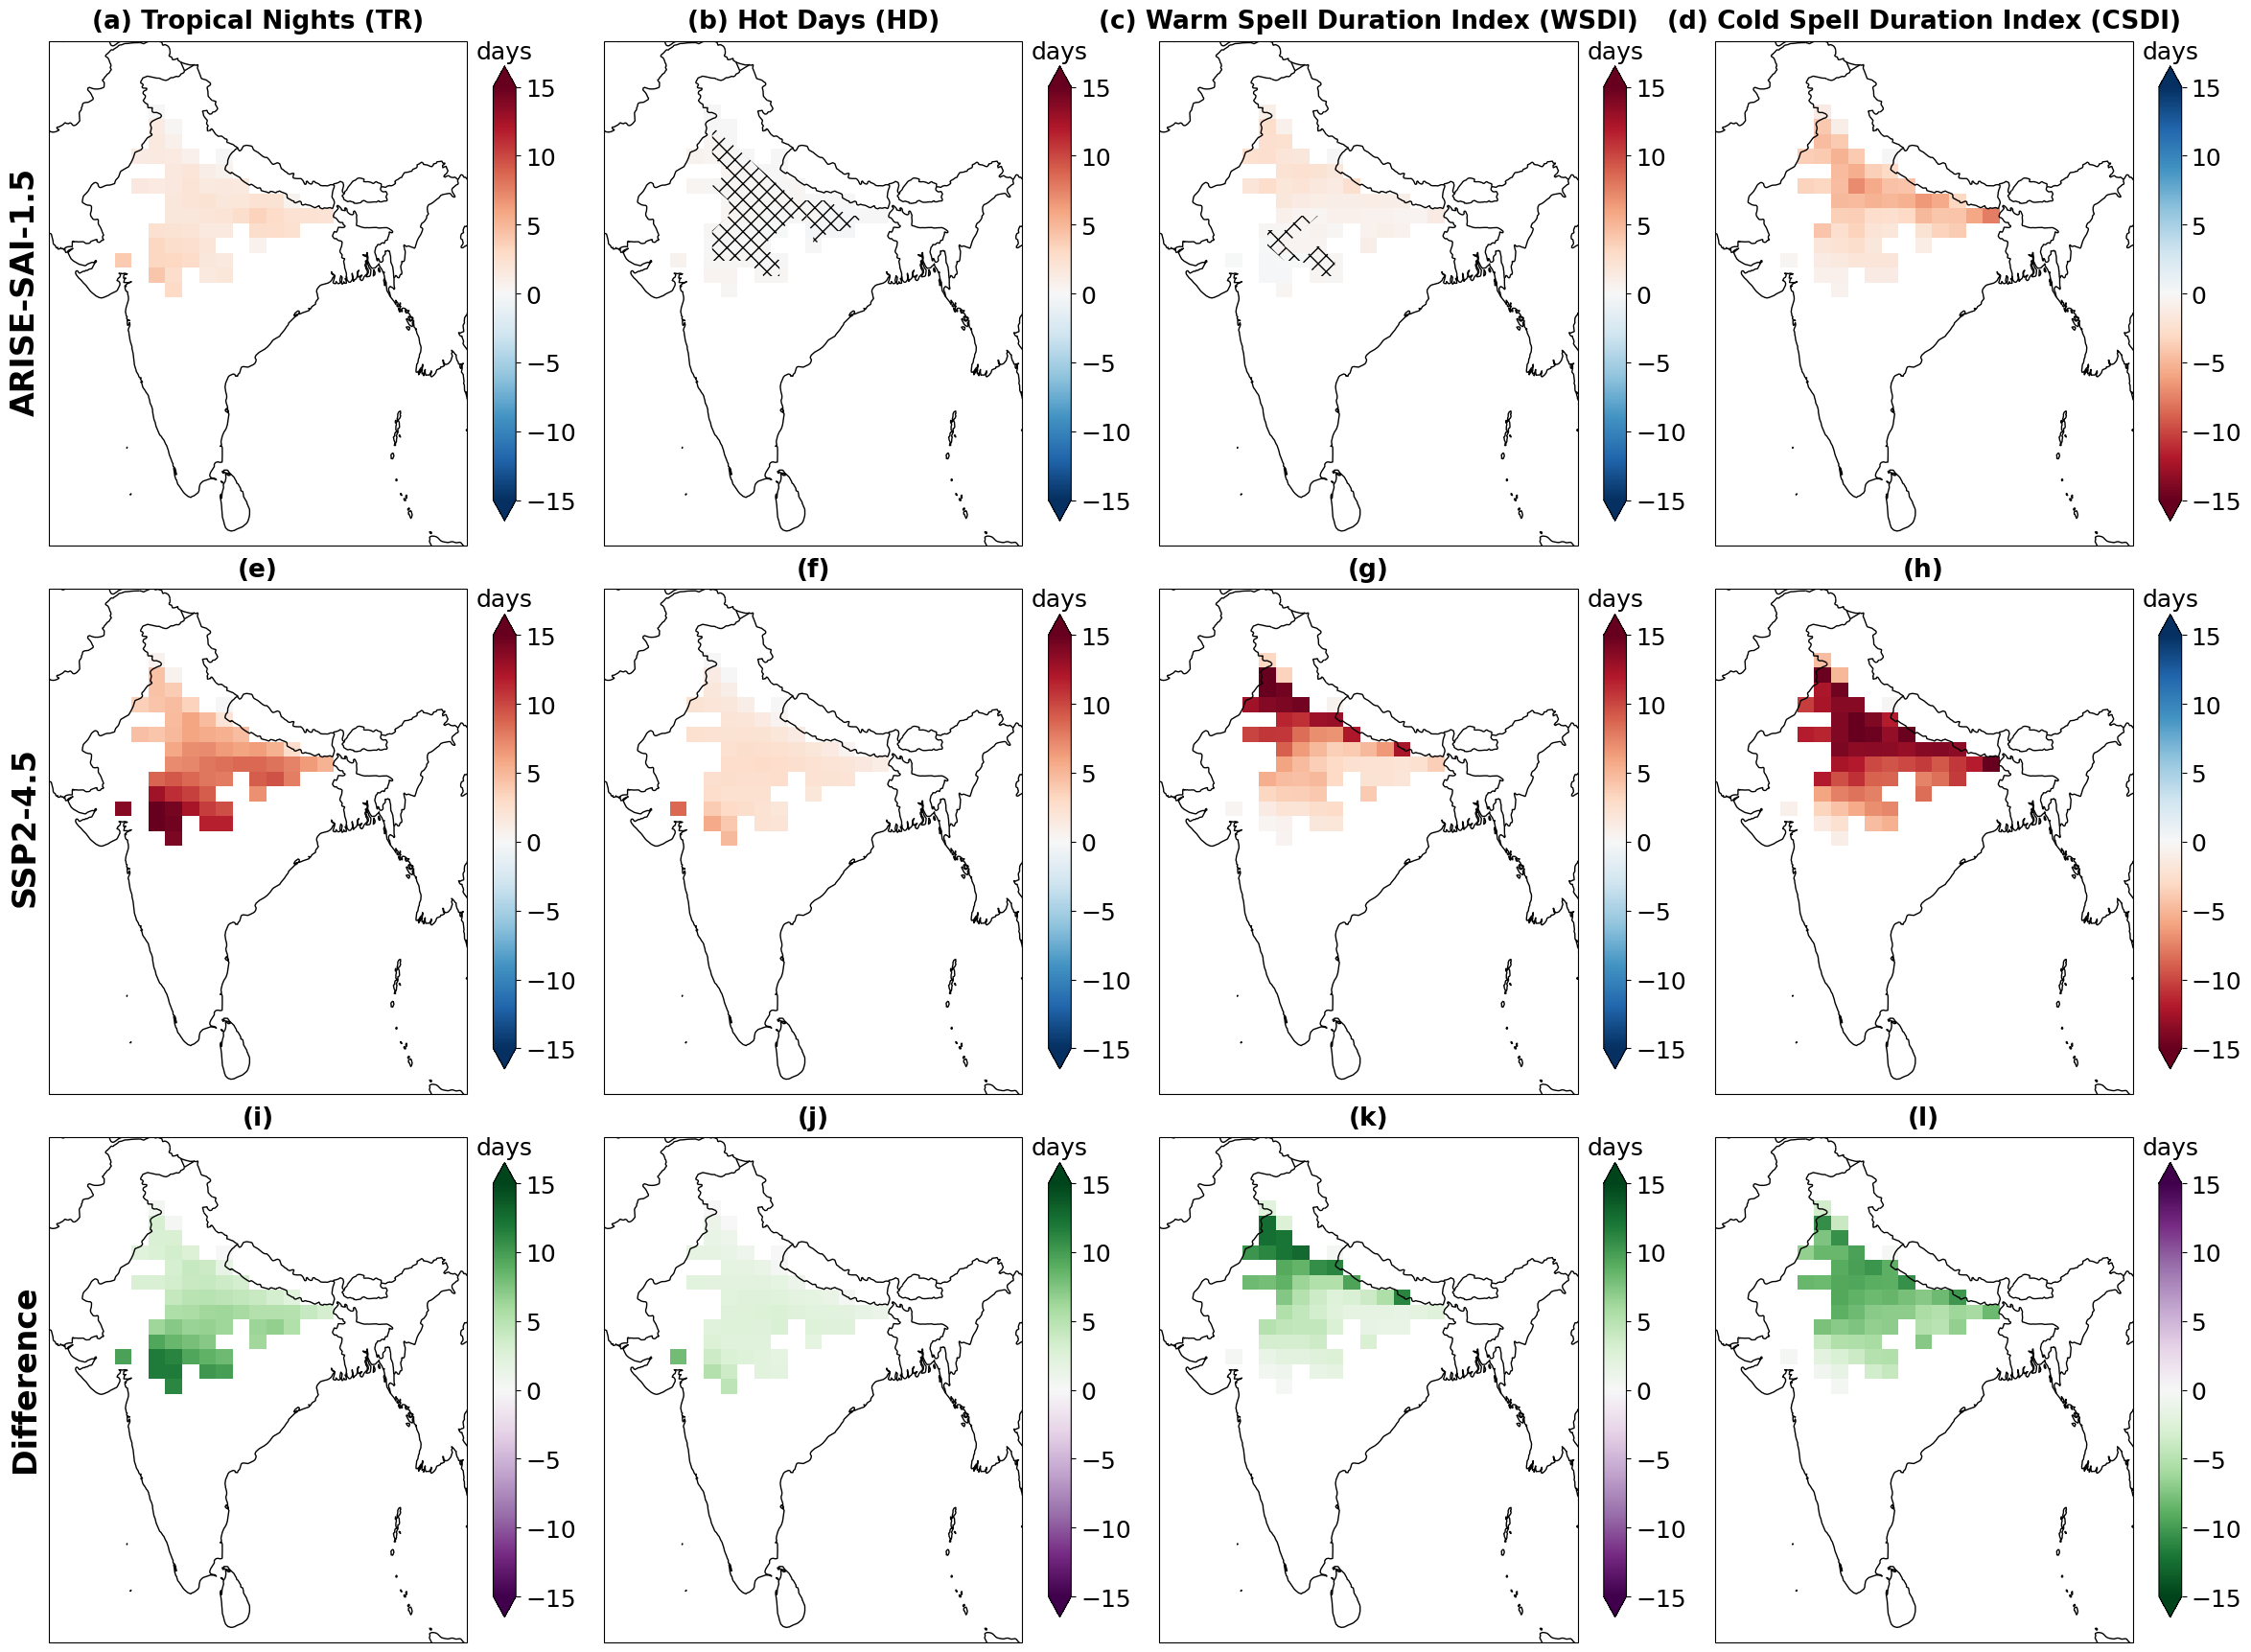

In [34]:
# Create a single 3-row figure
fig, axes = plt.subplots(3, 4, figsize=(24, 18), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles and color maps for each row
titles_row1 = ['(a) Tropical Nights (TR)', '(b) Hot Days (HD)', 
               '(c) Warm Spell Duration Index (WSDI)', 
               '(d) Cold Spell Duration Index (CSDI)', 
               '(e)', '(f)', '(g)', '(h)']
titles_row3 = ['(i)', '(j)', '(k)', '(l)']

vmin, vmax = -15, 15

# Plot the first 8 subplots for rows 1 and 2
for i, (ax, key) in enumerate(zip(axes.flatten()[:8], freq_T_indices_vegetative)):
    data = freq_T_indices_vegetative[key]
    control = ctrl_freq_T_indices_vegetative[key]
    vals = data - control
    cmap = 'RdBu' if i in [3, 7] else "RdBu_r"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    # Plot data and customize each subplot
    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row1[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)

    # Hatch insignificance within CI range
    ci_lo = ci_freq_T_vegetative[key].ci_lo
    ci_hi = ci_freq_T_vegetative[key].ci_hi
    ci = data.where((ci_lo < data) & (data < ci_hi))
    ci.plot.contourf(ax=ax, hatches=hatch_pattern, colors='none', extend='neither', add_colorbar=False, add_labels=False)

    # Add coastline and borders
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Plot the third row of 4 subplots showing `ssp - arise`
for i, (ax, item) in enumerate(zip(axes[2, :], freq_T_indices_vegetative.items())):
    arise = item[1]
    ssp = list(freq_T_indices_vegetative.values())[i + 4]
    vals = ssp - arise
    cmap = 'PRGn_r' if i in [3] else "PRGn"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row3[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Add text labels for each section
fig.text(0.01, 0.81, 'ARISE-SAI-1.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.5, 'SSP2-4.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.18, 'Difference', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')

plt.tight_layout(pad=3.5, h_pad=0.9, w_pad=1)

In [23]:
freq_T_indices_reproductive = {
    # 'ARISE Frost Days (FD)': map_averages(arise_tmin_indices_mean['FD'], 'reproductive'),
    'ARISE Tropical Nights (TR)': map_averages(arise_tmin_indices_mean['TR'], 'reproductive'),
    'ARISE Hot Days (HD)': map_averages(arise_tmax_indices_mean['HD34'], 'reproductive'),
    'ARISE Warm Spell Duration Index (WSDI)': map_averages(arise_tmax_indices_mean['WSDI'], 'reproductive'),
    'ARISE Cold Spell Duration Index (CSDI)': map_averages(arise_tmin_indices_mean['CSDI'], 'reproductive'),

    # 'SSP2-4.5 Frost Days (FD)': map_averages(ssp_tmin_indices_mean['FD'], 'reproductive'),
    'SSP2-4.5 Tropical Nights (TR)': map_averages(ssp_tmin_indices_mean['TR'], 'reproductive'),
    'SSP2-4.5 Hot Days (HD)': map_averages(ssp_tmax_indices_mean['HD34'], 'reproductive'),
    'SSP2-4.5 Warm Spell Duration Index (WSDI)': map_averages(ssp_tmax_indices_mean['WSDI'], 'reproductive'),
    'SSP2-4.5 Cold Spell Duration Index (CSDI)': map_averages(ssp_tmin_indices_mean['CSDI'], 'reproductive'),
}

ctrl_freq_T_indices_reproductive = {
    # 'ARISE Frost Days (FD)': map_averages(ctrl_tmin_indices_mean['FD'], 'reproductive'),
    'ARISE Tropical Nights (TR)': map_averages(ctrl_tmin_indices_mean['TR'], 'reproductive'),
    'ARISE Hot Days (HD)': map_averages(ctrl_tmax_indices_mean['HD34'], 'reproductive'),
    'ARISE Warm Spell Duration Index (WSDI)': map_averages(ctrl_tmax_indices_mean['WSDI'], 'reproductive'),
    'ARISE Cold Spell Duration Index (CSDI)': map_averages(ctrl_tmin_indices_mean['CSDI'], 'reproductive'),

    # 'SSP2-4.5 Frost Days (FD)': map_averages(ctrl_tmin_indices_mean['FD'], 'reproductive'),
    'SSP2-4.5 Tropical Nights (TR)': map_averages(ctrl_tmin_indices_mean['TR'], 'reproductive'),
    'SSP2-4.5 Hot Days (HD)': map_averages(ctrl_tmax_indices_mean['HD34'], 'reproductive'),
    'SSP2-4.5 Warm Spell Duration Index (WSDI)': map_averages(ctrl_tmax_indices_mean['WSDI'], 'reproductive'),
    'SSP2-4.5 Cold Spell Duration Index (CSDI)': map_averages(ctrl_tmin_indices_mean['CSDI'], 'reproductive'),
}

In [24]:
ci_freq_T_reproductive = {}
with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_TR_reproductive.pkl', 'rb') as file:
    ci_freq_T_reproductive['ARISE Tropical Nights (TR)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_reproductive['SSP2-4.5 Tropical Nights (TR)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_HD_reproductive.pkl', 'rb') as file:
    ci_freq_T_reproductive['ARISE Hot Days (HD)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_reproductive['SSP2-4.5 Hot Days (HD)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_WSDI_reproductive.pkl', 'rb') as file:
    ci_freq_T_reproductive['ARISE Warm Spell Duration Index (WSDI)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_reproductive['SSP2-4.5 Warm Spell Duration Index (WSDI)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_CSDI_reproductive.pkl', 'rb') as file:
    ci_freq_T_reproductive['ARISE Cold Spell Duration Index (CSDI)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_reproductive['SSP2-4.5 Cold Spell Duration Index (CSDI)'] = pickle.load(file)

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


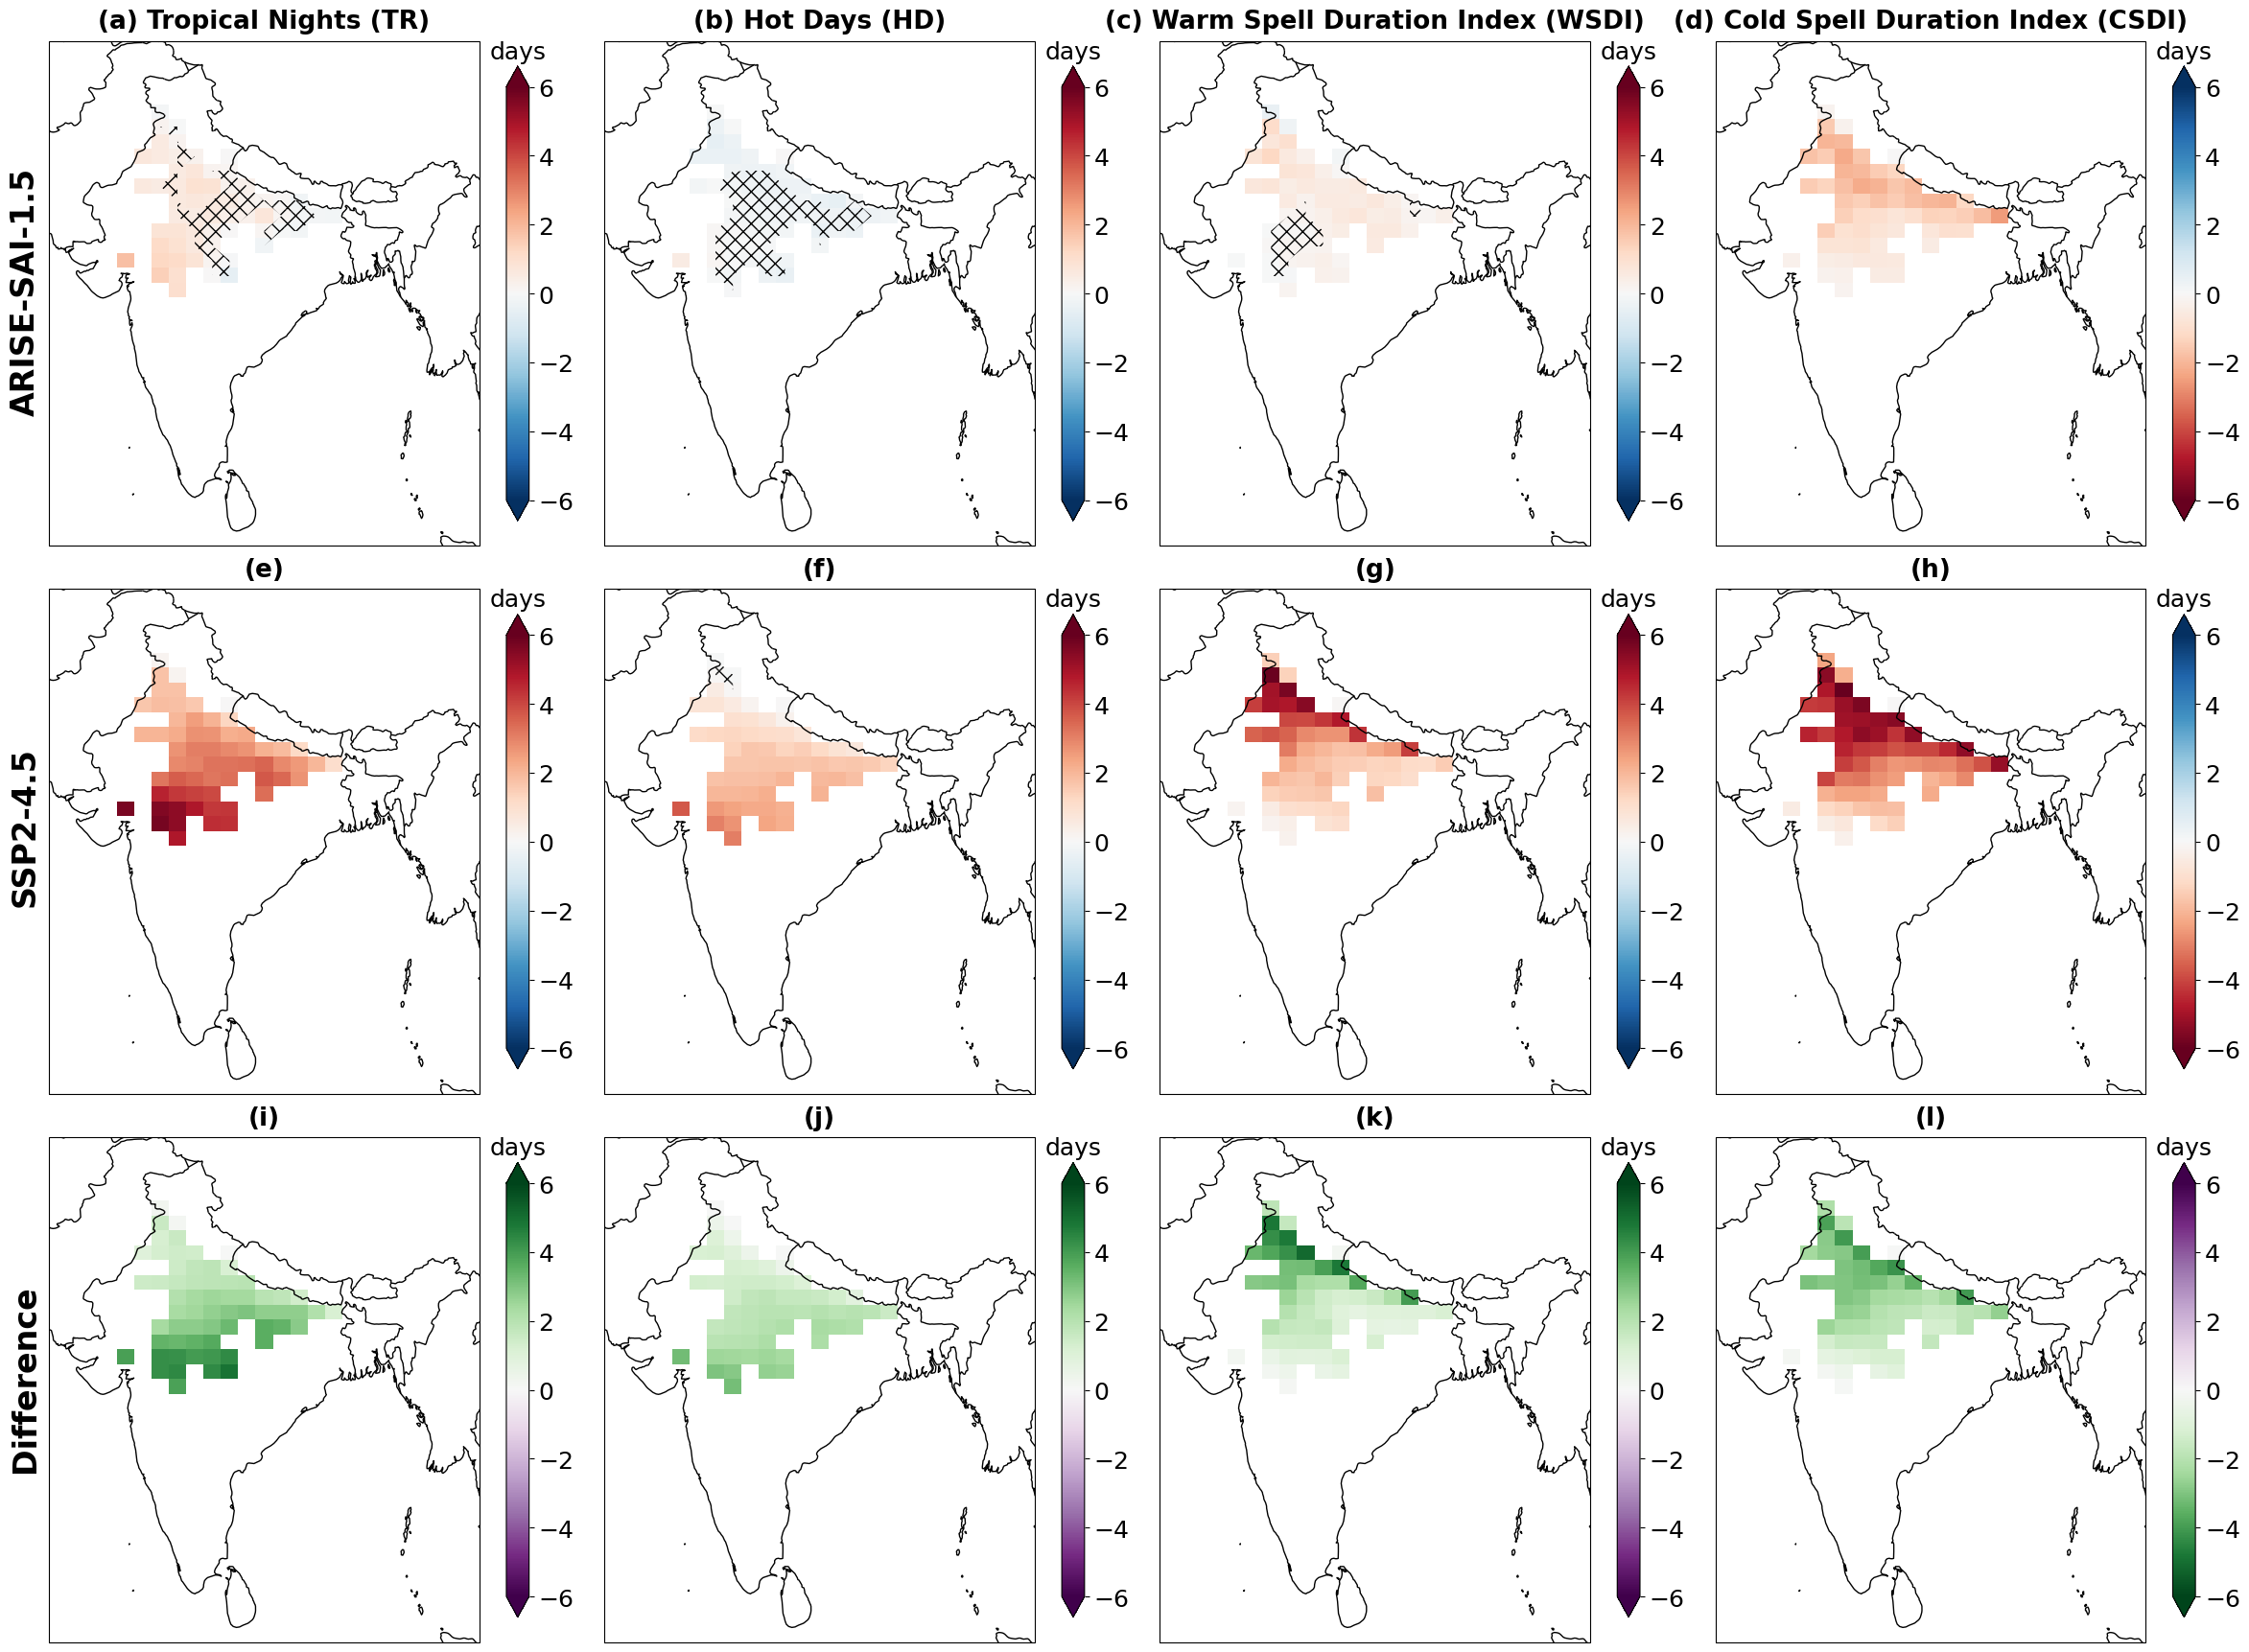

In [35]:
# Create a single 3-row figure
fig, axes = plt.subplots(3, 4, figsize=(24, 18), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles and color maps for each row
titles_row1 = ['(a) Tropical Nights (TR)', '(b) Hot Days (HD)', 
               '(c) Warm Spell Duration Index (WSDI)', 
               '(d) Cold Spell Duration Index (CSDI)', 
               '(e)', '(f)', '(g)', '(h)']
titles_row3 = ['(i)', '(j)', '(k)', '(l)']

vmin, vmax = -6, 6

# Plot the first 8 subplots for rows 1 and 2
for i, (ax, key) in enumerate(zip(axes.flatten()[:8], freq_T_indices_reproductive)):
    data = freq_T_indices_reproductive[key]
    control = ctrl_freq_T_indices_reproductive[key]
    vals = data - control
    cmap = 'RdBu' if i in [3, 7] else "RdBu_r"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    # Plot data and customize each subplot
    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row1[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)

    # Hatch insignificance within CI range
    ci_lo = ci_freq_T_reproductive[key].ci_lo
    ci_hi = ci_freq_T_reproductive[key].ci_hi
    ci = data.where((ci_lo < data) & (data < ci_hi))
    ci.plot.contourf(ax=ax, hatches=hatch_pattern, colors='none', extend='neither', add_colorbar=False, add_labels=False)

    # Add coastline and borders
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Plot the third row of 4 subplots showing `ssp - arise`
for i, (ax, item) in enumerate(zip(axes[2, :], freq_T_indices_reproductive.items())):
    arise = item[1]
    ssp = list(freq_T_indices_reproductive.values())[i + 4]
    vals = ssp - arise
    cmap = 'PRGn_r' if i in [3] else "PRGn"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row3[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Add text labels for each section
fig.text(0.01, 0.81, 'ARISE-SAI-1.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.5, 'SSP2-4.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.18, 'Difference', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')

plt.tight_layout(pad=3.5, h_pad=0.9, w_pad=1)

In [25]:
freq_T_indices_ripening = {
    # 'ARISE Frost Days (FD)': map_averages(arise_tmin_indices_mean['FD'], 'ripening'),
    'ARISE Tropical Nights (TR)': map_averages(arise_tmin_indices_mean['TR'], 'ripening'),
    'ARISE Hot Days (HD)': map_averages(arise_tmax_indices_mean['HD34'], 'ripening'),
    'ARISE Warm Spell Duration Index (WSDI)': map_averages(arise_tmax_indices_mean['WSDI'], 'ripening'),
    'ARISE Cold Spell Duration Index (CSDI)': map_averages(arise_tmin_indices_mean['CSDI'], 'ripening'),

    # 'SSP2-4.5 Frost Days (FD)': map_averages(ssp_tmin_indices_mean['FD'], 'ripening'),
    'SSP2-4.5 Tropical Nights (TR)': map_averages(ssp_tmin_indices_mean['TR'], 'ripening'),
    'SSP2-4.5 Hot Days (HD)': map_averages(ssp_tmax_indices_mean['HD34'], 'ripening'),
    'SSP2-4.5 Warm Spell Duration Index (WSDI)': map_averages(ssp_tmax_indices_mean['WSDI'], 'ripening'),
    'SSP2-4.5 Cold Spell Duration Index (CSDI)': map_averages(ssp_tmin_indices_mean['CSDI'], 'ripening'),
}

ctrl_freq_T_indices_ripening = {
    # 'ARISE Frost Days (FD)': map_averages(ctrl_tmin_indices_mean['FD'], 'ripening'),
    'ARISE Tropical Nights (TR)': map_averages(ctrl_tmin_indices_mean['TR'], 'ripening'),
    'ARISE Hot Days (HD)': map_averages(ctrl_tmax_indices_mean['HD34'], 'ripening'),
    'ARISE Warm Spell Duration Index (WSDI)': map_averages(ctrl_tmax_indices_mean['WSDI'], 'ripening'),
    'ARISE Cold Spell Duration Index (CSDI)': map_averages(ctrl_tmin_indices_mean['CSDI'], 'ripening'),

    # 'SSP2-4.5 Frost Days (FD)': map_averages(ctrl_tmin_indices_mean['FD'], 'ripening'),
    'SSP2-4.5 Tropical Nights (TR)': map_averages(ctrl_tmin_indices_mean['TR'], 'ripening'),
    'SSP2-4.5 Hot Days (HD)': map_averages(ctrl_tmax_indices_mean['HD34'], 'ripening'),
    'SSP2-4.5 Warm Spell Duration Index (WSDI)': map_averages(ctrl_tmax_indices_mean['WSDI'], 'ripening'),
    'SSP2-4.5 Cold Spell Duration Index (CSDI)': map_averages(ctrl_tmin_indices_mean['CSDI'], 'ripening'),
}

In [26]:
ci_freq_T_ripening = {}
with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_TR_ripening.pkl', 'rb') as file:
    ci_freq_T_ripening['ARISE Tropical Nights (TR)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_ripening['SSP2-4.5 Tropical Nights (TR)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_HD_ripening.pkl', 'rb') as file:
    ci_freq_T_ripening['ARISE Hot Days (HD)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_ripening['SSP2-4.5 Hot Days (HD)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_WSDI_ripening.pkl', 'rb') as file:
    ci_freq_T_ripening['ARISE Warm Spell Duration Index (WSDI)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_ripening['SSP2-4.5 Warm Spell Duration Index (WSDI)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_CSDI_ripening.pkl', 'rb') as file:
    ci_freq_T_ripening['ARISE Cold Spell Duration Index (CSDI)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_freq_T_ripening['SSP2-4.5 Cold Spell Duration Index (CSDI)'] = pickle.load(file)

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


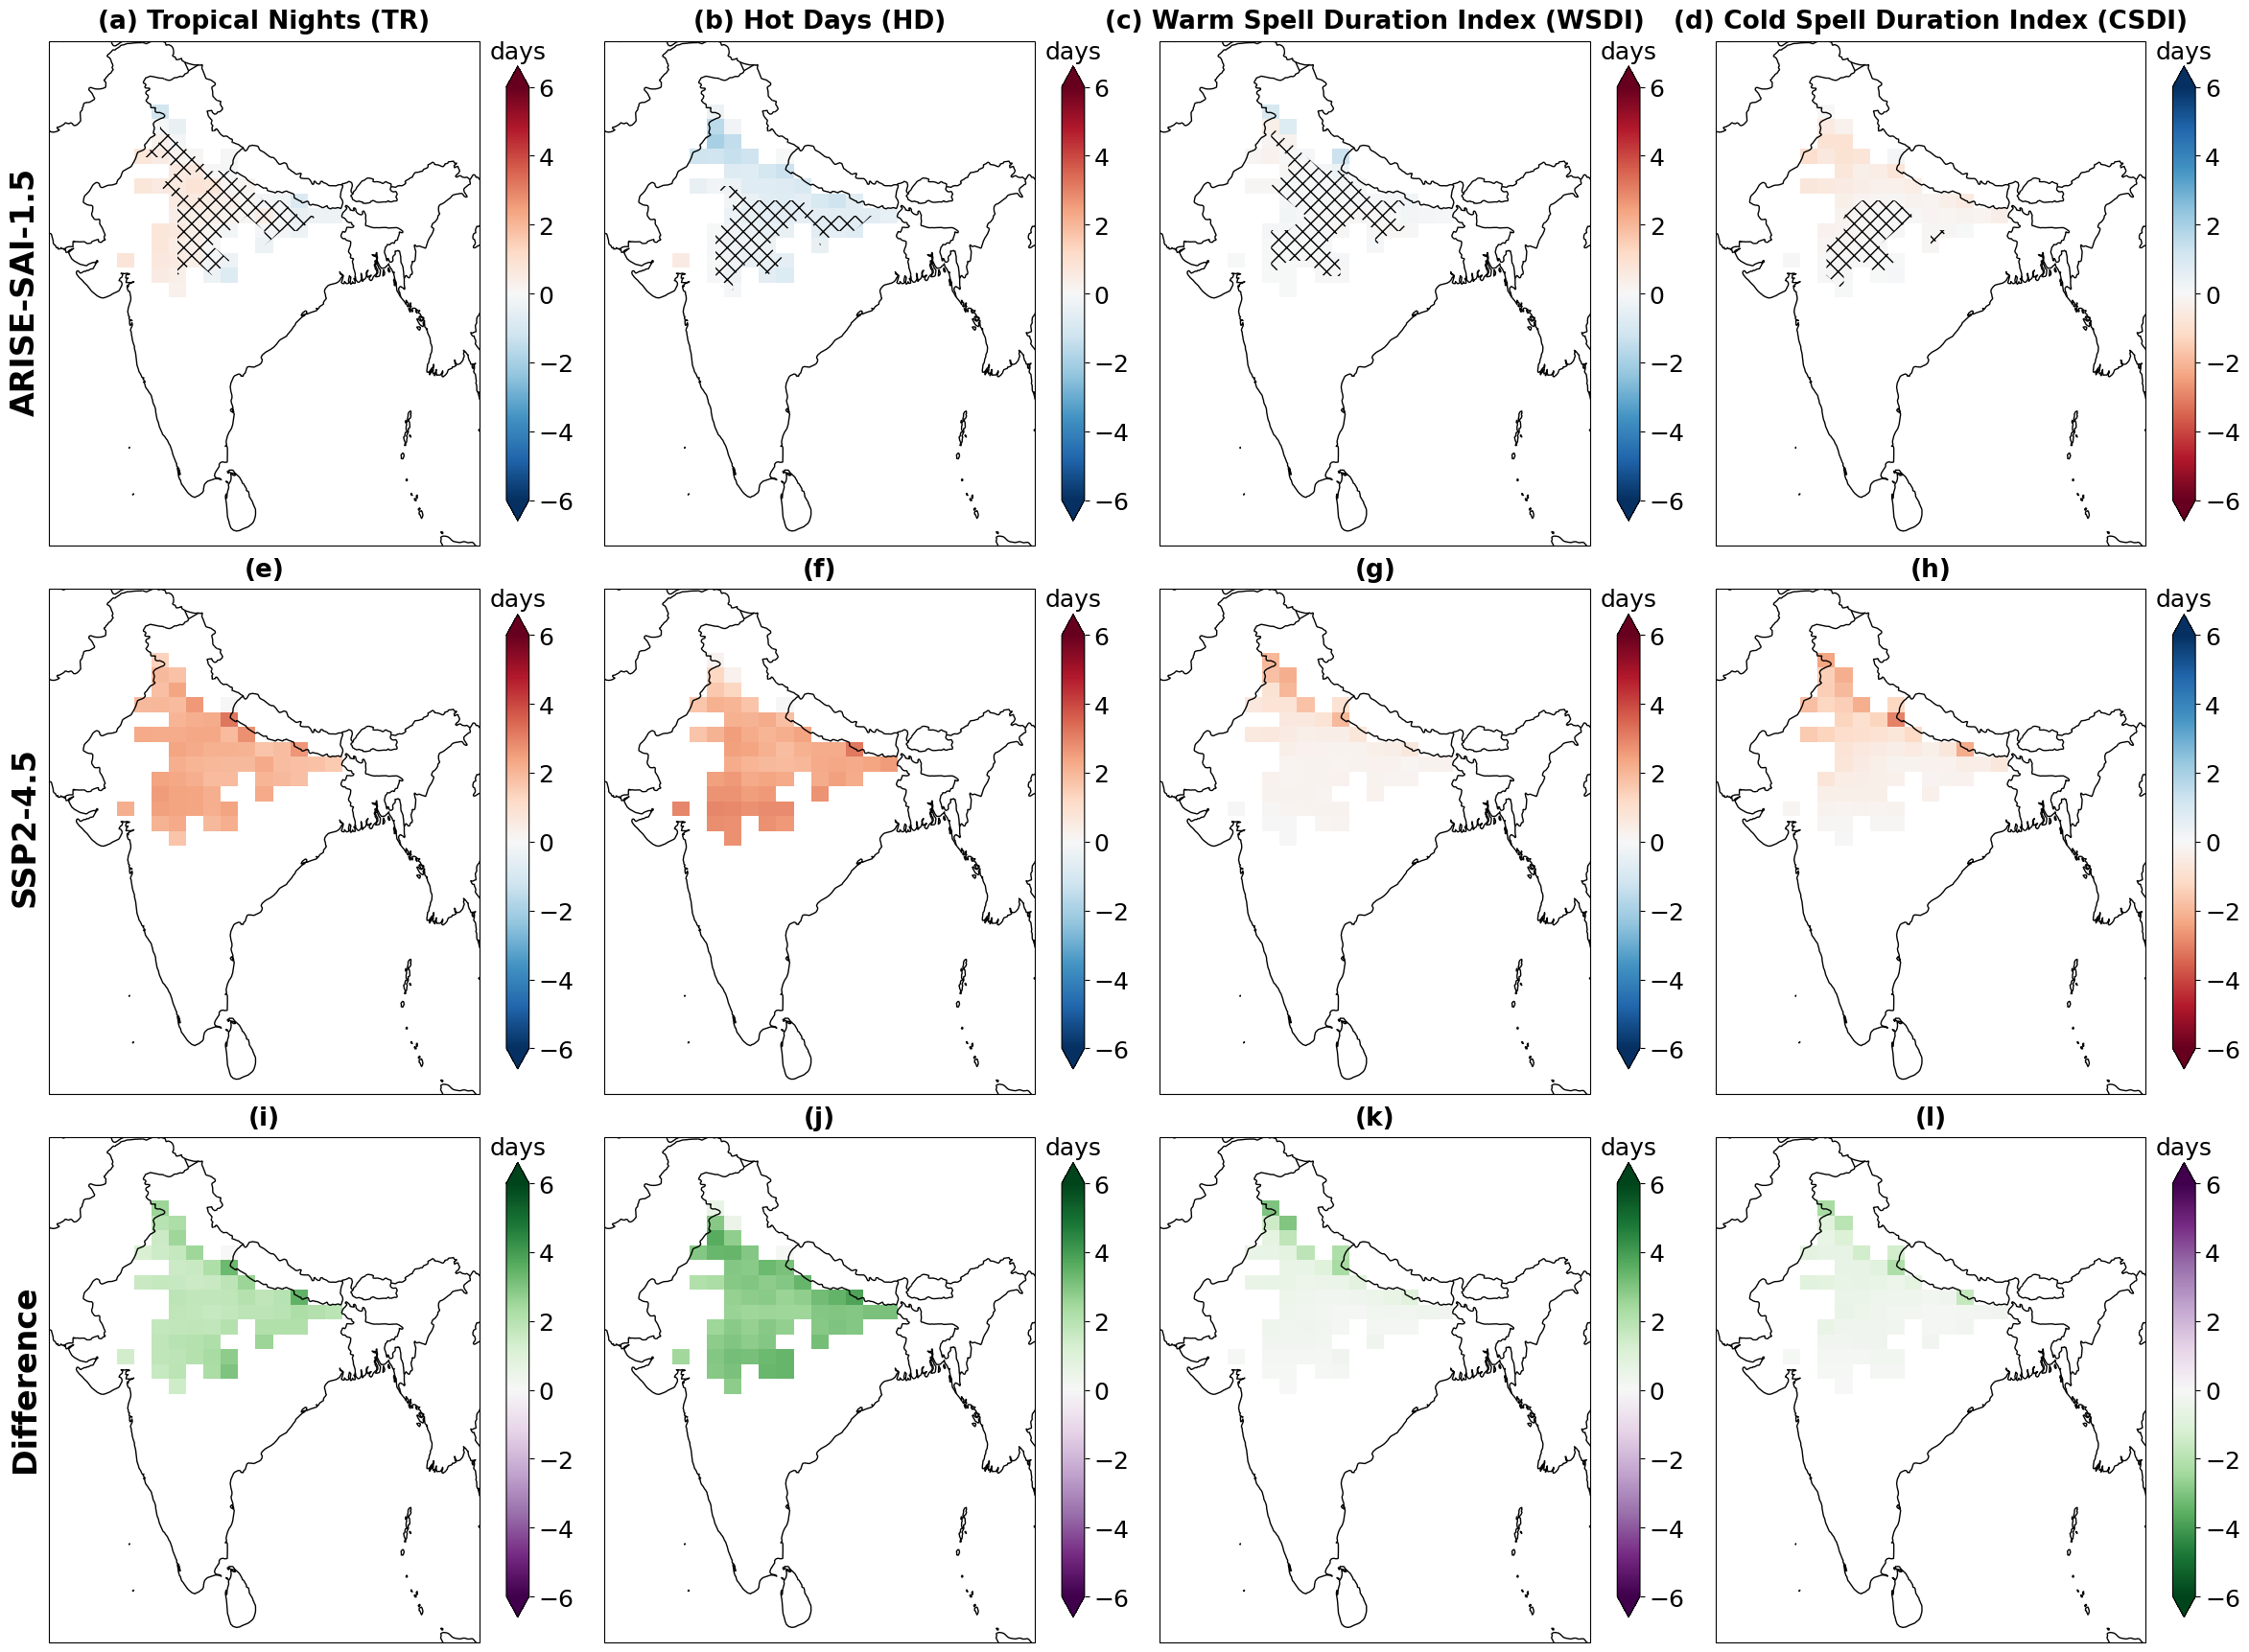

In [36]:
# Create a single 3-row figure
fig, axes = plt.subplots(3, 4, figsize=(24, 18), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles and color maps for each row
titles_row1 = ['(a) Tropical Nights (TR)', '(b) Hot Days (HD)', 
               '(c) Warm Spell Duration Index (WSDI)', 
               '(d) Cold Spell Duration Index (CSDI)', 
               '(e)', '(f)', '(g)', '(h)']
titles_row3 = ['(i)', '(j)', '(k)', '(l)']

vmin, vmax = -6, 6

# Plot the first 8 subplots for rows 1 and 2
for i, (ax, key) in enumerate(zip(axes.flatten()[:8], freq_T_indices_ripening)):
    data = freq_T_indices_ripening[key]
    control = ctrl_freq_T_indices_ripening[key]
    vals = data - control
    cmap = 'RdBu' if i in [3, 7] else "RdBu_r"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    # Plot data and customize each subplot
    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row1[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)

    # Hatch insignificance within CI range
    ci_lo = ci_freq_T_ripening[key].ci_lo
    ci_hi = ci_freq_T_ripening[key].ci_hi
    ci = data.where((ci_lo < data) & (data < ci_hi))
    ci.plot.contourf(ax=ax, hatches=hatch_pattern, colors='none', extend='neither', add_colorbar=False, add_labels=False)

    # Add coastline and borders
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Plot the third row of 4 subplots showing `ssp - arise`
for i, (ax, item) in enumerate(zip(axes[2, :], freq_T_indices_ripening.items())):
    arise = item[1]
    ssp = list(freq_T_indices_ripening.values())[i + 4]
    vals = ssp - arise
    cmap = 'PRGn_r' if i in [3] else "PRGn"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row3[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Add text labels for each section
fig.text(0.01, 0.81, 'ARISE-SAI-1.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.5, 'SSP2-4.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.18, 'Difference', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')

plt.tight_layout(pad=3.5, h_pad=0.9, w_pad=1)

### Precip Indices

In [27]:
precip_freq_indices_vegetative = {
    "ARISE-SAI-1.5 Dry Days (<R5mm)": map_averages(arise_prcp_indices_mean["R5mm"], 'vegetative'),
    "ARISE-SAI-1.5 Very Wet Days (R20mm)": map_averages(arise_prcp_indices_mean["R20mm"], 'vegetative'),
    "ARISE-SAI-1.5 Consecutive Wet Days (CWD)": map_averages(arise_prcp_indices_mean["CWD"], 'vegetative'),
    "ARISE-SAI-1.5 Consecutive Dry Days (CDD)": map_averages(arise_prcp_indices_mean["CDD"], 'vegetative'),
    
    "SSP2-4.5 Dry Days (<R5mm)": map_averages(ssp_prcp_indices_mean["R5mm"], 'vegetative'),
    "SSP2-4.5 Very Wet Days (R20mm)": map_averages(ssp_prcp_indices_mean["R20mm"], 'vegetative'),
    "SSP2-4.5 Consecutive Wet Days (CWD)": map_averages(ssp_prcp_indices_mean["CWD"], 'vegetative'),
    "SSP2-4.5 Consecutive Dry Days (CDD)": map_averages(ssp_prcp_indices_mean["CDD"], 'vegetative'),
}

ctrl_prcp_freq_indices_vegetative = {
    "ARISE-SAI-1.5 Dry Days (<R5mm)": map_averages(ctrl_prcp_indices_mean["R5mm"], 'vegetative'),
    "ARISE-SAI-1.5 Very Wet Days (R20mm)": map_averages(ctrl_prcp_indices_mean["R20mm"], 'vegetative'),
    "ARISE-SAI-1.5 Consecutive Wet Days (CWD)": map_averages(ctrl_prcp_indices_mean["CWD"], 'vegetative'),
    "ARISE-SAI-1.5 Consecutive Dry Days (CDD)": map_averages(ctrl_prcp_indices_mean["CDD"], 'vegetative'),
    
    "SSP2-4.5 Dry Days (<R5mm)": map_averages(ctrl_prcp_indices_mean["R5mm"], 'vegetative'),
    "SSP2-4.5 Very Wet Days (R20mm)": map_averages(ctrl_prcp_indices_mean["R20mm"], 'vegetative'),
    "SSP2-4.5 Consecutive Wet Days (CWD)": map_averages(ctrl_prcp_indices_mean["CWD"], 'vegetative'),
    "SSP2-4.5 Consecutive Dry Days (CDD)": map_averages(ctrl_prcp_indices_mean["CDD"], 'vegetative'),
}

In [28]:
precip_amt_indices_vegetative = {
    "ARISE-SAI-1.5 Wettest Pentad (Rx5day)": map_averages(arise_prcp_indices_mean["Rx5day"], 'vegetative'),
    "ARISE-SAI-1.5 Total Precipitation (PRECTOT)": map_averages(arise_prcp_indices_mean["PRECTOT"], 'vegetative'),

    "SSP2-4.5 Wettest Pentad (Rx5day)": map_averages(ssp_prcp_indices_mean["Rx5day"], 'vegetative'),
    "SSP2-4.5 Total Precipitation (PRECTOT)": map_averages(ssp_prcp_indices_mean["PRECTOT"], 'vegetative'),
}

ctrl_prcp_amt_indices_vegetative = {
    "ARISE-SAI-1.5 Wettest Pentad (Rx5day)": map_averages(ctrl_prcp_indices_mean["Rx5day"], 'vegetative'),
    "ARISE-SAI-1.5 Total Precipitation (PRECTOT)": map_averages(ctrl_prcp_indices_mean["PRECTOT"], 'vegetative'),

    "SSP2-4.5 Wettest Pentad (Rx5day)": map_averages(ctrl_prcp_indices_mean["Rx5day"], 'vegetative'),
    "SSP2-4.5 Total Precipitation (PRECTOT)": map_averages(ctrl_prcp_indices_mean["PRECTOT"], 'vegetative'),
}

In [29]:
ci_prcp_freq_vegetative = {}
with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_R5mm_vegetative.pkl', 'rb') as file:
    ci_prcp_freq_vegetative['ARISE-SAI-1.5 Dry Days (<R5mm)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_vegetative['SSP2-4.5 Dry Days (<R5mm)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_R20mm_vegetative.pkl', 'rb') as file:
    ci_prcp_freq_vegetative['ARISE-SAI-1.5 Very Wet Days (R20mm)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_vegetative['SSP2-4.5 Very Wet Days (R20mm)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_CWD_vegetative.pkl', 'rb') as file:
    ci_prcp_freq_vegetative['ARISE-SAI-1.5 Consecutive Wet Days (CWD)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_vegetative['SSP2-4.5 Consecutive Wet Days (CWD)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_CDD_vegetative.pkl', 'rb') as file:
    ci_prcp_freq_vegetative['ARISE-SAI-1.5 Consecutive Dry Days (CDD)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_vegetative['SSP2-4.5 Consecutive Dry Days (CDD)'] = pickle.load(file)

ci_prcp_amt_vegetative = {}
with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_Rx5day_vegetative.pkl', 'rb') as file:
    ci_prcp_amt_vegetative['ARISE-SAI-1.5 Wettest Pentad (Rx5day)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_amt_vegetative['SSP2-4.5 Wettest Pentad (Rx5day)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_PRECTOT_vegetative.pkl', 'rb') as file:
    ci_prcp_amt_vegetative['ARISE-SAI-1.5 Total Precipitation (PRECTOT)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_amt_vegetative['SSP2-4.5 Total Precipitation (PRECTOT)'] = pickle.load(file)


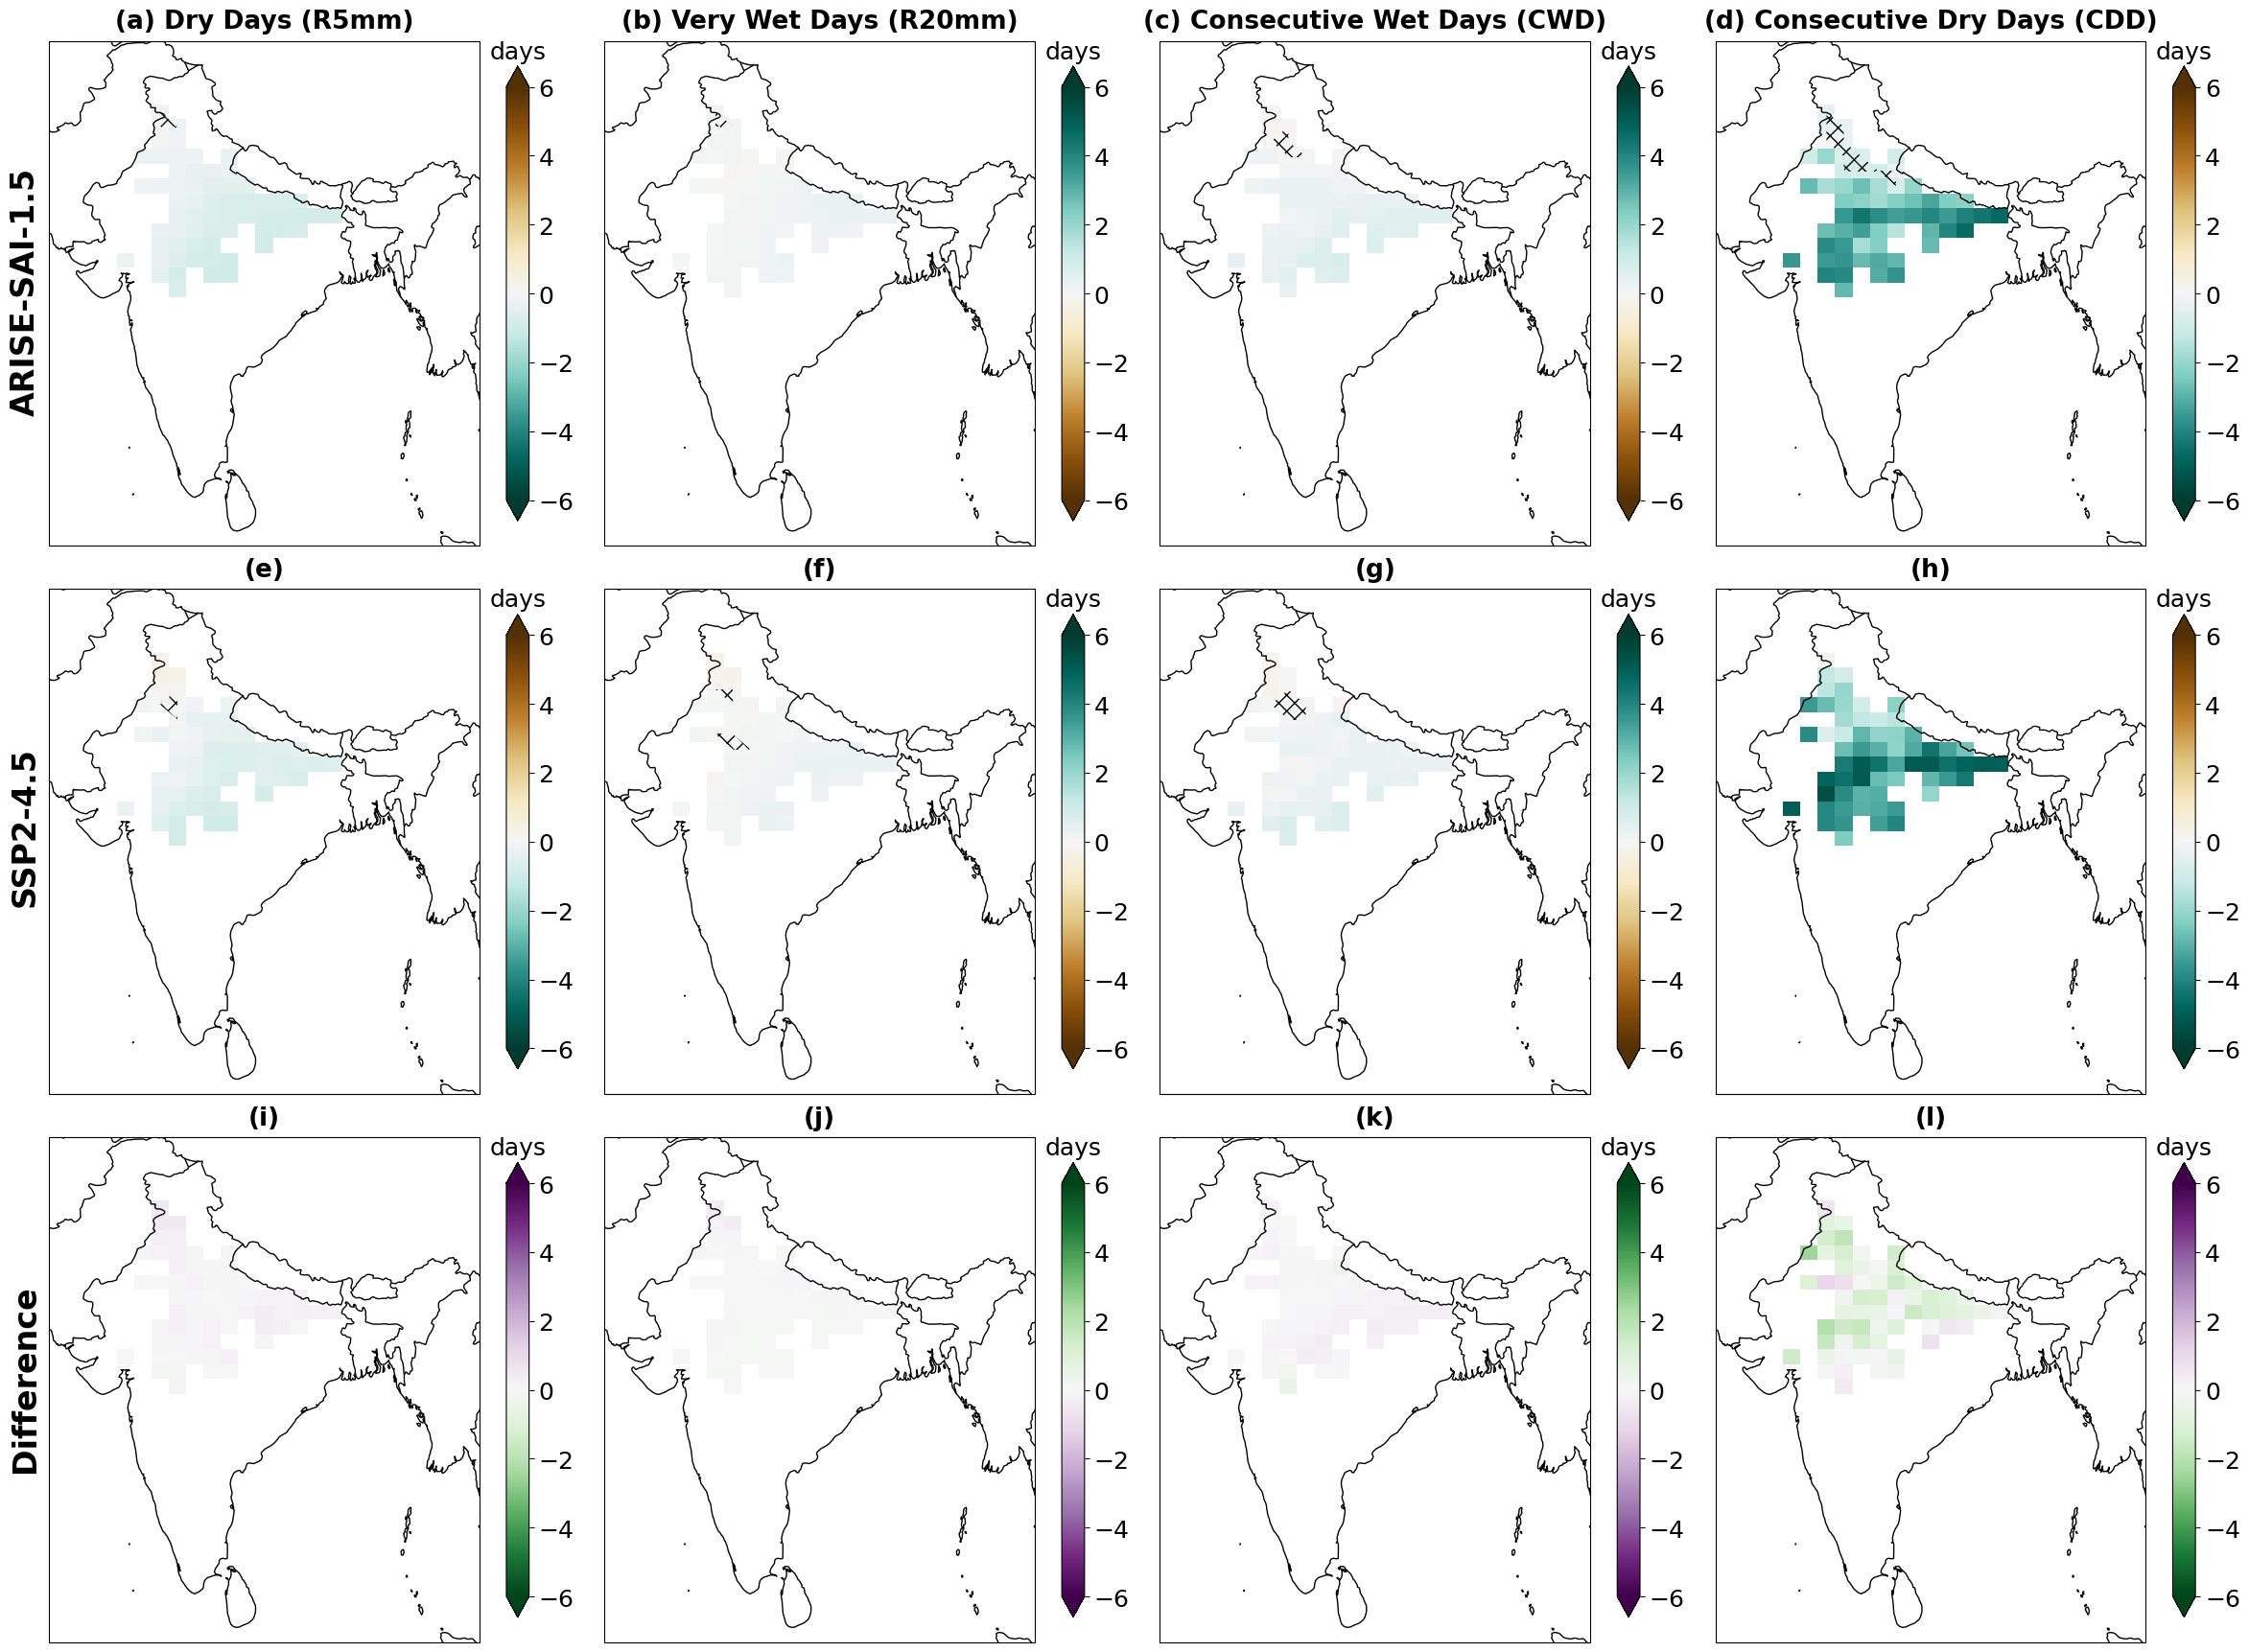

In [37]:
# Create a single 3-row figure
fig, axes = plt.subplots(3, 4, figsize=(24, 18), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles and color maps for each row
titles_row1 = ['(a) Dry Days (R5mm)', '(b) Very Wet Days (R20mm)',
               '(c) Consecutive Wet Days (CWD)',
               '(d) Consecutive Dry Days (CDD)',
               '(e)', '(f)', '(g)', '(h)']
titles_row3 = ['(i)', '(j)', '(k)', '(l)']

vmin, vmax = -6, 6

# Plot the first 8 subplots for rows 1 and 2
for i, (ax, key) in enumerate(zip(axes.flatten()[:8], precip_freq_indices_vegetative)):
    data = precip_freq_indices_vegetative[key]
    control = ctrl_prcp_freq_indices_vegetative[key]
    vals = data - control
    cmap = 'BrBG_r' if i in [0, 3, 4, 7] else "BrBG"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    # Plot data and customize each subplot
    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row1[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)

    # Hatch insignificance within CI range
    ci_lo = ci_prcp_freq_vegetative[key].ci_lo
    ci_hi = ci_prcp_freq_vegetative[key].ci_hi
    ci = data.where((ci_lo < data) & (data < ci_hi))
    ci.plot.contourf(ax=ax, hatches=hatch_pattern, colors='none', extend='neither', add_colorbar=False, add_labels=False)

    # Add coastline and borders
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Plot the third row of 4 subplots showing `ssp - arise`
for i, (ax, item) in enumerate(zip(axes[2, :], precip_freq_indices_vegetative.items())):
    arise = item[1]
    ssp = list(precip_freq_indices_vegetative.values())[i + 4]
    vals = ssp - arise
    cmap = 'PRGn_r' if i in [0, 3] else "PRGn"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row3[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Add text labels for each section
fig.text(0.01, 0.81, 'ARISE-SAI-1.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.5, 'SSP2-4.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.18, 'Difference', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')

plt.tight_layout(pad=3.5, h_pad=0.9, w_pad=1)

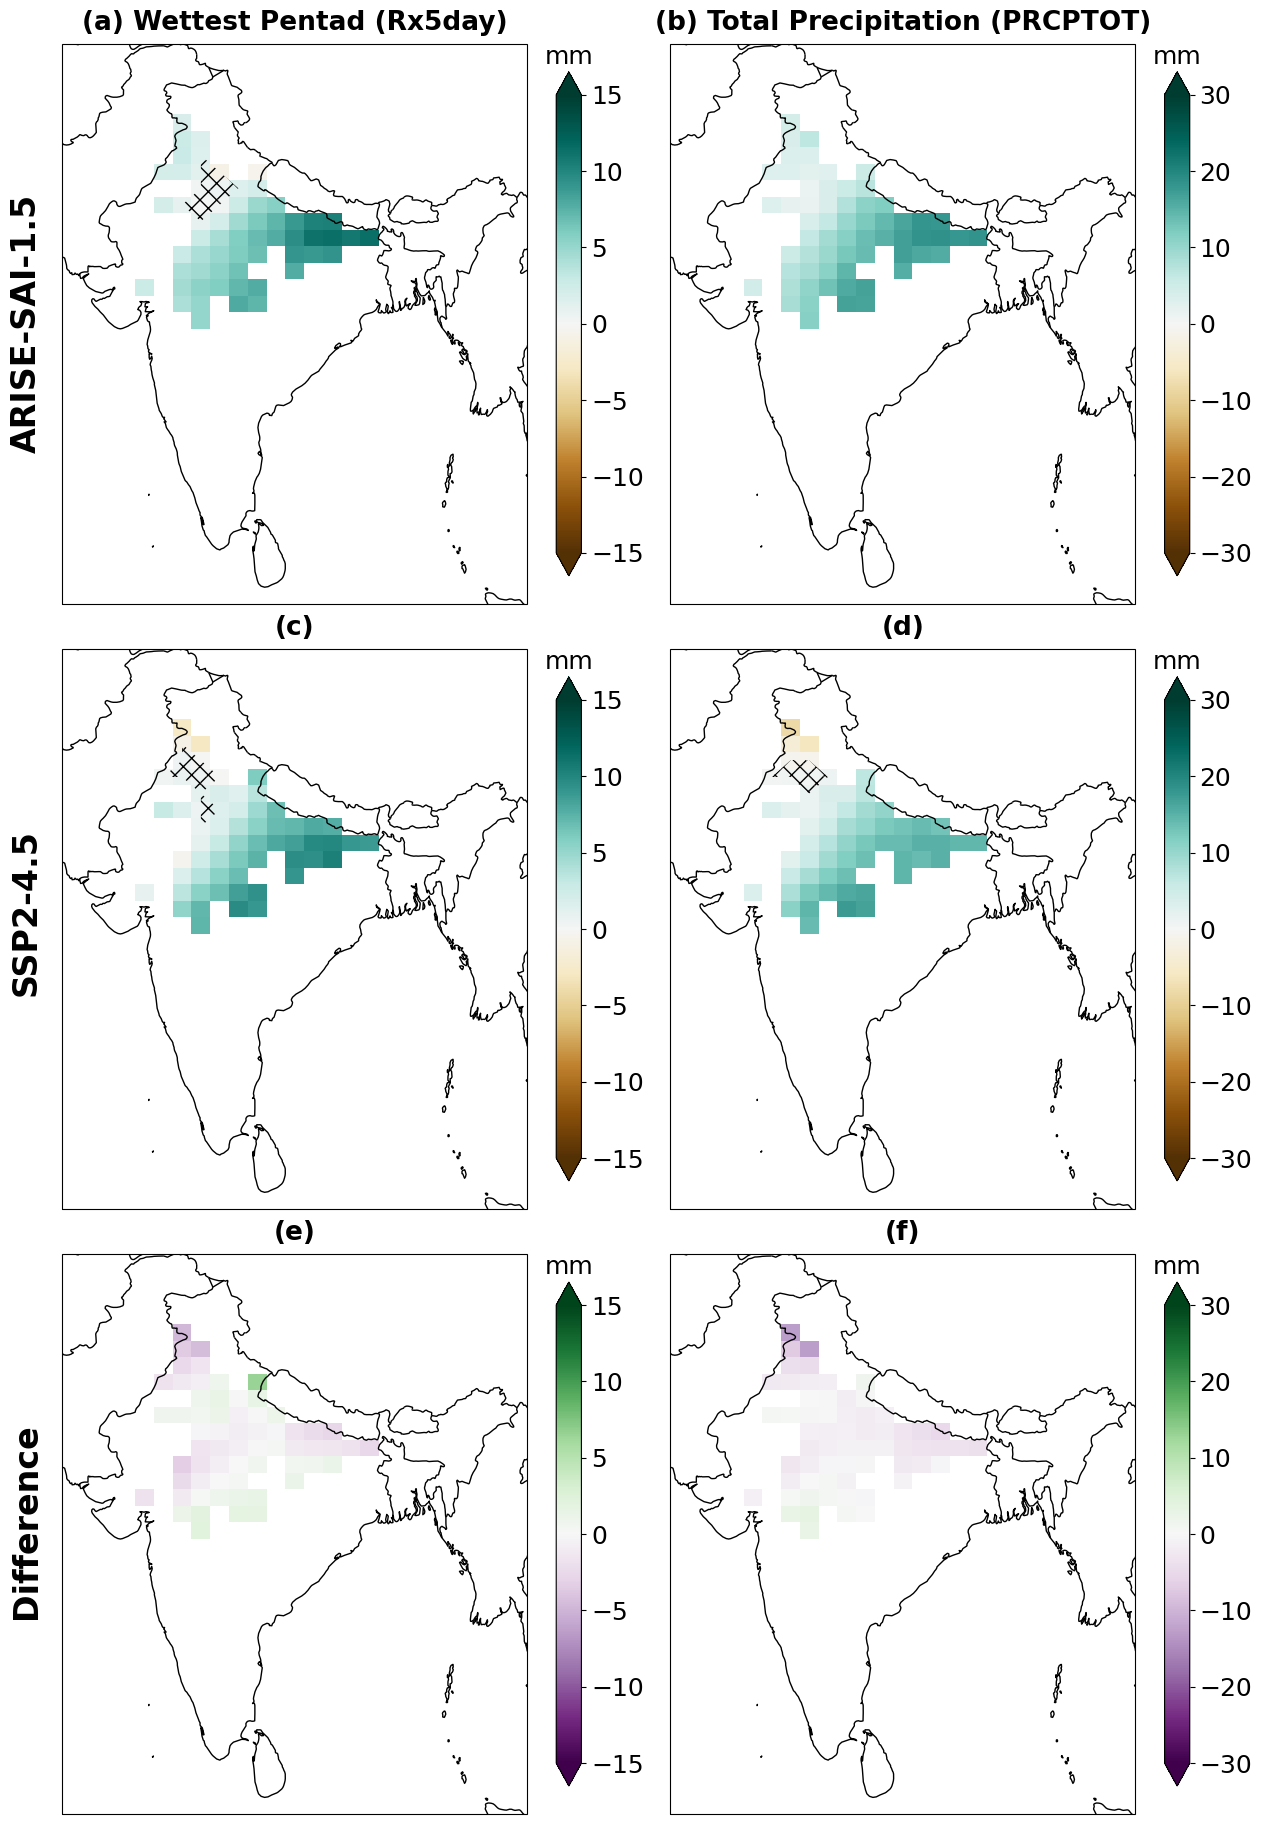

In [51]:
# create figure
fig, axes = plt.subplots(3, 2, figsize=(13, 19), subplot_kw={'projection': ccrs.PlateCarree()})

titles = ['(a) Wettest Pentad (Rx5day)',
          '(b) Total Precipitation (PRCPTOT)',
          '(c)','(d)']
titles_row3 = ['(e)', '(f)']

# average the ensemble members
for i, (ax, key) in enumerate(zip(axes.flatten()[:6], precip_amt_indices_vegetative)):
    data = precip_amt_indices_vegetative[key]
    control = ctrl_prcp_amt_indices_vegetative[key]
    vals = data - control
    
    vmin = -15 if i in [0, 2] else -30
    vmax = 15 if i in [0, 2] else 30
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
    cmap = "BrBG"

    map = vals.plot(ax=ax,
                    cmap=cmap,
                    norm=norm, 
                    vmin=vmin, vmax=vmax,
                    extend='both',
                    transform=ccrs.PlateCarree(),
                    add_colorbar=False,
                    add_labels=False,
                   )
    ci_lo = ci_prcp_amt_vegetative[key].ci_lo
    ci_hi = ci_prcp_amt_vegetative[key].ci_hi
    # hatch any statistical insignificance (within the control CI)
    ci = data.where((ci_lo < data) & (data < ci_hi))
    ci.plot.contourf(ax=ax, hatches=hatch_pattern, colors='none', extend='neither', add_colorbar=False)

    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('mm', fontsize=18)

    ax.set_title(titles[i], fontsize=19, fontweight='bold', y=1.01)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())

    # Adjust aspect ratio to stretch the map
    ax.set_aspect('auto', adjustable='box')

    # Remove grid lines and labels
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xlabel('')  # Remove x-axis ticks
    ax.set_ylabel('')  # Remove y-axis ticks

# Plot the third row of 3 subplots showing `ssp - arise`
for i, (ax, item) in enumerate(zip(axes[2, :], precip_amt_indices_vegetative.items())):
    arise = item[1]
    ssp = list(precip_amt_indices_vegetative.values())[i + 2]
    vals = ssp - arise
    cmap = "PRGn"
    vmin = -15 if i in [0, 2] else -30
    vmax = 15 if i in [0, 2] else 30
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row3[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('mm', fontsize=18)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Add text labels to the left side of the figure
fig.text(0.01, 0.81, 'ARISE-SAI-1.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.5, 'SSP2-4.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.18, 'Difference', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')

plt.tight_layout(pad=3.5, h_pad=0.9, w_pad=1)

In [30]:
precip_freq_indices_reproductive = {
    "ARISE-SAI-1.5 Dry Days (<R5mm)": map_averages(arise_prcp_indices_mean["R5mm"], 'reproductive'),
    "ARISE-SAI-1.5 Very Wet Days (R20mm)": map_averages(arise_prcp_indices_mean["R20mm"], 'reproductive'),
    "ARISE-SAI-1.5 Consecutive Wet Days (CWD)": map_averages(arise_prcp_indices_mean["CWD"], 'reproductive'),
    "ARISE-SAI-1.5 Consecutive Dry Days (CDD)": map_averages(arise_prcp_indices_mean["CDD"], 'reproductive'),
    
    "SSP2-4.5 Dry Days (<R5mm)": map_averages(ssp_prcp_indices_mean["R5mm"], 'reproductive'),
    "SSP2-4.5 Very Wet Days (R20mm)": map_averages(ssp_prcp_indices_mean["R20mm"], 'reproductive'),
    "SSP2-4.5 Consecutive Wet Days (CWD)": map_averages(ssp_prcp_indices_mean["CWD"], 'reproductive'),
    "SSP2-4.5 Consecutive Dry Days (CDD)": map_averages(ssp_prcp_indices_mean["CDD"], 'reproductive'),
}

ctrl_prcp_freq_indices_reproductive = {
    "ARISE-SAI-1.5 Dry Days (<R5mm)": map_averages(ctrl_prcp_indices_mean["R5mm"], 'reproductive'),
    "ARISE-SAI-1.5 Very Wet Days (R20mm)": map_averages(ctrl_prcp_indices_mean["R20mm"], 'reproductive'),
    "ARISE-SAI-1.5 Consecutive Wet Days (CWD)": map_averages(ctrl_prcp_indices_mean["CWD"], 'reproductive'),
    "ARISE-SAI-1.5 Consecutive Dry Days (CDD)": map_averages(ctrl_prcp_indices_mean["CDD"], 'reproductive'),
    
    "SSP2-4.5 Dry Days (<R5mm)": map_averages(ctrl_prcp_indices_mean["R5mm"], 'reproductive'),
    "SSP2-4.5 Very Wet Days (R20mm)": map_averages(ctrl_prcp_indices_mean["R20mm"], 'reproductive'),
    "SSP2-4.5 Consecutive Wet Days (CWD)": map_averages(ctrl_prcp_indices_mean["CWD"], 'reproductive'),
    "SSP2-4.5 Consecutive Dry Days (CDD)": map_averages(ctrl_prcp_indices_mean["CDD"], 'reproductive'),
}


precip_amt_indices_reproductive = {
    "ARISE-SAI-1.5 Wettest Pentad (Rx5day)": map_averages(arise_prcp_indices_mean["Rx5day"], 'reproductive'),
    "ARISE-SAI-1.5 Total Precipitation (PRECTOT)": map_averages(arise_prcp_indices_mean["PRECTOT"], 'reproductive'),

    "SSP2-4.5 Wettest Pentad (Rx5day)": map_averages(ssp_prcp_indices_mean["Rx5day"], 'reproductive'),
    "SSP2-4.5 Total Precipitation (PRECTOT)": map_averages(ssp_prcp_indices_mean["PRECTOT"], 'reproductive'),
}

ctrl_prcp_amt_indices_reproductive = {
    "ARISE-SAI-1.5 Wettest Pentad (Rx5day)": map_averages(ctrl_prcp_indices_mean["Rx5day"], 'reproductive'),
    "ARISE-SAI-1.5 Total Precipitation (PRECTOT)": map_averages(ctrl_prcp_indices_mean["PRECTOT"], 'reproductive'),

    "SSP2-4.5 Wettest Pentad (Rx5day)": map_averages(ctrl_prcp_indices_mean["Rx5day"], 'reproductive'),
    "SSP2-4.5 Total Precipitation (PRECTOT)": map_averages(ctrl_prcp_indices_mean["PRECTOT"], 'reproductive'),
}

In [31]:
ci_prcp_freq_reproductive = {}
with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_R5mm_reproductive.pkl', 'rb') as file:
    ci_prcp_freq_reproductive['ARISE-SAI-1.5 Dry Days (<R5mm)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_reproductive['SSP2-4.5 Dry Days (<R5mm)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_R20mm_reproductive.pkl', 'rb') as file:
    ci_prcp_freq_reproductive['ARISE-SAI-1.5 Very Wet Days (R20mm)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_reproductive['SSP2-4.5 Very Wet Days (R20mm)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_CWD_reproductive.pkl', 'rb') as file:
    ci_prcp_freq_reproductive['ARISE-SAI-1.5 Consecutive Wet Days (CWD)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_reproductive['SSP2-4.5 Consecutive Wet Days (CWD)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_CDD_reproductive.pkl', 'rb') as file:
    ci_prcp_freq_reproductive['ARISE-SAI-1.5 Consecutive Dry Days (CDD)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_reproductive['SSP2-4.5 Consecutive Dry Days (CDD)'] = pickle.load(file)

ci_prcp_amt_reproductive = {}
with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_Rx5day_reproductive.pkl', 'rb') as file:
    ci_prcp_amt_reproductive['ARISE-SAI-1.5 Wettest Pentad (Rx5day)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_amt_reproductive['SSP2-4.5 Wettest Pentad (Rx5day)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_PRECTOT_reproductive.pkl', 'rb') as file:
    ci_prcp_amt_reproductive['ARISE-SAI-1.5 Total Precipitation (PRECTOT)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_amt_reproductive['SSP2-4.5 Total Precipitation (PRECTOT)'] = pickle.load(file)


/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


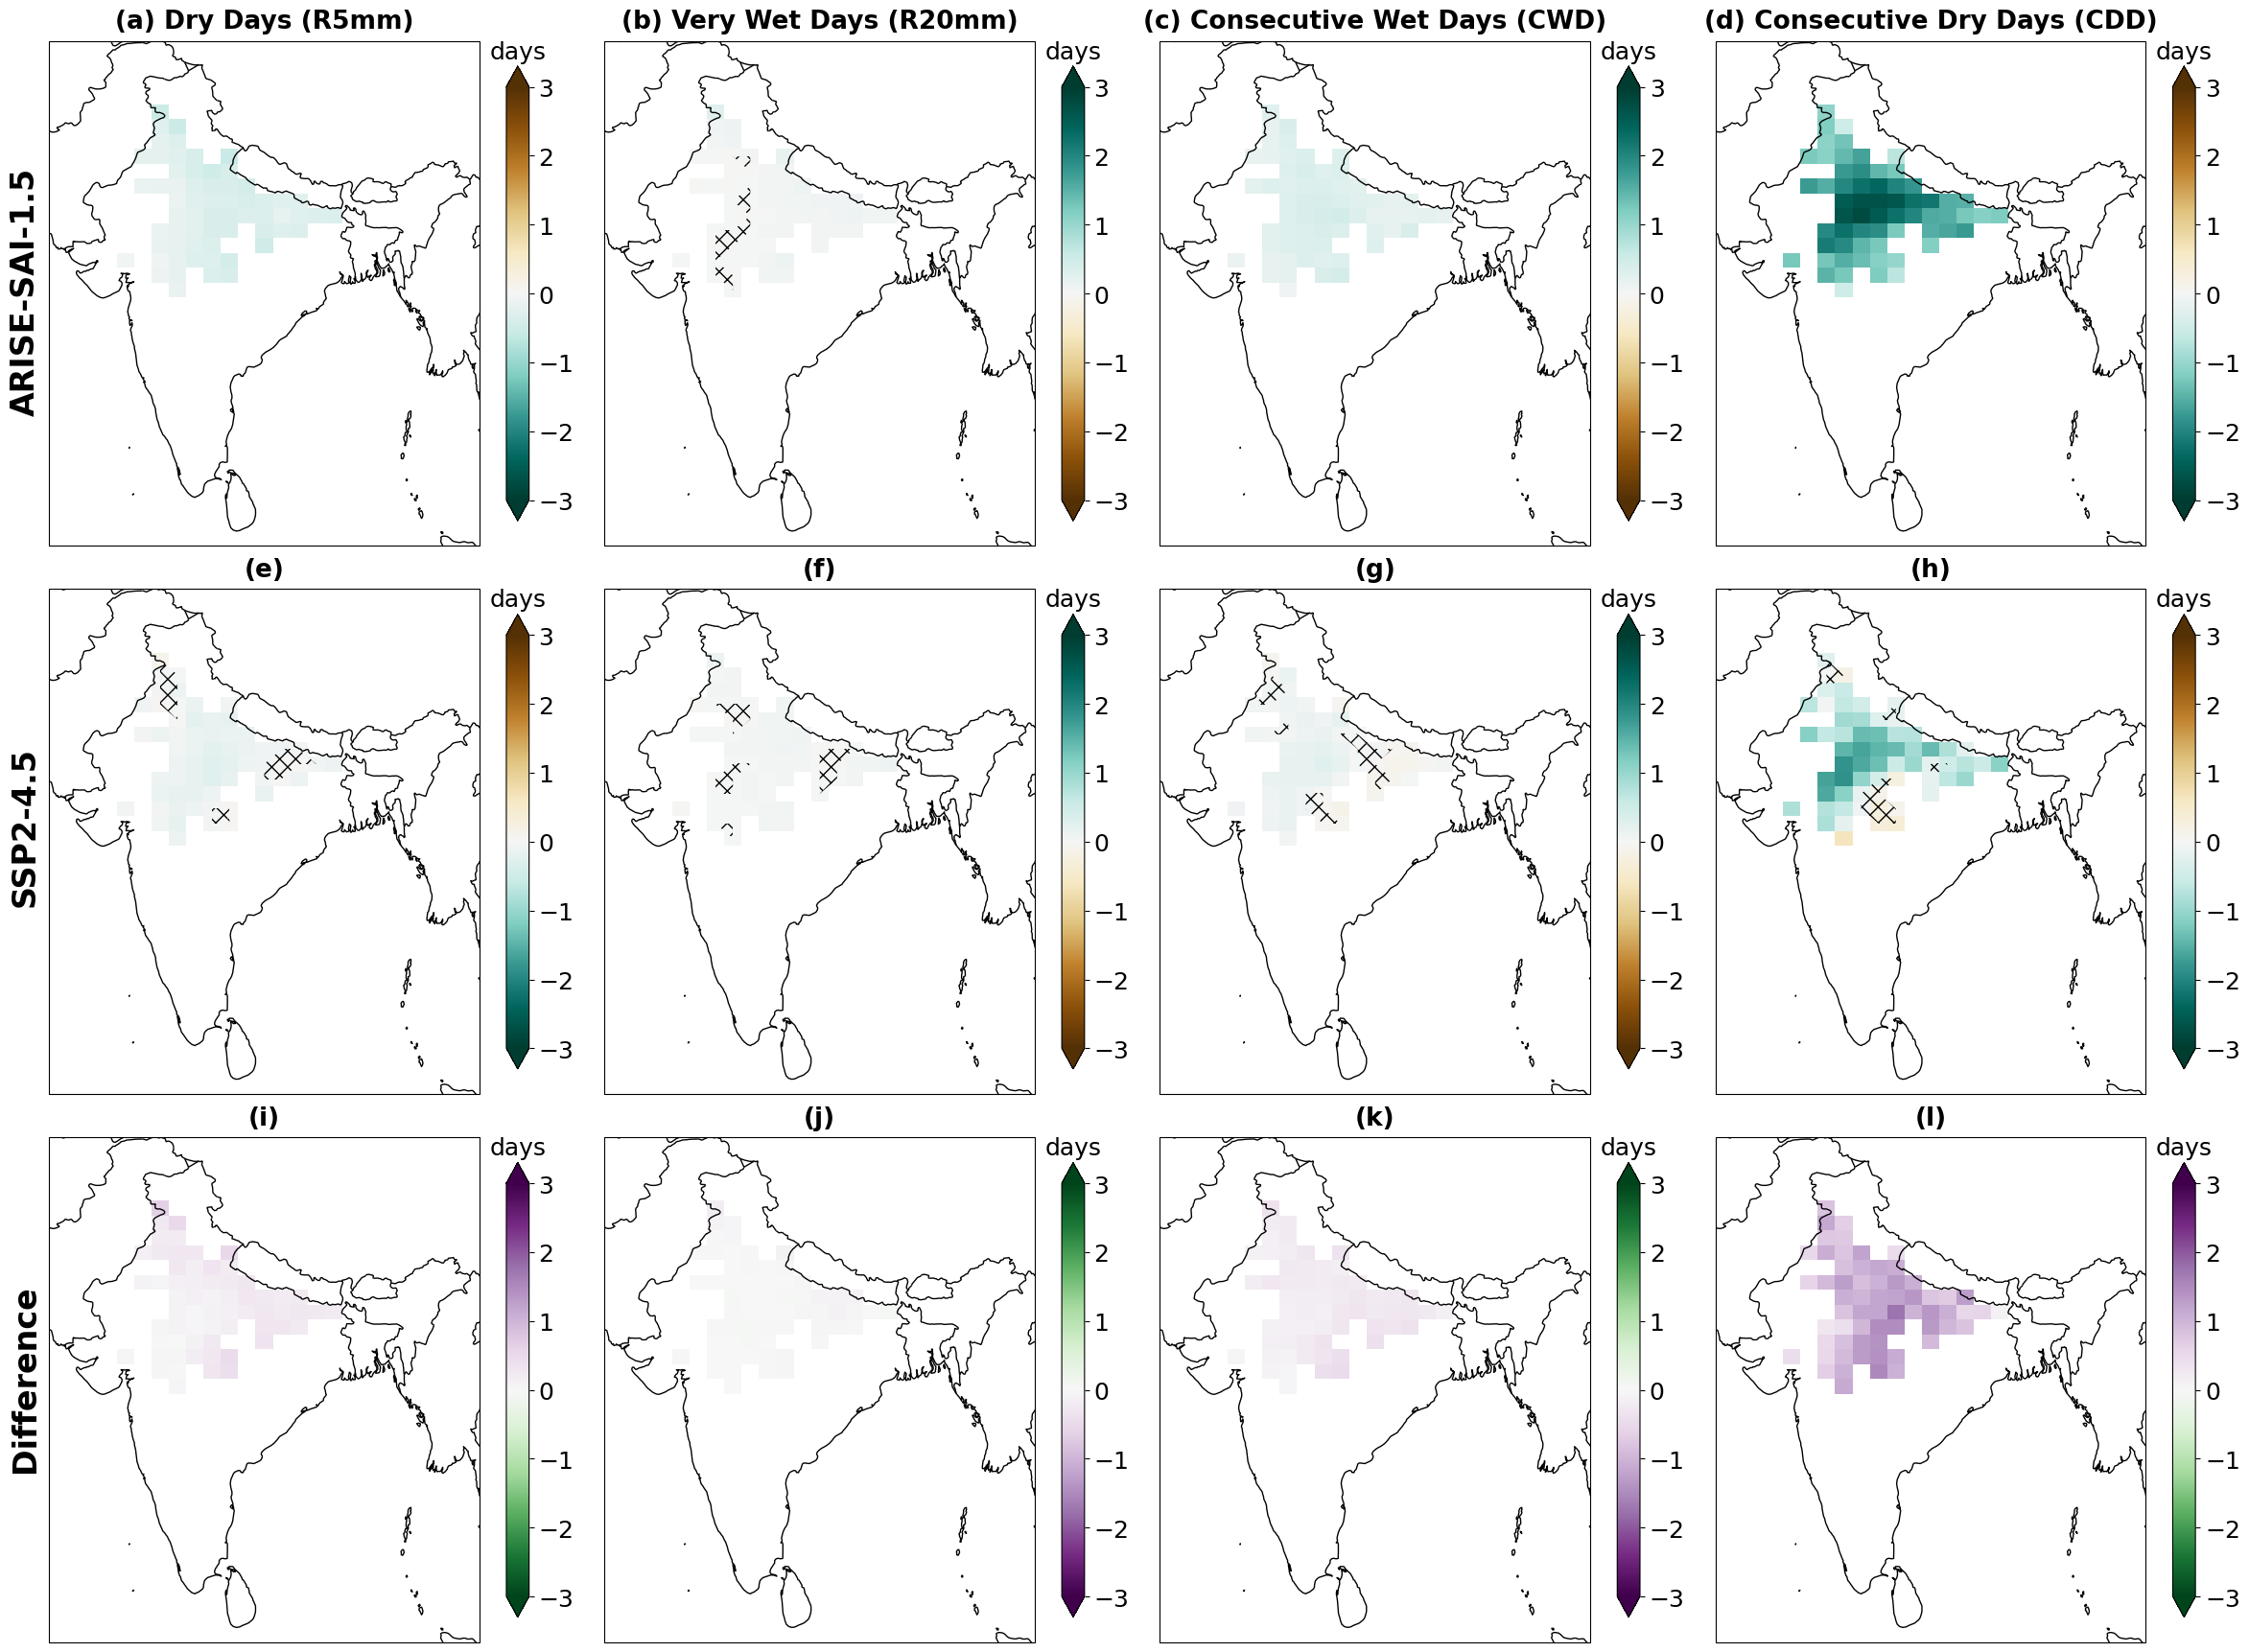

In [38]:
# Create a single 3-row figure
fig, axes = plt.subplots(3, 4, figsize=(24, 18), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles and color maps for each row
titles_row1 = ['(a) Dry Days (R5mm)', '(b) Very Wet Days (R20mm)',
               '(c) Consecutive Wet Days (CWD)',
               '(d) Consecutive Dry Days (CDD)',
               '(e)', '(f)', '(g)', '(h)']
titles_row3 = ['(i)', '(j)', '(k)', '(l)']

vmin, vmax = -3, 3

# Plot the first 8 subplots for rows 1 and 2
for i, (ax, key) in enumerate(zip(axes.flatten()[:8], precip_freq_indices_reproductive)):
    data = precip_freq_indices_reproductive[key]
    control = ctrl_prcp_freq_indices_reproductive[key]
    vals = data - control
    cmap = 'BrBG_r' if i in [0, 3, 4, 7] else "BrBG"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    # Plot data and customize each subplot
    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row1[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)

    # Hatch insignificance within CI range
    ci_lo = ci_prcp_freq_reproductive[key].ci_lo
    ci_hi = ci_prcp_freq_reproductive[key].ci_hi
    ci = data.where((ci_lo < data) & (data < ci_hi))
    ci.plot.contourf(ax=ax, hatches=hatch_pattern, colors='none', extend='neither', add_colorbar=False, add_labels=False)

    # Add coastline and borders
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Plot the third row of 4 subplots showing `ssp - arise`
for i, (ax, item) in enumerate(zip(axes[2, :], precip_freq_indices_reproductive.items())):
    arise = item[1]
    ssp = list(precip_freq_indices_reproductive.values())[i + 4]
    vals = ssp - arise
    cmap = 'PRGn_r' if i in [0, 3] else "PRGn"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row3[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Add text labels for each section
fig.text(0.01, 0.81, 'ARISE-SAI-1.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.5, 'SSP2-4.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.18, 'Difference', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')

plt.tight_layout(pad=3.5, h_pad=0.9, w_pad=1)

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


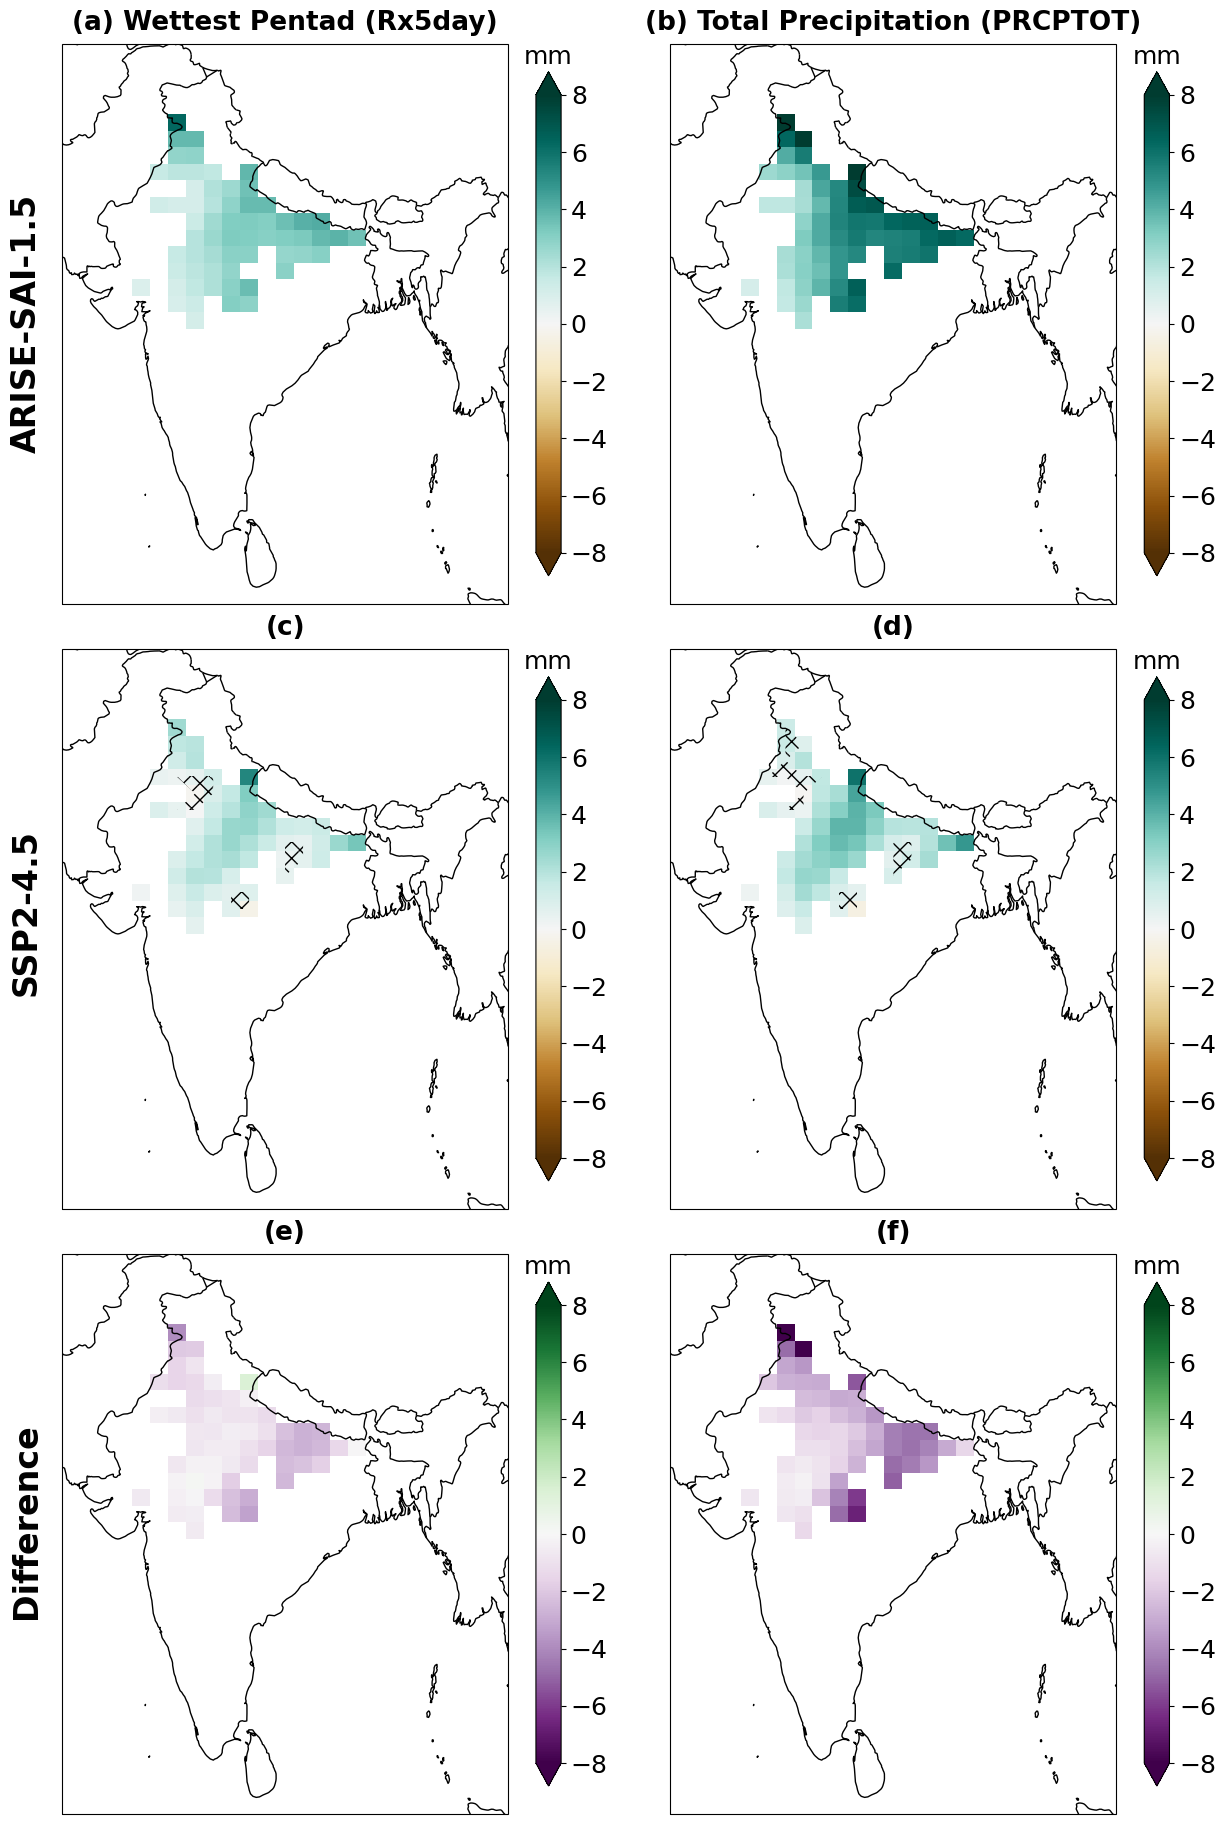

In [52]:
# create figure
fig, axes = plt.subplots(3, 2, figsize=(13, 19), subplot_kw={'projection': ccrs.PlateCarree()})

titles = ['(a) Wettest Pentad (Rx5day)',
          '(b) Total Precipitation (PRCPTOT)',
          '(c)','(d)']
titles_row3 = ['(e)', '(f)']
vmin, vmax = -8, 8
# average the ensemble members
for i, (ax, key) in enumerate(zip(axes.flatten()[:6], precip_amt_indices_reproductive)):
    data = precip_amt_indices_reproductive[key]
    control = ctrl_prcp_amt_indices_reproductive[key]
    vals = data - control
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
    cmap = "BrBG"

    map = vals.plot(ax=ax,
                    cmap=cmap,
                    norm=norm, 
                    vmin=vmin, vmax=vmax,
                    extend='both',
                    transform=ccrs.PlateCarree(),
                    add_colorbar=False,
                    add_labels=False,
                   )
    ci_lo = ci_prcp_amt_reproductive[key].ci_lo
    ci_hi = ci_prcp_amt_reproductive[key].ci_hi
    # hatch any statistical insignificance (within the control CI)
    ci = data.where((ci_lo < data) & (data < ci_hi))
    ci.plot.contourf(ax=ax, hatches=hatch_pattern, colors='none', extend='neither', add_colorbar=False)

    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('mm', fontsize=18)

    ax.set_title(titles[i], fontsize=19, fontweight='bold', y=1.01)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())

    # Adjust aspect ratio to stretch the map
    ax.set_aspect('auto', adjustable='box')

    # Remove grid lines and labels
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xlabel('')  # Remove x-axis ticks
    ax.set_ylabel('')  # Remove y-axis ticks

# Plot the third row of 3 subplots showing `ssp - arise`
for i, (ax, item) in enumerate(zip(axes[2, :], precip_amt_indices_reproductive.items())):
    arise = item[1]
    ssp = list(precip_amt_indices_reproductive.values())[i + 2]
    vals = ssp - arise
    cmap = "PRGn"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row3[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('mm', fontsize=18)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Add text labels to the left side of the figure
fig.text(0.01, 0.81, 'ARISE-SAI-1.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.5, 'SSP2-4.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.18, 'Difference', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')

plt.tight_layout(pad=3.5, h_pad=0.9, w_pad=1)

In [32]:
precip_freq_indices_ripening = {
    "ARISE-SAI-1.5 Dry Days (<R5mm)": map_averages(arise_prcp_indices_mean["R5mm"], 'ripening'),
    "ARISE-SAI-1.5 Very Wet Days (R20mm)": map_averages(arise_prcp_indices_mean["R20mm"], 'ripening'),
    "ARISE-SAI-1.5 Consecutive Wet Days (CWD)": map_averages(arise_prcp_indices_mean["CWD"], 'ripening'),
    "ARISE-SAI-1.5 Consecutive Dry Days (CDD)": map_averages(arise_prcp_indices_mean["CDD"], 'ripening'),
    
    "SSP2-4.5 Dry Days (<R5mm)": map_averages(ssp_prcp_indices_mean["R5mm"], 'ripening'),
    "SSP2-4.5 Very Wet Days (R20mm)": map_averages(ssp_prcp_indices_mean["R20mm"], 'ripening'),
    "SSP2-4.5 Consecutive Wet Days (CWD)": map_averages(ssp_prcp_indices_mean["CWD"], 'ripening'),
    "SSP2-4.5 Consecutive Dry Days (CDD)": map_averages(ssp_prcp_indices_mean["CDD"], 'ripening'),
}

ctrl_prcp_freq_indices_ripening = {
    "ARISE-SAI-1.5 Dry Days (<R5mm)": map_averages(ctrl_prcp_indices_mean["R5mm"], 'ripening'),
    "ARISE-SAI-1.5 Very Wet Days (R20mm)": map_averages(ctrl_prcp_indices_mean["R20mm"], 'ripening'),
    "ARISE-SAI-1.5 Consecutive Wet Days (CWD)": map_averages(ctrl_prcp_indices_mean["CWD"], 'ripening'),
    "ARISE-SAI-1.5 Consecutive Dry Days (CDD)": map_averages(ctrl_prcp_indices_mean["CDD"], 'ripening'),
    
    "SSP2-4.5 Dry Days (<R5mm)": map_averages(ctrl_prcp_indices_mean["R5mm"], 'ripening'),
    "SSP2-4.5 Very Wet Days (R20mm)": map_averages(ctrl_prcp_indices_mean["R20mm"], 'ripening'),
    "SSP2-4.5 Consecutive Wet Days (CWD)": map_averages(ctrl_prcp_indices_mean["CWD"], 'ripening'),
    "SSP2-4.5 Consecutive Dry Days (CDD)": map_averages(ctrl_prcp_indices_mean["CDD"], 'ripening'),
}


precip_amt_indices_ripening = {
    "ARISE-SAI-1.5 Wettest Pentad (Rx5day)": map_averages(arise_prcp_indices_mean["Rx5day"], 'ripening'),
    "ARISE-SAI-1.5 Total Precipitation (PRECTOT)": map_averages(arise_prcp_indices_mean["PRECTOT"], 'ripening'),

    "SSP2-4.5 Wettest Pentad (Rx5day)": map_averages(ssp_prcp_indices_mean["Rx5day"], 'ripening'),
    "SSP2-4.5 Total Precipitation (PRECTOT)": map_averages(ssp_prcp_indices_mean["PRECTOT"], 'ripening'),
}

ctrl_prcp_amt_indices_ripening = {
    "ARISE-SAI-1.5 Wettest Pentad (Rx5day)": map_averages(ctrl_prcp_indices_mean["Rx5day"], 'ripening'),
    "ARISE-SAI-1.5 Total Precipitation (PRECTOT)": map_averages(ctrl_prcp_indices_mean["PRECTOT"], 'ripening'),

    "SSP2-4.5 Wettest Pentad (Rx5day)": map_averages(ctrl_prcp_indices_mean["Rx5day"], 'ripening'),
    "SSP2-4.5 Total Precipitation (PRECTOT)": map_averages(ctrl_prcp_indices_mean["PRECTOT"], 'ripening'),
}

In [33]:
ci_prcp_freq_ripening = {}
with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_R5mm_ripening.pkl', 'rb') as file:
    ci_prcp_freq_ripening['ARISE-SAI-1.5 Dry Days (<R5mm)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_ripening['SSP2-4.5 Dry Days (<R5mm)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_R20mm_ripening.pkl', 'rb') as file:
    ci_prcp_freq_ripening['ARISE-SAI-1.5 Very Wet Days (R20mm)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_ripening['SSP2-4.5 Very Wet Days (R20mm)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_CWD_ripening.pkl', 'rb') as file:
    ci_prcp_freq_ripening['ARISE-SAI-1.5 Consecutive Wet Days (CWD)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_ripening['SSP2-4.5 Consecutive Wet Days (CWD)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_CDD_ripening.pkl', 'rb') as file:
    ci_prcp_freq_ripening['ARISE-SAI-1.5 Consecutive Dry Days (CDD)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_freq_ripening['SSP2-4.5 Consecutive Dry Days (CDD)'] = pickle.load(file)

ci_prcp_amt_ripening = {}
with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_Rx5day_ripening.pkl', 'rb') as file:
    ci_prcp_amt_ripening['ARISE-SAI-1.5 Wettest Pentad (Rx5day)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_amt_ripening['SSP2-4.5 Wettest Pentad (Rx5day)'] = pickle.load(file)

with open('/glade/work/ninag/Conf-intervals/wheat/ctrl_PRECTOT_ripening.pkl', 'rb') as file:
    ci_prcp_amt_ripening['ARISE-SAI-1.5 Total Precipitation (PRECTOT)'] = pickle.load(file)
    file.seek(0)  # Reset the file pointer back to the beginning of the file
    ci_prcp_amt_ripening['SSP2-4.5 Total Precipitation (PRECTOT)'] = pickle.load(file)


/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


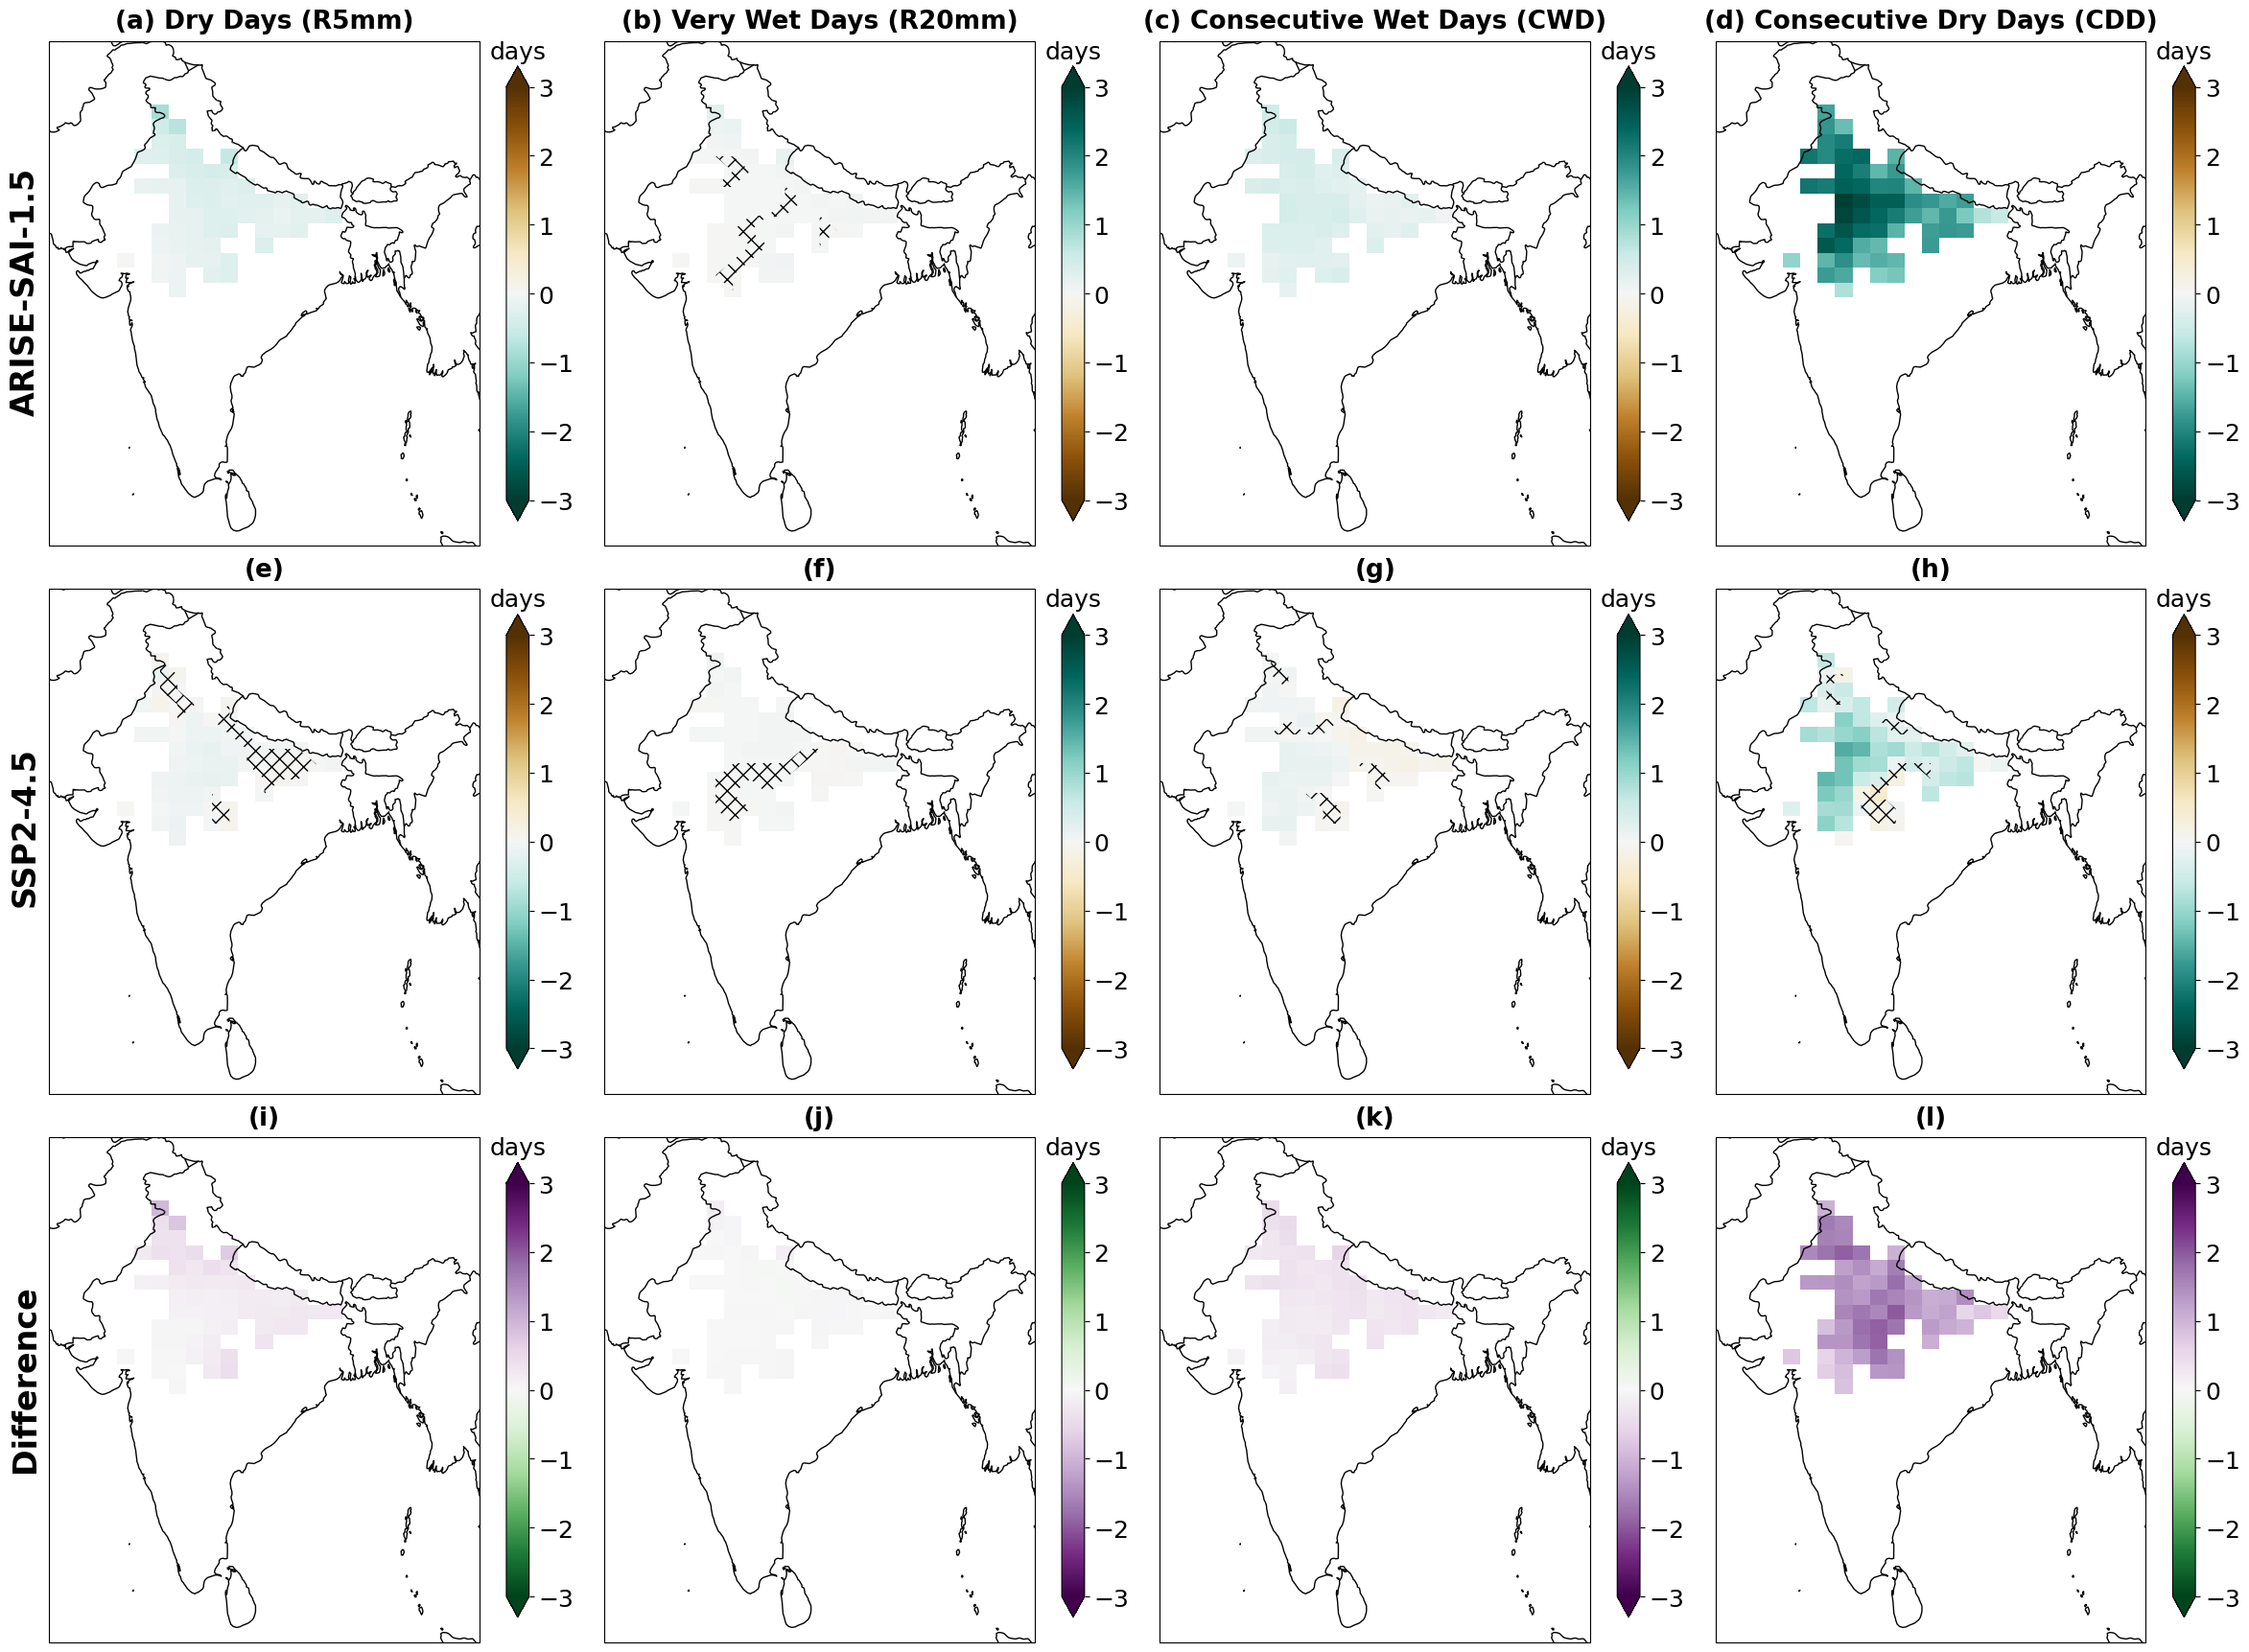

In [39]:
# Create a single 3-row figure
fig, axes = plt.subplots(3, 4, figsize=(24, 18), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles and color maps for each row
titles_row1 = ['(a) Dry Days (R5mm)', '(b) Very Wet Days (R20mm)',
               '(c) Consecutive Wet Days (CWD)',
               '(d) Consecutive Dry Days (CDD)',
               '(e)', '(f)', '(g)', '(h)']
titles_row3 = ['(i)', '(j)', '(k)', '(l)']

vmin, vmax = -3, 3

# Plot the first 8 subplots for rows 1 and 2
for i, (ax, key) in enumerate(zip(axes.flatten()[:8], precip_freq_indices_ripening)):
    data = precip_freq_indices_ripening[key]
    control = ctrl_prcp_freq_indices_ripening[key]
    vals = data - control
    cmap = 'BrBG_r' if i in [0, 3, 4, 7] else "BrBG"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    # Plot data and customize each subplot
    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row1[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)

    # Hatch insignificance within CI range
    ci_lo = ci_prcp_freq_ripening[key].ci_lo
    ci_hi = ci_prcp_freq_ripening[key].ci_hi
    ci = data.where((ci_lo < data) & (data < ci_hi))
    ci.plot.contourf(ax=ax, hatches=hatch_pattern, colors='none', extend='neither', add_colorbar=False, add_labels=False)

    # Add coastline and borders
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Plot the third row of 4 subplots showing `ssp - arise`
for i, (ax, item) in enumerate(zip(axes[2, :], precip_freq_indices_ripening.items())):
    arise = item[1]
    ssp = list(precip_freq_indices_ripening.values())[i + 4]
    vals = ssp - arise
    cmap = 'PRGn_r' if i in [0, 3] else "PRGn"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row3[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('days', fontsize=18)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Add text labels for each section
fig.text(0.01, 0.81, 'ARISE-SAI-1.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.5, 'SSP2-4.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.18, 'Difference', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')

plt.tight_layout(pad=3.5, h_pad=0.9, w_pad=1)

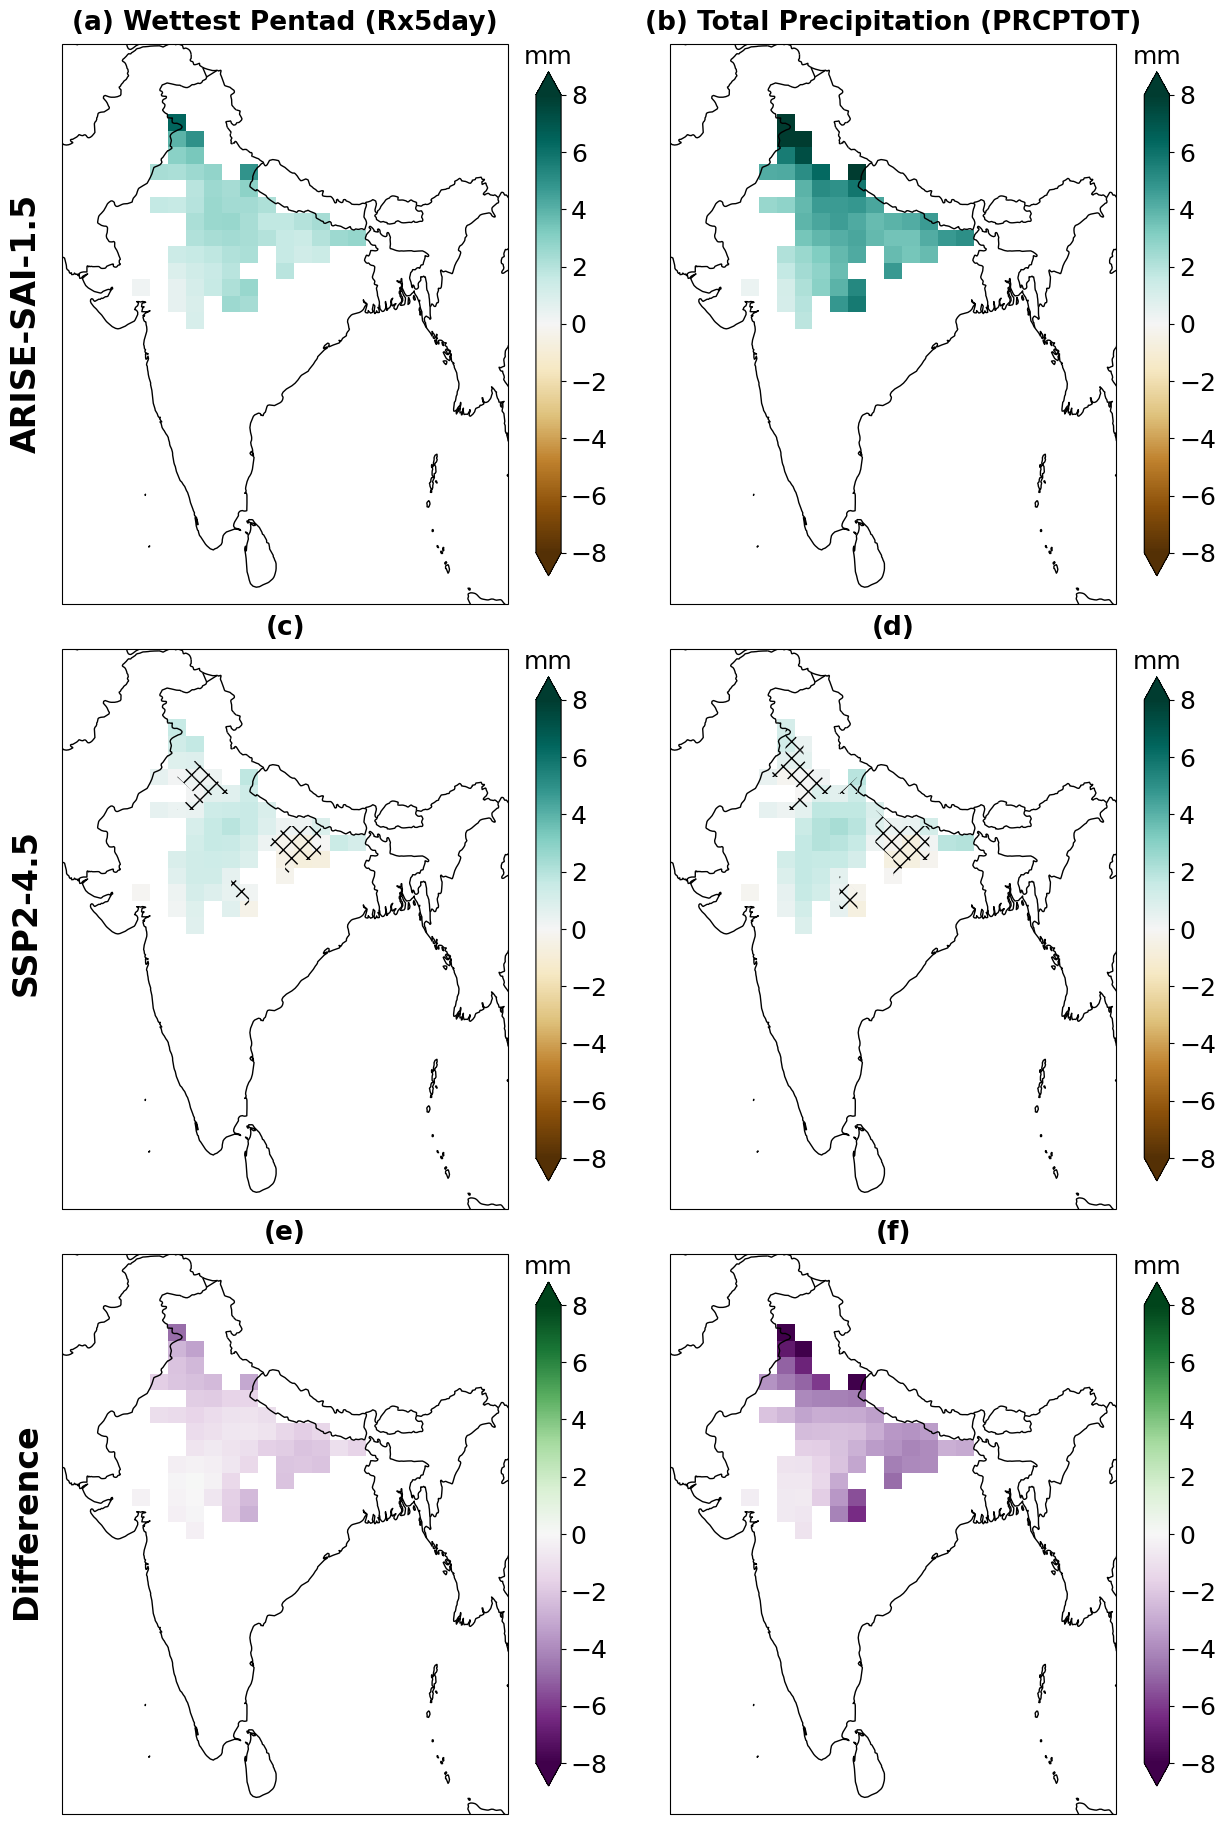

In [53]:
# create figure
fig, axes = plt.subplots(3, 2, figsize=(13, 19), subplot_kw={'projection': ccrs.PlateCarree()})

titles = ['(a) Wettest Pentad (Rx5day)',
          '(b) Total Precipitation (PRCPTOT)',
          '(c)','(d)']
titles_row3 = ['(e)', '(f)']
vmin, vmax = -8, 8
# average the ensemble members
for i, (ax, key) in enumerate(zip(axes.flatten()[:6], precip_amt_indices_ripening)):
    data = precip_amt_indices_ripening[key]
    control = ctrl_prcp_amt_indices_ripening[key]
    vals = data - control
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
    cmap = "BrBG"

    map = vals.plot(ax=ax,
                    cmap=cmap,
                    norm=norm, 
                    vmin=vmin, vmax=vmax,
                    extend='both',
                    transform=ccrs.PlateCarree(),
                    add_colorbar=False,
                    add_labels=False,
                   )
    ci_lo = ci_prcp_amt_ripening[key].ci_lo
    ci_hi = ci_prcp_amt_ripening[key].ci_hi
    # hatch any statistical insignificance (within the control CI)
    ci = data.where((ci_lo < data) & (data < ci_hi))
    ci.plot.contourf(ax=ax, hatches=hatch_pattern, colors='none', extend='neither', add_colorbar=False)

    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('mm', fontsize=18)

    ax.set_title(titles[i], fontsize=19, fontweight='bold', y=1.01)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())

    # Adjust aspect ratio to stretch the map
    ax.set_aspect('auto', adjustable='box')

    # Remove grid lines and labels
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xlabel('')  # Remove x-axis ticks
    ax.set_ylabel('')  # Remove y-axis ticks

# Plot the third row of 3 subplots showing `ssp - arise`
for i, (ax, item) in enumerate(zip(axes[2, :], precip_amt_indices_ripening.items())):
    arise = item[1]
    ssp = list(precip_amt_indices_ripening.values())[i + 2]
    vals = ssp - arise
    cmap = "PRGn"
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    map = vals.plot(ax=ax, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
    ax.set_title(titles_row3[i], fontsize=19, fontweight='bold', y=1.01)
    cbar = plt.colorbar(map, ax=ax, extend='both', shrink=0.9)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('mm', fontsize=18)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([67, 98, 5, 37], crs=ccrs.PlateCarree())
    ax.set_aspect('auto', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

# Add text labels to the left side of the figure
fig.text(0.01, 0.81, 'ARISE-SAI-1.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.5, 'SSP2-4.5', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')
fig.text(0.01, 0.18, 'Difference', fontsize=24, fontweight='bold', rotation='vertical', va='center', ha='center')

plt.tight_layout(pad=3.5, h_pad=0.9, w_pad=1)

## Fig B: Shifting Planting Dates

In [17]:
def planting_date_avg(ds):
    """
    date1 (str): 'YYYY-MM'
    year2 (str): 'YYYY'
    """

    ds = ds.sel(time=slice('2050-10', '2069'))
    # starting days of each planting date/stage
    daysofyear = [288, 295, 302, 309, 316, 323, 330, 337, 344, 351, 358, 365,
                  7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,
                  91, 98, 105]

    # Repeat the list 19 times for the 19 years from 2050-2069
    repeated_daysofyear = np.tile(daysofyear, 19)

    # Create a new DataArray with the same coordinates and dimensions as time
    da_matching_format = xr.DataArray(repeated_daysofyear, dims='time', coords={'time': ds.coords['time']})

    ds['dayofyear'] = da_matching_format

    # Group by the new dayofyear coordinate and calculate the mean
    ds_mean = ds.groupby('dayofyear').mean('time').where(regridded_wheatmask >= wheat_threshold)

    return ds_mean.salem.roi(shape=india_mask).mean(['lat','lon'], keep_attrs=True)


def ctrl_planting_date_avg(ds):

    daysofyear = [288, 295, 302, 309, 316, 323, 330, 337, 344, 351, 358, 365,
                  7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,  
                  91, 98, 105]

    # Repeat the list 19 times for the 19 years from 2050-2069
    repeated_daysofyear = np.tile(daysofyear, 2035-2015)

    # Create a new DataArray with the same coordinates and dimensions as time
    da_matching_format = xr.DataArray(repeated_daysofyear, dims='time', coords={'time': ds.coords['time']})

    ds['dayofyear'] = da_matching_format

    # Group by the new dayofyear coordinate and calculate the mean
    ds_mean = ds.groupby('dayofyear').mean('time').where(regridded_wheatmask >= wheat_threshold)

    return ds_mean.salem.roi(shape=india_mask).mean(['lat','lon'], keep_attrs=True)


def rep_dates(dt):
    return np.concatenate((dt.reproductive.values[-2:], dt.reproductive.values[:10]))

### All indices (supplement)

In [21]:
# average over planting dates
arise_ensmean_planting_dates = {
    
    'Total Precipitation (PRCPTOT)': planting_date_avg(arise_prcp_indices_mean['PRECTOT']),
    # 'Dry Days (R5mm)': planting_date_avg(arise_prcp_indices_mean['R5mm']),
    # 'Consecutive Dry Days (CDD)':  planting_date_avg(arise_prcp_indices_mean['CDD']),
    # 'Wettest 5-Day Period (Rx5day)': planting_date_avg(arise_prcp_indices_mean['Rx5day']),
    # 'Very Wet Days (R20mm)': planting_date_avg(arise_prcp_indices_mean['R20mm']),
    # 'Consecutive Wet Days (CWD)': planting_date_avg(arise_prcp_indices_mean['CWD']),
    'Warm Spell Duration Index (WSDI)': planting_date_avg(arise_tmax_indices_mean['WSDI']),
    # 'Tropical Nights (TR)': planting_date_avg(arise_tmin_indices_mean['TR']),
    'Hot Days (HD)': planting_date_avg(arise_tmax_indices_mean['HD34']),
    # 'Cold Spell Duration Index (CSDI)': planting_date_avg(arise_tmin_indices_mean['CSDI']),
    # 'Frost Days (FD)': planting_date_avg(arise_tmin_indices_mean['FD']),
    # 'Ice Days (ID)': planting_date_avg(arise_tmax_indices_mean['ID']),  
}

ssp245_ensmean_planting_dates = {

    'Total Precipitation (PRCPTOT)': planting_date_avg(ssp_prcp_indices_mean['PRECTOT']),
    'Dry Days (R5mm)': planting_date_avg(ssp_prcp_indices_mean['R5mm']),
    'Consecutive Dry Days (CDD)':  planting_date_avg(ssp_prcp_indices_mean['CDD']),
    'Wettest 5-Day Period (Rx5day)': planting_date_avg(ssp_prcp_indices_mean['Rx5day']),
    'Very Wet Days (R20mm)': planting_date_avg(ssp_prcp_indices_mean['R20mm']),
    'Consecutive Wet Days (CWD)': planting_date_avg(ssp_prcp_indices_mean['CWD']),
    'Warm Spell Duration Index (WSDI)': planting_date_avg(ssp_tmax_indices_mean['WSDI']),
    'Tropical Nights (TR)': planting_date_avg(ssp_tmin_indices_mean['TR']),
    'Hot Days (HD)': planting_date_avg(ssp_tmax_indices_mean['HD34']),
    'Cold Spell Duration Index (CSDI)': planting_date_avg(ssp_tmin_indices_mean['CSDI']),
    # 'Frost Days (FD)': planting_date_avg(ssp_tmin_indices_mean['FD']),
    # 'Ice Days (ID)': planting_date_avg(ssp_tmax_indices_mean['ID']),
}

ctrl_ensmean_planting_dates = {
   
    'Total Precipitation (PRCPTOT)': ctrl_planting_date_avg(ctrl_prcp_indices_mean['PRECTOT']),
    'Dry Days (R5mm)': ctrl_planting_date_avg(ctrl_prcp_indices_mean['R5mm']),
    'Consecutive Dry Days (CDD)':  ctrl_planting_date_avg(ctrl_prcp_indices_mean['CDD']),

    'Wettest 5-Day Period (Rx5day)': ctrl_planting_date_avg(ctrl_prcp_indices_mean['Rx5day']),
    'Very Wet Days (R20mm)': ctrl_planting_date_avg(ctrl_prcp_indices_mean['R20mm']),
    'Consecutive Wet Days (CWD)': ctrl_planting_date_avg(ctrl_prcp_indices_mean['CWD']),

    'Warm Spell Duration Index (WSDI)': ctrl_planting_date_avg(ctrl_tmax_indices_mean['WSDI']),
    'Tropical Nights (TR)': ctrl_planting_date_avg(ctrl_tmin_indices_mean['TR']),
    'Hot Days (HD)': ctrl_planting_date_avg(ctrl_tmax_indices_mean['HD34']),
    
    'Cold Spell Duration Index (CSDI)': ctrl_planting_date_avg(ctrl_tmin_indices_mean['CSDI']),
    # 'Frost Days (FD)': ctrl_planting_date_avg(ctrl_tmin_indices_mean['FD']),
    # 'Ice Days (ID)': ctrl_planting_date_avg(ctrl_tmax_indices_mean['ID']),
}

In [22]:
control_all_indices = [
    control_prcp_indices[0],
    control_prcp_indices[1],
    control_prcp_indices[5],
    
    control_prcp_indices[3],
    control_prcp_indices[2],
    control_prcp_indices[4],
    
    control_tmax_indices[1],
    control_tmin_indices[0],
    control_tmax_indices[0],
    
    control_tmin_indices[1],
    # control_tmin_indices[0],
    # control_tmax_indices[0],
]
arise_all_indices = [
    
    arise_prcp_indices['PRECTOT'],
    arise_prcp_indices['R5mm'],
    arise_prcp_indices['CDD'],

    arise_prcp_indices['Rx5day'],
    arise_prcp_indices['R20mm'],
    arise_prcp_indices['CWD'],
    
    arise_tmax_indices['WSDI'],
    arise_tmin_indices['TR'],
    arise_tmax_indices['HD34'],
    
    arise_tmin_indices['CSDI'],
    # arise_tmin_indices['FD'],
    # arise_tmax_indices['ID'],
]
ssp245_all_indices = [
    
    ssp245_prcp_indices['PRECTOT'],
    ssp245_prcp_indices['R5mm'],
    ssp245_prcp_indices['CDD'],
    ssp245_prcp_indices['Rx5day'],
    ssp245_prcp_indices['R20mm'],
    ssp245_prcp_indices['CWD'],
    ssp245_tmax_indices['WSDI'],
    ssp245_tmin_indices['TR'],
    ssp245_tmax_indices['HD34'],
    ssp245_tmin_indices['CSDI'],
    # ssp245_tmin_indices['FD'],
    # ssp245_tmax_indices['ID'],
]

ctrl_veg_data, ctrl_rep_data, ctrl_rip_data = [], [], []
arise_veg_data, arise_rep_data, arise_rip_data = [], [], []
ssp_veg_data, ssp_rep_data, ssp_rip_data = [], [], []

for i, label in enumerate(ctrl_ensmean_planting_dates):
    # Control
    ctrl_veg, ctrl_rep, ctrl_rip = [], [], []
    for ens in control_all_indices[i]:
        data_by_day = ctrl_planting_date_avg(ens)
        ctrl_veg.append(data_by_day.vegetative.dropna(dim='dayofyear'))
        ctrl_rep.append(rep_dates(data_by_day))
        ctrl_rip.append(data_by_day.ripening.dropna(dim='dayofyear'))

    ctrl_veg_data.append(ctrl_veg)
    ctrl_rep_data.append(ctrl_rep)
    ctrl_rip_data.append(ctrl_rip)

    # ARISE
    veg, rep, rip = [], [], []
    for ens in arise_all_indices[i]:
        data_by_day = planting_date_avg(ens)
        veg.append(data_by_day.vegetative.dropna(dim='dayofyear'))
        rep.append(rep_dates(data_by_day))
        rip.append(data_by_day.ripening.dropna(dim='dayofyear'))

    arise_veg_data.append(veg)
    arise_rep_data.append(rep)
    arise_rip_data.append(rip)

    # SSP2-4.5
    ssp_veg, ssp_rep, ssp_rip = [], [], []
    for ens in ssp245_all_indices[i]:
        data_by_day = planting_date_avg(ens)
        ssp_veg.append(data_by_day.vegetative.dropna(dim='dayofyear'))
        ssp_rep.append(rep_dates(data_by_day))
        ssp_rip.append(data_by_day.ripening.dropna(dim='dayofyear'))

    ssp_veg_data.append(ssp_veg)
    ssp_rep_data.append(ssp_rep)
    ssp_rip_data.append(ssp_rip)

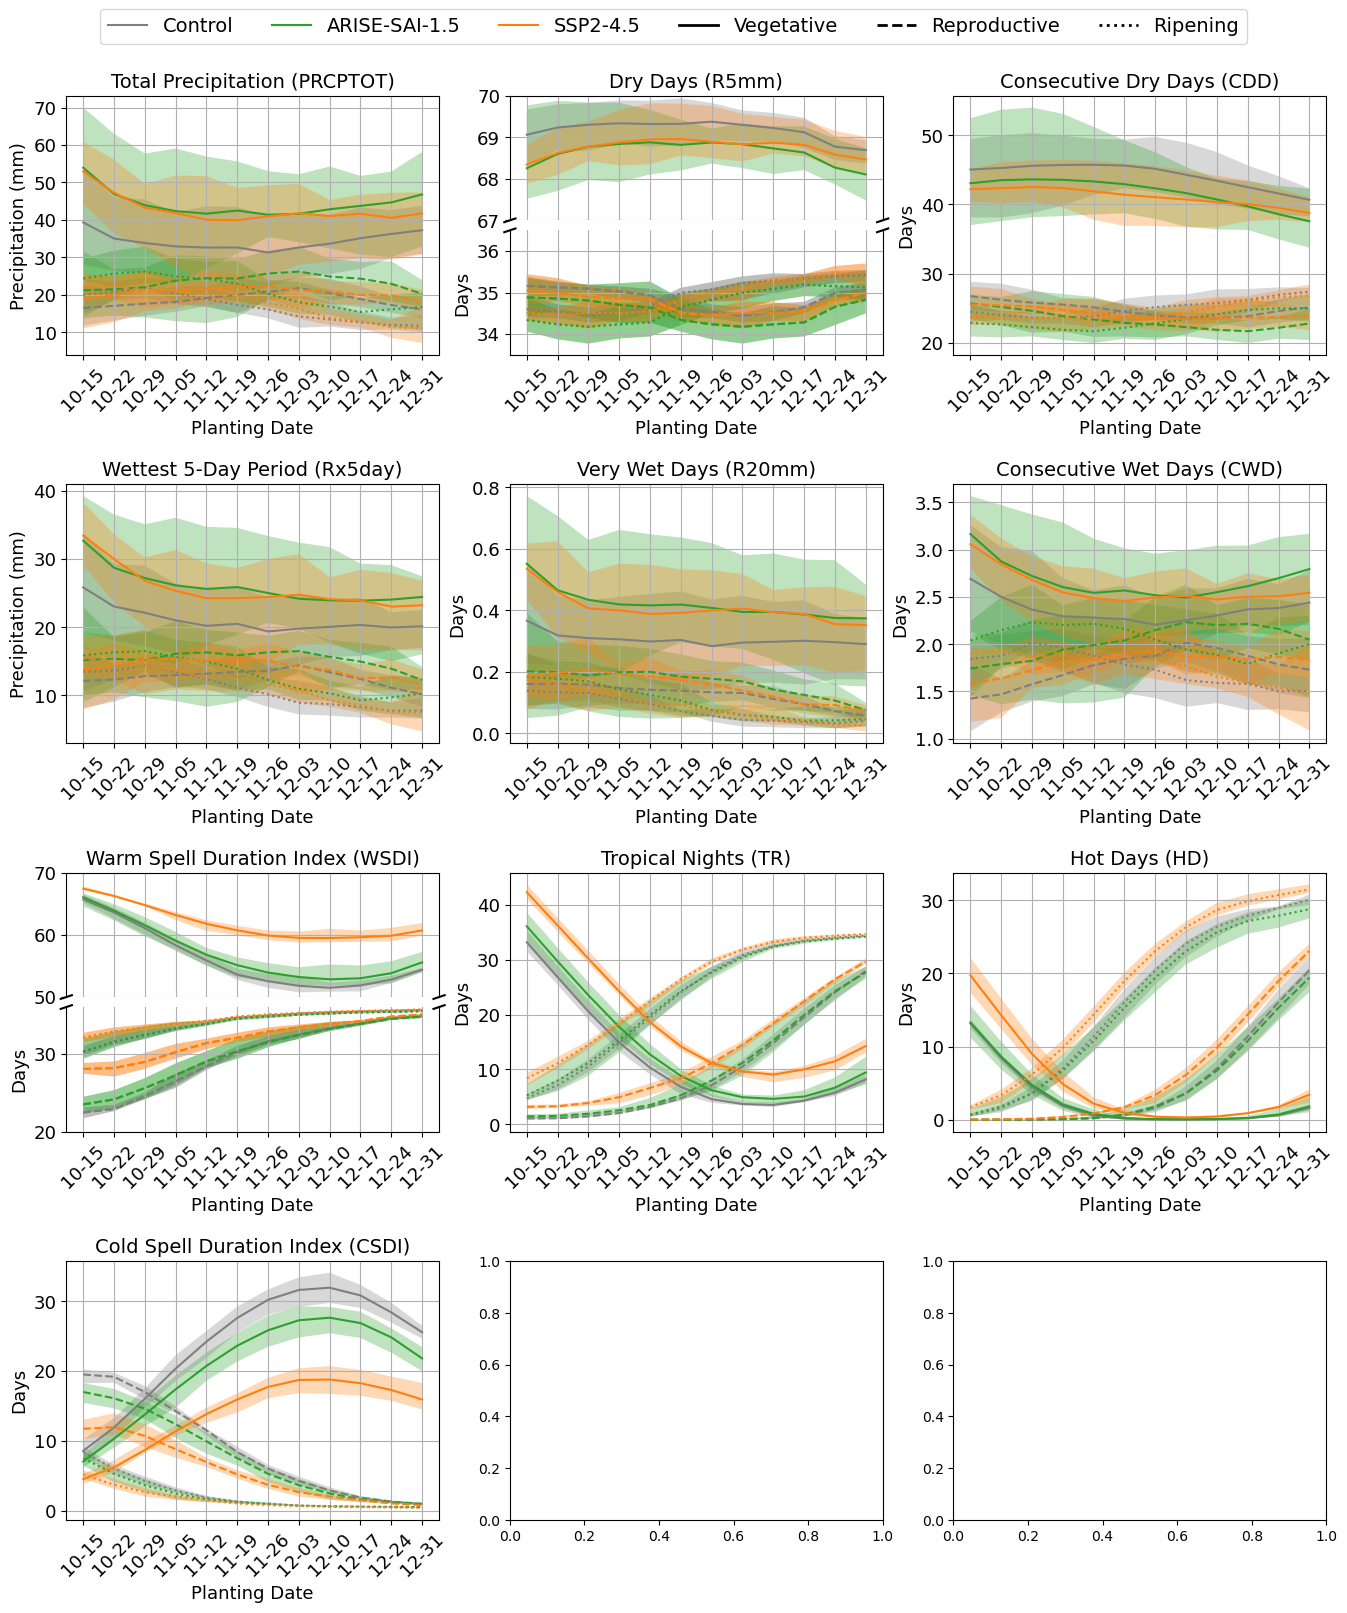

In [57]:
# Define function to plot data
def plot_data(ax, xaxis, ensmean, veg, rep, rip, color, label_prefix):
    ax.plot(xaxis, ensmean.vegetative.dropna(dim='dayofyear'), color=color, ls='-', label=label_prefix+'_Veg')
    ax.plot(xaxis, rep_dates(ensmean), color=color, ls='--', label=label_prefix+'_Rep')
    ax.plot(xaxis, ensmean.ripening.dropna(dim='dayofyear'), color=color, ls=':', label=label_prefix+'_Ripe')

    ax.fill_between(xaxis, np.min(np.array(veg), axis=0), np.max(np.array(veg), axis=0), color=color, alpha=alpha, ec=None)
    ax.fill_between(xaxis, np.min(np.array(rep), axis=0), np.max(np.array(rep), axis=0), color=color, alpha=alpha, ec=None)
    ax.fill_between(xaxis, np.min(np.array(rip), axis=0), np.max(np.array(rip), axis=0), color=color, alpha=alpha, ec=None)


# Define xaxis, ticks, and alpha
xaxis = range(12)  # number of sowing dates
alpha = 0.3
tick_labels = ['10-15', '10-22', '10-29', '11-05', '11-12', '11-19', '11-26', '12-03', '12-10', '12-17', '12-24', '12-31']
y_labels = ['Precipitation (mm)', 'Days', 'Days', 'Precipitation (mm)', 'Days', 'Days', 'Days',  
            'Days', 'Days', 'Days', 'Days', 'Days']

# Create subplots
fig, axs = plt.subplots(4, 3, figsize=(14, 16))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Save custom y limits for 2nd and 7th subplots
lower_plot = [None, (33.5, 36.5), None, None, None, None, (20, 36)]
upper_plot = [None, (67, 70), None, None, None, None, (50, 70)]

# Loop through the dictionaries
for i, label in enumerate(ctrl_ensmean_planting_dates):

    # Get corresponding ensmean data
    ctrl_ensmean = ctrl_ensmean_planting_dates[label]
    arise_ensmean = arise_ensmean_planting_dates[label]
    ssp_ensmean = ssp245_ensmean_planting_dates[label]

    # Add breaklines to the 2nd and 7th subplots
    if i == 1 or i == 6:
        ax = axs[i]
        divider = make_axes_locatable(ax)
        ax2 = divider.new_vertical(size="100%", pad=0.1)
        fig.add_axes(ax2)

        # ax.scatter(x, y)
        plot_data(ax, xaxis, ctrl_ensmean, ctrl_veg_data[i], ctrl_rep_data[i], ctrl_rip_data[i], 'tab:gray', 'Control')
        plot_data(ax, xaxis, arise_ensmean, arise_veg_data[i], arise_rep_data[i], arise_rip_data[i], 'tab:green', 'ARISE')
        plot_data(ax, xaxis, ssp_ensmean, ssp_veg_data[i], ssp_rep_data[i], ssp_rip_data[i], 'tab:orange', 'SSP2-4.5')

        ax.set_ylim(lower_plot[i])
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_tick_params(labelsize=13)
        
        # ax2.scatter(x, y)
        plot_data(ax2, xaxis, ctrl_ensmean, ctrl_veg_data[i], ctrl_rep_data[i], ctrl_rip_data[i], 'tab:gray', 'Control')
        plot_data(ax2, xaxis, arise_ensmean, arise_veg_data[i], arise_rep_data[i], arise_rip_data[i], 'tab:green', 'ARISE')
        plot_data(ax2, xaxis, ssp_ensmean, ssp_veg_data[i], ssp_rep_data[i], ssp_rip_data[i], 'tab:orange', 'SSP2-4.5')

        ax2.set_ylim(upper_plot[i])
        ax2.tick_params(bottom=False, labelbottom=False)
        ax2.spines['bottom'].set_visible(False)
        ax2.grid(True)
        ax2.set_xticks(xaxis)
        ax2.set_title(label, fontsize=14)
        ax2.yaxis.set_tick_params(labelsize=13)
        
        # From https://matplotlib.org/examples/pylab_examples/broken_axis.html
        d = .015  # how big to make the diagonal lines in axes coordinates
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
        ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
        ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
        
        kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
        ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
        ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # Plot the data on the corresponding subplot
    plot_data(axs[i], xaxis, ctrl_ensmean, ctrl_veg_data[i], ctrl_rep_data[i], ctrl_rip_data[i], 'tab:gray', 'Control')
    plot_data(axs[i], xaxis, arise_ensmean, arise_veg_data[i], arise_rep_data[i], arise_rip_data[i], 'tab:green', 'ARISE')
    plot_data(axs[i], xaxis, ssp_ensmean, ssp_veg_data[i], ssp_rep_data[i], ssp_rip_data[i], 'tab:orange', 'SSP2-4.5')

    # Set subplot title
    if i != 1 and i != 6:
        axs[i].set_title(label, fontsize=14)

    # Specify tick values and labels along the x-axis
    axs[i].set_xticks(xaxis)
    axs[i].set_xticklabels(tick_labels, rotation=45, fontsize=13)
    # Get the current subplot's size
    subplot_size = axs[i].get_position().size

    # Calculate the space each tick label occupies within the subplot
    label_width = subplot_size[0] / len(tick_labels)

    # Set step for displaying tick labels within the subplot
    step = max(1, int(label_width / 0.15))  # Adjust the value 0.15 to fit your preference

    # Show only every 'step' tick label within the subplot
    for k, label in enumerate(axs[i].xaxis.get_ticklabels()):
        if k % step != 0:
            label.set_visible(False)

    axs[i].yaxis.set_tick_params(labelsize=13)

    # Add x and y labels for each subplot
    axs[i].set_xlabel('Planting Date', fontsize=13)
    axs[i].set_ylabel(y_labels[i], fontsize=13)

    # Apply grid to each subplot
    axs[i].grid(True)

# Create custom legend
legend_elements = [
    plt.Line2D([0], [0], color='tab:gray', linestyle='-', label='Control'),
    plt.Line2D([0], [0], color='tab:green', linestyle='-', label='ARISE-SAI-1.5'),
    plt.Line2D([0], [0], color='tab:orange', linestyle='-', label='SSP2-4.5'),
    plt.Line2D([0], [0], color='k', linestyle='-', linewidth=2, label='Vegetative'),
    plt.Line2D([0], [0], color='k', linestyle='--', linewidth=2, label='Reproductive'),
    plt.Line2D([0], [0], color='k', linestyle=':', linewidth=2, label='Ripening'),
]
# Create the legend outside the loop
fig.legend(handles=legend_elements, loc='upper center', ncols=6, fontsize=14)
# fig.suptitle('Climate Indices by Sowing Date', fontsize=18)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.94, hspace=0.50, wspace=0.19)

### Main paper figures

In [24]:
# average over planting dates
arise_ensmean_planting_dates = {
    'Total Precipitation (PRCPTOT)': planting_date_avg(arise_prcp_indices_mean['PRECTOT']),
    'Hot Days (HD)': planting_date_avg(arise_tmax_indices_mean['HD34']),
    'Warm Spell Duration Index (WSDI)': planting_date_avg(arise_tmax_indices_mean['WSDI']),
}

ssp245_ensmean_planting_dates = {
    'Total Precipitation (PRCPTOT)': planting_date_avg(ssp_prcp_indices_mean['PRECTOT']),
    'Hot Days (HD)': planting_date_avg(ssp_tmax_indices_mean['HD34']),
    'Warm Spell Duration Index (WSDI)': planting_date_avg(ssp_tmax_indices_mean['WSDI']),
}

ctrl_ensmean_planting_dates = {
    'Total Precipitation (PRCPTOT)': ctrl_planting_date_avg(ctrl_prcp_indices_mean['PRECTOT']),
    'Hot Days (HD)': ctrl_planting_date_avg(ctrl_tmax_indices_mean['HD34']),
    'Warm Spell Duration Index (WSDI)': ctrl_planting_date_avg(ctrl_tmax_indices_mean['WSDI']),
}

In [25]:
# ensemble spread
control_all_indices = [
    control_prcp_indices[0],
    control_tmax_indices[0],
    control_tmax_indices[1],
]
arise_all_indices = [
    arise_prcp_indices['PRECTOT'],
    arise_tmax_indices['HD34'],
    arise_tmax_indices['WSDI'],
]
ssp245_all_indices = [
    ssp245_prcp_indices['PRECTOT'],
    ssp245_tmax_indices['HD34'],
    ssp245_tmax_indices['WSDI'],
]

ctrl_veg_data, ctrl_rep_data, ctrl_rip_data = [], [], []
arise_veg_data, arise_rep_data, arise_rip_data = [], [], []
ssp_veg_data, ssp_rep_data, ssp_rip_data = [], [], []

for i, label in enumerate(ctrl_ensmean_planting_dates):
    # Control
    ctrl_veg, ctrl_rep, ctrl_rip = [], [], []
    for ens in control_all_indices[i]:
        data_by_day = ctrl_planting_date_avg(ens)
        ctrl_veg.append(data_by_day.vegetative.dropna(dim='dayofyear'))
        ctrl_rep.append(rep_dates(data_by_day))
        ctrl_rip.append(data_by_day.ripening.dropna(dim='dayofyear'))

    ctrl_veg_data.append(ctrl_veg)
    ctrl_rep_data.append(ctrl_rep)
    ctrl_rip_data.append(ctrl_rip)

    # ARISE
    veg, rep, rip = [], [], []
    for ens in arise_all_indices[i]:
        data_by_day = planting_date_avg(ens)
        veg.append(data_by_day.vegetative.dropna(dim='dayofyear'))
        rep.append(rep_dates(data_by_day))
        rip.append(data_by_day.ripening.dropna(dim='dayofyear'))

    arise_veg_data.append(veg)
    arise_rep_data.append(rep)
    arise_rip_data.append(rip)

    # SSP2-4.5
    ssp_veg, ssp_rep, ssp_rip = [], [], []
    for ens in ssp245_all_indices[i]:
        data_by_day = planting_date_avg(ens)
        ssp_veg.append(data_by_day.vegetative.dropna(dim='dayofyear'))
        ssp_rep.append(rep_dates(data_by_day))
        ssp_rip.append(data_by_day.ripening.dropna(dim='dayofyear'))

    ssp_veg_data.append(ssp_veg)
    ssp_rep_data.append(ssp_rep)
    ssp_rip_data.append(ssp_rip)

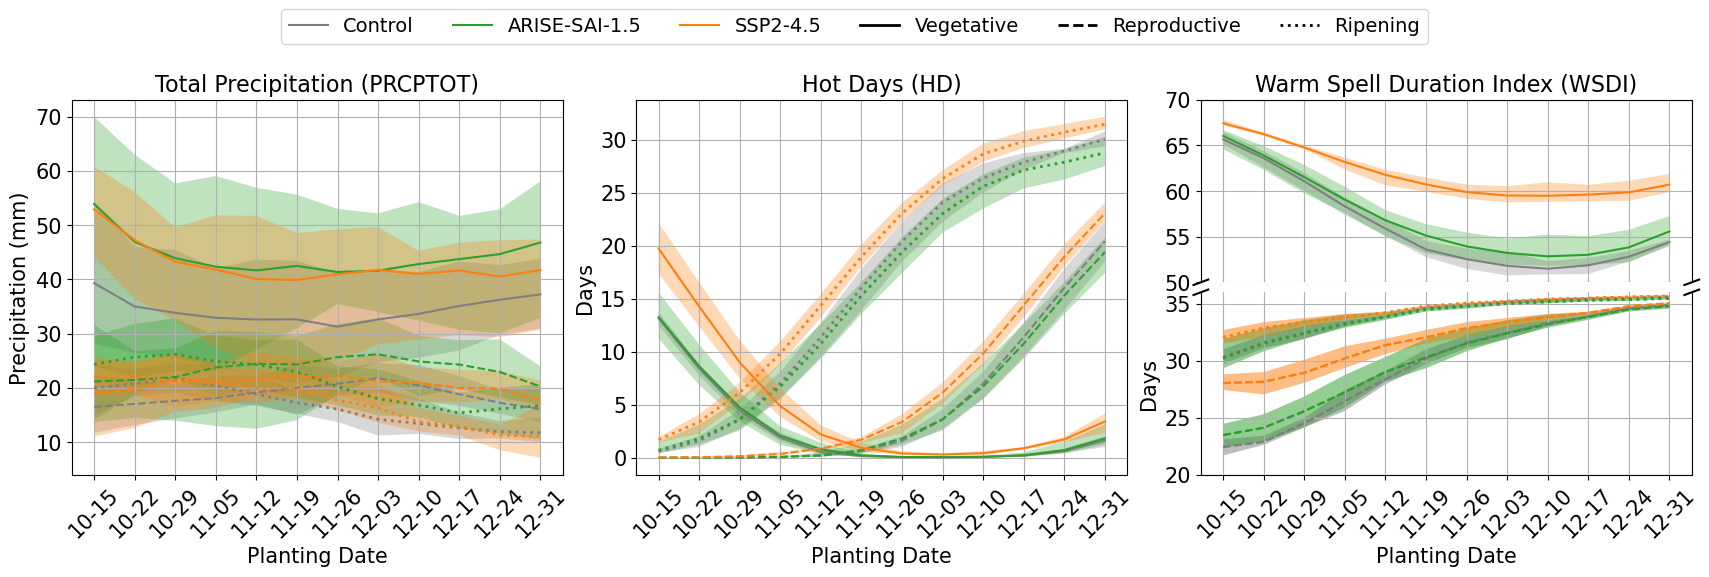

In [32]:
# Define function to plot data
def plot_data(ax, xaxis, ensmean, veg, rep, rip, color, label_prefix):
    ax.plot(xaxis, ensmean.vegetative.dropna(dim='dayofyear'), color=color, ls='-', label=label_prefix+'_Veg')
    ax.plot(xaxis, rep_dates(ensmean), color=color, ls='--', label=label_prefix+'_Rep')
    ax.plot(xaxis, ensmean.ripening.dropna(dim='dayofyear'), color=color, ls=':', linewidth=2, label=label_prefix+'_Ripe')

    ax.fill_between(xaxis, np.min(np.array(veg), axis=0), np.max(np.array(veg), axis=0), color=color, alpha=alpha, ec=None)
    ax.fill_between(xaxis, np.min(np.array(rep), axis=0), np.max(np.array(rep), axis=0), color=color, alpha=alpha, ec=None)
    ax.fill_between(xaxis, np.min(np.array(rip), axis=0), np.max(np.array(rip), axis=0), color=color, alpha=alpha, ec=None)


# Define xaxis, ticks, and alpha
xaxis = range(12)  # number of sowing dates
alpha = 0.3
tick_labels = ['10-15', '10-22', '10-29', '11-05', '11-12', '11-19', '11-26', '12-03', '12-10', '12-17', '12-24', '12-31']
y_labels = ['Precipitation (mm)', 'Days', 'Days']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Save custom y limits for 3rd subplots
lower_plot = [None, None, (20, 36)]
upper_plot = [None, None, (50, 70)]

# Loop through the dictionaries
for i, label in enumerate(ctrl_ensmean_planting_dates):

    # Get corresponding ensmean data
    ctrl_ensmean = ctrl_ensmean_planting_dates[label]
    arise_ensmean = arise_ensmean_planting_dates[label]
    ssp_ensmean = ssp245_ensmean_planting_dates[label]

    # Add breaklines to the 2nd and 7th subplots
    if i == 2:
        ax = axs[i]
        divider = make_axes_locatable(ax)
        ax2 = divider.new_vertical(size="100%", pad=0.1)
        fig.add_axes(ax2)

        # ax.scatter(x, y)
        plot_data(ax, xaxis, ctrl_ensmean, ctrl_veg_data[i], ctrl_rep_data[i], ctrl_rip_data[i], 'tab:gray', 'Control')
        plot_data(ax, xaxis, arise_ensmean, arise_veg_data[i], arise_rep_data[i], arise_rip_data[i], 'tab:green', 'ARISE')
        plot_data(ax, xaxis, ssp_ensmean, ssp_veg_data[i], ssp_rep_data[i], ssp_rip_data[i], 'tab:orange', 'SSP2-4.5')

        ax.set_ylim(lower_plot[i])
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_tick_params(labelsize=15)
        
        # ax2.scatter(x, y)
        plot_data(ax2, xaxis, ctrl_ensmean, ctrl_veg_data[i], ctrl_rep_data[i], ctrl_rip_data[i], 'tab:gray', 'Control')
        plot_data(ax2, xaxis, arise_ensmean, arise_veg_data[i], arise_rep_data[i], arise_rip_data[i], 'tab:green', 'ARISE')
        plot_data(ax2, xaxis, ssp_ensmean, ssp_veg_data[i], ssp_rep_data[i], ssp_rip_data[i], 'tab:orange', 'SSP2-4.5')

        ax2.set_ylim(upper_plot[i])
        ax2.tick_params(bottom=False, labelbottom=False)
        ax2.spines['bottom'].set_visible(False)
        ax2.grid(True)
        ax2.set_xticks(xaxis)
        ax2.set_title(label, fontsize=16)
        ax2.yaxis.set_tick_params(labelsize=15)
        
        # From https://matplotlib.org/examples/pylab_examples/broken_axis.html
        d = .015  # how big to make the diagonal lines in axes coordinates
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
        ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
        ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
        
        kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
        ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
        ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # Plot the data on the corresponding subplot
    plot_data(axs[i], xaxis, ctrl_ensmean, ctrl_veg_data[i], ctrl_rep_data[i], ctrl_rip_data[i], 'tab:gray', 'Control')
    plot_data(axs[i], xaxis, arise_ensmean, arise_veg_data[i], arise_rep_data[i], arise_rip_data[i], 'tab:green', 'ARISE')
    plot_data(axs[i], xaxis, ssp_ensmean, ssp_veg_data[i], ssp_rep_data[i], ssp_rip_data[i], 'tab:orange', 'SSP2-4.5')

    # Set subplot title
    if i != 2:
        axs[i].set_title(label, fontsize=16)

    # Specify tick values and labels along the x-axis
    axs[i].set_xticks(xaxis)
    axs[i].set_xticklabels(tick_labels, rotation=45, fontsize=15)
    # Get the current subplot's size
    subplot_size = axs[i].get_position().size

    # Calculate the space each tick label occupies within the subplot
    label_width = subplot_size[0] / len(tick_labels)

    # Set step for displaying tick labels within the subplot
    step = max(1, int(label_width / 0.15))  # Adjust the value 0.15 to fit your preference

    # Show only every 'step' tick label within the subplot
    for k, label in enumerate(axs[i].xaxis.get_ticklabels()):
        if k % step != 0:
            label.set_visible(False)

    axs[i].yaxis.set_tick_params(labelsize=15)

    # Add x and y labels for each subplot
    axs[i].set_xlabel('Planting Date', fontsize=15)
    axs[i].set_ylabel(y_labels[i], fontsize=15)

    # Apply grid to each subplot
    axs[i].grid(True)

# Create custom legend
legend_elements = [
    plt.Line2D([0], [0], color='tab:gray', linestyle='-', label='Control'),
    plt.Line2D([0], [0], color='tab:green', linestyle='-', label='ARISE-SAI-1.5'),
    plt.Line2D([0], [0], color='tab:orange', linestyle='-', label='SSP2-4.5'),
    plt.Line2D([0], [0], color='k', linestyle='-', linewidth=2, label='Vegetative'),
    plt.Line2D([0], [0], color='k', linestyle='--', linewidth=2, label='Reproductive'),
    plt.Line2D([0], [0], color='k', linestyle=':', linewidth=2, label='Ripening'),
]
# Create the legend outside the loop
fig.legend(handles=legend_elements, loc='upper center', ncols=6, fontsize=14)
# fig.suptitle('Climate Indices by Sowing Date', fontsize=18)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.80, hspace=0.50, wspace=0.15)

## Fig C: Temp and Precip Distribution Changes

Distribution of tmax, tmin, and total growing season precipitation during the control period and 2050-2069 in ARISE and SSP245 averaged over rice and wheat growing regions.

In [17]:
# Tmin
control_tmin_wheat = []
for mem in tmin[15:]:
    ctrl = mem.sel(time=slice("2015", "2035")).salem.roi(shape=india_mask)
    oct_mar = ctrl.sel(time=ctrl["time.month"].isin([10, 11, 12, 1, 2, 3, 4, 5]))
    oct_mar = oct_mar.where(regridded_wheatmask >= wheat_threshold)
    control_tmin_wheat.append(oct_mar)

tmin_exp_wheat = []
for mem in tmin:
    exp = mem.sel(time=slice("2050", "2069")).salem.roi(shape=india_mask)
    oct_mar = exp.sel(time=exp["time.month"].isin([10, 11, 12, 1, 2, 3, 4, 5]))
    oct_mar = oct_mar.where(regridded_wheatmask >= wheat_threshold)
    tmin_exp_wheat.append(oct_mar)

ssp_245_tmin_wheat = tmin_exp_wheat[15:]
arise_tmin_wheat = tmin_exp_wheat[:10]


# Tmax
control_tmax_wheat = []
for mem in tmax[15:]:
    ctrl = mem.sel(time=slice("2015", "2035")).salem.roi(shape=india_mask)
    oct_mar = ctrl.sel(time=ctrl["time.month"].isin([10, 11, 12, 1, 2, 3, 4, 5]))
    oct_mar = oct_mar.where(regridded_wheatmask >= wheat_threshold)
    control_tmax_wheat.append(oct_mar)

tmax_exp_wheat = []
for mem in tmax:
    exp = mem.sel(time=slice("2050", "2069")).salem.roi(shape=india_mask)
    oct_mar = exp.sel(time=exp["time.month"].isin([10, 11, 12, 1, 2, 3, 4, 5]))
    oct_mar = oct_mar.where(regridded_wheatmask >= wheat_threshold)
    tmax_exp_wheat.append(oct_mar)

ssp_245_tmax_wheat = tmax_exp_wheat[15:]
arise_tmax_wheat = tmax_exp_wheat[:10]


In [18]:
# Precip
control_prcp_wheat=[]
for mem in control_PTOT:
    veg = mem.groupby('year').mean('time').vegetative
    rep = mem.groupby('year').mean('time').reproductive
    rip = mem.groupby('year').mean('time').ripening
    control_prcp_wheat.append((veg + rep + rip).salem.roi(shape=india_mask).where(regridded_wheatmask >= wheat_threshold))


prcp_exp_wheat = []
for mem in exp_PTOT:
    veg = mem.groupby('year').mean('time').sel(year=slice('2050', '2069')).vegetative
    rep = mem.groupby('year').mean('time').sel(year=slice('2050', '2069')).reproductive
    rip = mem.groupby('year').mean('time').sel(year=slice('2050', '2069')).ripening
    prcp_exp_wheat.append((veg + rep + rip).salem.roi(shape=india_mask).where(regridded_wheatmask >= wheat_threshold))

ssp_245_prcp_wheat = prcp_exp_wheat[15:]
arise_prcp_wheat = prcp_exp_wheat[:10]


In [20]:
with open('/glade/work/ninag/PDF_Inputs/ssp_245_tmin_wheat.pkl', 'wb') as file:
    pickle.dump(ssp_245_tmin_wheat, file)

with open('/glade/work/ninag/PDF_Inputs/arise_tmin_wheat.pkl', 'wb') as file:
    pickle.dump(arise_tmin_wheat, file)

with open('/glade/work/ninag/PDF_Inputs/ssp_245_tmax_wheat.pkl', 'wb') as file:
    pickle.dump(ssp_245_tmax_wheat, file)

with open('/glade/work/ninag/PDF_Inputs/arise_tmax_wheat.pkl', 'wb') as file:
    pickle.dump(arise_tmax_wheat, file)

with open('/glade/work/ninag/PDF_Inputs/ssp_245_prcp_wheat.pkl', 'wb') as file:
    pickle.dump(ssp_245_prcp_wheat, file)

with open('/glade/work/ninag/PDF_Inputs/arise_prcp_wheat.pkl', 'wb') as file:
    pickle.dump(arise_prcp_wheat, file)


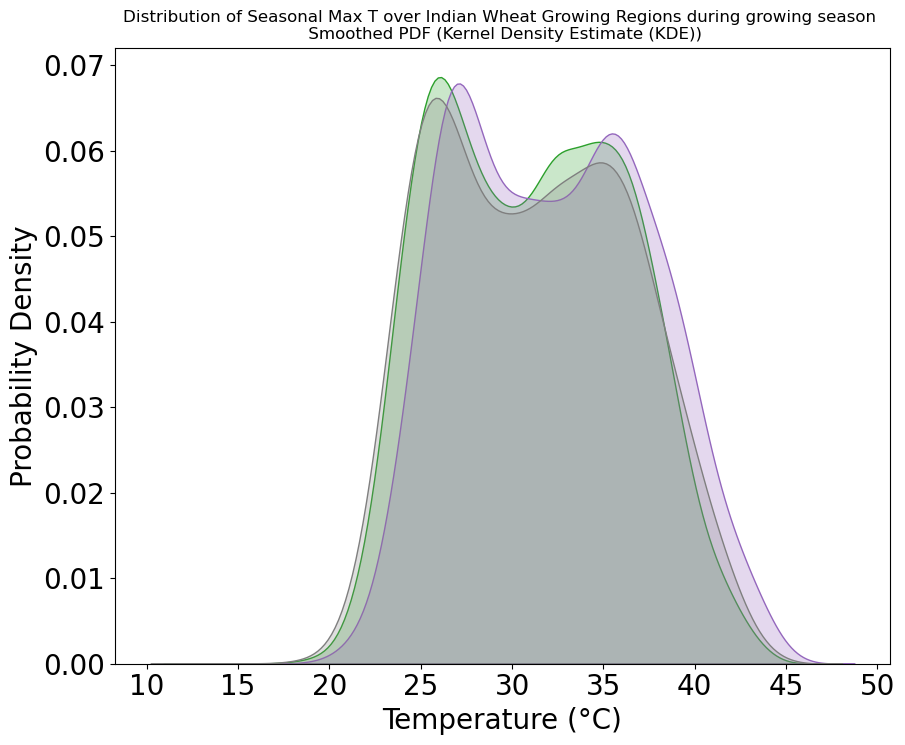

In [34]:
# Flatten the DataArrays
all_mem_ctrl_tmax_wheat = np.array([])
for mem in control_tmax_wheat:
    all_mem_ctrl_tmax_wheat = np.append(all_mem_ctrl_tmax_wheat, mem.mean(["lon", "lat"]).values)

all_mem_arise_tmax_wheat = np.array([])
for mem in arise_tmax_wheat:
    all_mem_arise_tmax_wheat = np.append(all_mem_arise_tmax_wheat, mem.mean(["lon", "lat"]).values)

all_mem_ssp_tmax_wheat = np.array([])
for mem in ssp_245_tmax_wheat:
    all_mem_ssp_tmax_wheat = np.append(all_mem_ssp_tmax_wheat, mem.mean(["lon", "lat"]).values)

# Combine all data into a single array
all_data = np.concatenate([
    all_mem_ctrl_tmax_wheat,
    all_mem_ssp_tmax_wheat,
    all_mem_arise_tmax_wheat,
])

# Create a DataFrame with a column indicating the group
df = pd.DataFrame({
    'Data': all_data,
    'Group': np.repeat(['Control', 'SSP', 'ARISE'], [len(all_mem_ctrl_tmax_wheat), len(all_mem_ssp_tmax_wheat), len(all_mem_arise_tmax_wheat)])
})

# Define colors for each group
color_dict = {'Control': 'teal', 'ARISE': 'magenta', 'SSP': 'yellow'}

# Plot using seaborn's kdeplot
plt.figure(figsize=(10, 8))
# sns.kdeplot(data=df, x='Data', hue='Group', fill=True, common_norm=False, palette=color_dict, bw_adjust=1.5)
sns.kdeplot(data=df, x='Data', hue='Group', fill=True, common_norm=False, palette="tab10_r", bw_adjust=1.5, legend=False)
# sns.kdeplot(data=df, x='Data', hue='Group', fill=True, common_norm=False, palette="CMRmap", bw_adjust=1.5)


plt.title('Distribution of Seasonal Max T over Indian Wheat Growing Regions during growing season \n Smoothed PDF (Kernel Density Estimate (KDE))')
plt.xlabel('Temperature (\N{DEGREE SIGN}C)', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
# plt.legend(fontsize=18)
plt.show()

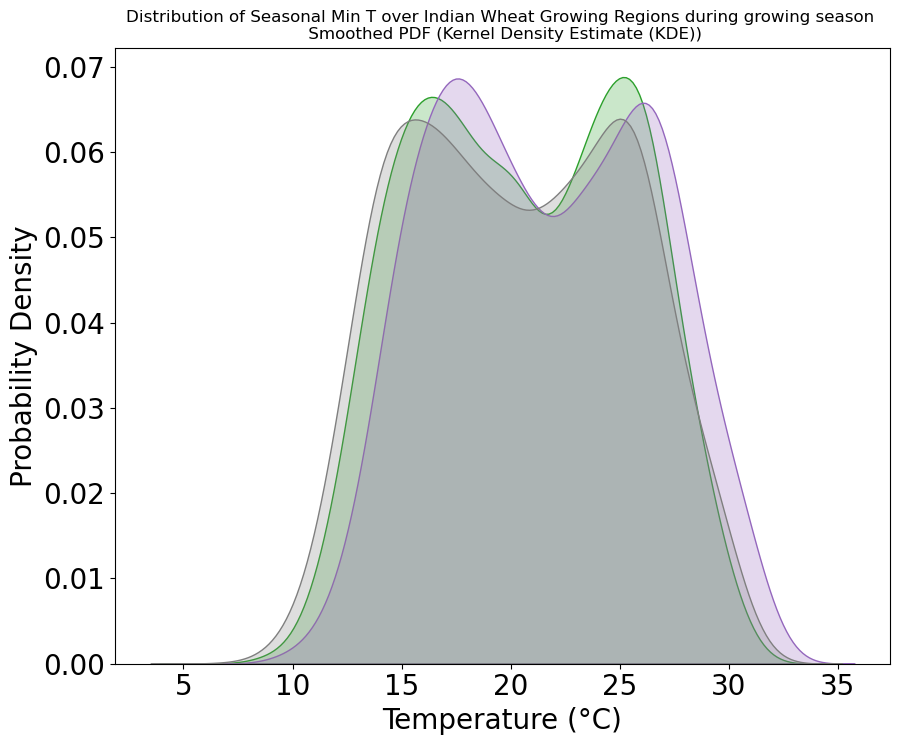

In [35]:
# Step 1: Flatten the DataArrays
all_mem_ctrl_tmin_wheat = np.array([])
for mem in control_tmin_wheat:
    all_mem_ctrl_tmin_wheat = np.append(all_mem_ctrl_tmin_wheat, mem.mean(["lon", "lat"]).values)

all_mem_arise_tmin_wheat = np.array([])
for mem in arise_tmin_wheat:
    all_mem_arise_tmin_wheat = np.append(all_mem_arise_tmin_wheat, mem.mean(["lon", "lat"]).values)

all_mem_ssp_tmin_wheat = np.array([])
for mem in ssp_245_tmin_wheat:
    all_mem_ssp_tmin_wheat = np.append(all_mem_ssp_tmin_wheat, mem.mean(["lon", "lat"]).values)

# Combine all data into a single array
all_data = np.concatenate([
    all_mem_ctrl_tmin_wheat,
    all_mem_ssp_tmin_wheat,
    all_mem_arise_tmin_wheat,
])

# Create a DataFrame with a column indicating the group
df = pd.DataFrame({
    'Data': all_data,
    'Group': np.repeat(['Control', 'SSP', 'ARISE'], [len(all_mem_ctrl_tmin_wheat), len(all_mem_ssp_tmin_wheat), len(all_mem_arise_tmin_wheat)])
})

# Plot using seaborn's kdeplot
plt.figure(figsize=(10, 8))
sns.kdeplot(data=df, x='Data', hue='Group', fill=True, common_norm=False, palette="tab10_r", bw_adjust=1.5, legend=False)
# sns.kdeplot(data=df, x='Data', hue='Group', fill=True, common_norm=False, palette="CMRmap", bw_adjust=1.5)

plt.title('Distribution of Seasonal Min T over Indian Wheat Growing Regions during growing season \n Smoothed PDF (Kernel Density Estimate (KDE))')
plt.xlabel('Temperature (\N{DEGREE SIGN}C)', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
# plt.legend(fontsize=18)
plt.show()

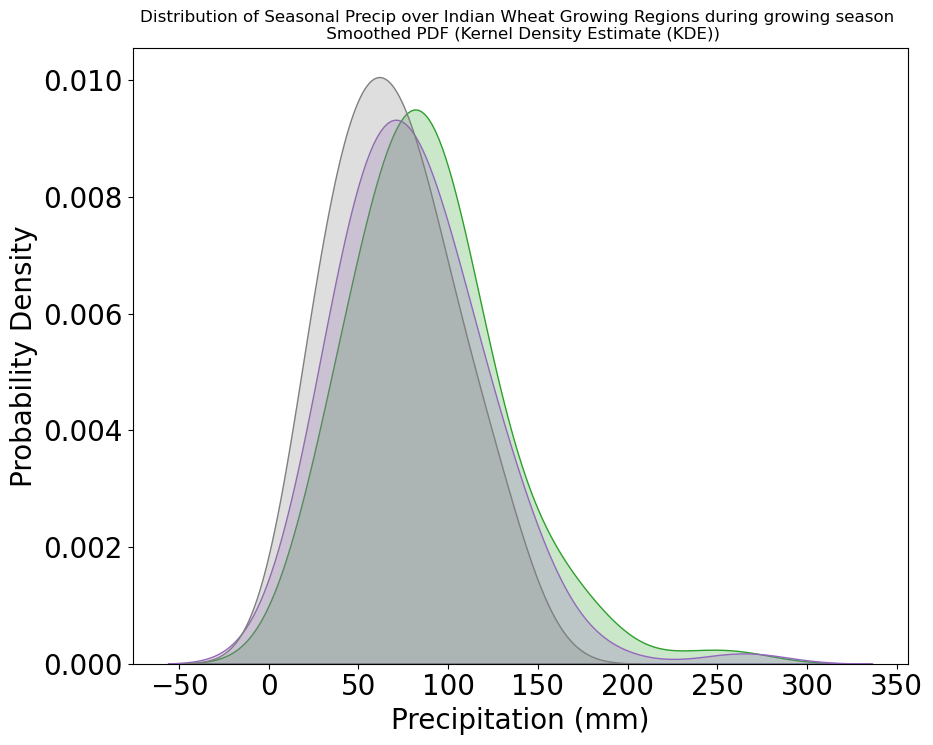

In [36]:
# Flatten the DataArrays
all_mem_ctrl_prcp_wheat = np.array([])
for mem in control_prcp_wheat:
    all_mem_ctrl_prcp_wheat = np.append(all_mem_ctrl_prcp_wheat, mem.mean(['lon', 'lat']).values)

all_mem_arise_prcp_wheat = np.array([])
for mem in arise_prcp_wheat:
    all_mem_arise_prcp_wheat = np.append(all_mem_arise_prcp_wheat, mem.mean(['lon', 'lat']).values)

all_mem_ssp_prcp_wheat = np.array([])
for mem in ssp_245_prcp_wheat:
    all_mem_ssp_prcp_wheat = np.append(all_mem_ssp_prcp_wheat, mem.mean(['lon', 'lat']).values)


# Combine all data into a single array
all_data = np.concatenate([
    all_mem_ctrl_prcp_wheat,
    all_mem_ssp_prcp_wheat,
    all_mem_arise_prcp_wheat,
])

# Create a DataFrame with a column indicating the group
df = pd.DataFrame({
    'Data': all_data,
    'Group': np.repeat(['Control', 'SSP', 'ARISE'], [len(all_mem_ctrl_prcp_wheat), len(all_mem_ssp_prcp_wheat), len(all_mem_arise_prcp_wheat)])
})

# Plot using seaborn's kdeplot
plt.figure(figsize=(10, 8))
sns.kdeplot(data=df, x='Data', hue='Group', fill=True, common_norm=False, palette="tab10_r", bw_adjust=1.5, legend=False)
# sns.kdeplot(data=df, x='Data', hue='Group', fill=True, common_norm=False, palette="CMRmap", bw_adjust=1.5)

plt.title('Distribution of Seasonal Precip over Indian Wheat Growing Regions during growing season \n Smoothed PDF (Kernel Density Estimate (KDE))')
plt.xlabel('Precipitation (mm)', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
# plt.legend(fontsize=18)
plt.show()